# File for checking import and first visualization
cifar consists of 5 batches (downloaded from http://www.cs.toronto.edu/~kriz/cifar.html)
data is stored in data/cifar/cifar-10-batches-by
code for automatic download in solution from deep-diver (uncommented)

In [4]:
import numpy as np
import pandas as pd
import random
import pickle
import matplotlib.pyplot as plt
import cv2
import joblib
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.compat.v1.enable_v2_behavior()
tf.disable_v2_behavior()
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder
import os
from cv2 import xfeatures2d
import time 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, ConfusionMatrixDisplay, precision_score, make_scorer
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint   

import time


c:\Users\sofij\Anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [49]:

import numpy as np 
import pandas as pd 
import os
import copy
import time
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import copy
import time

import torch_optimizer as optim
from res_mlp_pytorch import ResMLP
from PIL import Image
# from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/Users/nadia/Desktop/TUSS23/ML/MachineLearningEx3/venv/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [50]:
# pip install opencv-contrib-python --user
# ! pip install res-mlp-pytorch
# ! pip install torch-optimizer
# pip install -U tensorflow-addons

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## own solution

### Dataset importing

In [6]:
def unpickle(file):
    """
    returns a  from cifar data
    :param file:
    :return:
    """
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [7]:
def load_train_test_data(path_to_data='data/cifar/cifar-10-batches-py'):
    """
    :param path_to_data: path to
    :return: X_train, y_train, X_test, y_test, label_names
    """

    dict_b1 = unpickle(path_to_data + "/data_batch_1")
    dict_b2 = unpickle(path_to_data + "/data_batch_2")
    dict_b3 = unpickle(path_to_data + "/data_batch_3")
    dict_b4 = unpickle(path_to_data + "/data_batch_4")
    dict_b5 = unpickle(path_to_data + "/data_batch_5")
    dict_meta = unpickle(path_to_data + "/batches.meta")
    dict_test = unpickle(path_to_data + "/test_batch")

    data_b1 = dict_b1[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2,3,1)
    data_b2 = dict_b2[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2,3,1)
    data_b3 = dict_b3[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2,3,1)
    data_b4 = dict_b4[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2,3,1)
    data_b5 = dict_b5[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2,3,1)
    labels_b1 = dict_b1[b'labels']
    labels_b2 = dict_b2[b'labels']
    labels_b3 = dict_b3[b'labels']
    labels_b4 = dict_b4[b'labels']
    labels_b5 = dict_b5[b'labels']


    X_test = dict_test[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2,3,1)
    y_test = np.array(dict_test[b'labels'])
    X_train = np.concatenate([data_b1, data_b2, data_b3, data_b4, data_b5])
    y_train = np.concatenate([labels_b1, labels_b2, labels_b3, labels_b4, labels_b5])
    label_names = dict_meta[b'label_names']
    label_names = [name.decode('utf-8') for name in label_names]  # encode (remove b'')

    return X_train, y_train, X_test, y_test, label_names



In [8]:
X_train, y_train, X_test, y_test, label_names = load_train_test_data()

In [9]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (50000, 32, 32, 3)
Shape of y_train: (50000,)
Shape of X_test: (10000, 32, 32, 3)
Shape of y_test: (10000,)


In [10]:
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1,1))
y_test_encoded = encoder.transform(y_test.reshape(-1,1))

In [11]:
print("Shape of y_train_encoded:", y_train_encoded.shape)
print("Shape of y_test_encoded:", y_test_encoded.shape)

Shape of y_train_encoded: (50000, 10)
Shape of y_test_encoded: (10000, 10)


In [19]:
print("Training set")
num_classes = len(np.unique(y_train))
num_per_class = np.zeros(num_classes)
for i in range(0, num_classes):
    num_per_class[i] = sum(y_train == i)
    print("Class", i, "-", label_names[i], ":", int(num_per_class[i]), "images")

print("_______________________________")
print("Testing set")
num_classes = len(np.unique(y_test))
num_per_class_test = np.zeros(num_classes)
for i in range(0, num_classes):
    num_per_class_test[i] = sum(y_test == i)
    print("Class", i, "-", label_names[i], ":", int(num_per_class_test[i]), "images")


Training set
Class 0 - airplane : 5000 images
Class 1 - automobile : 5000 images
Class 2 - bird : 5000 images
Class 3 - cat : 5000 images
Class 4 - deer : 5000 images
Class 5 - dog : 5000 images
Class 6 - frog : 5000 images
Class 7 - horse : 5000 images
Class 8 - ship : 5000 images
Class 9 - truck : 5000 images
_______________________________
Testing set
Class 0 - airplane : 1000 images
Class 1 - automobile : 1000 images
Class 2 - bird : 1000 images
Class 3 - cat : 1000 images
Class 4 - deer : 1000 images
Class 5 - dog : 1000 images
Class 6 - frog : 1000 images
Class 7 - horse : 1000 images
Class 8 - ship : 1000 images
Class 9 - truck : 1000 images


### Dataset visualizations

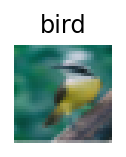

In [11]:
# Choose an index to select an image from the dataset
index = 27001

# Set the figure size
plt.figure(figsize=(0.9, 0.9))

# Get the image and label
image = X_train[index]
label = y_train[index]

# Plot the image
plt.imshow(image)
plt.title(label_names[label])
plt.axis('off')
plt.show()

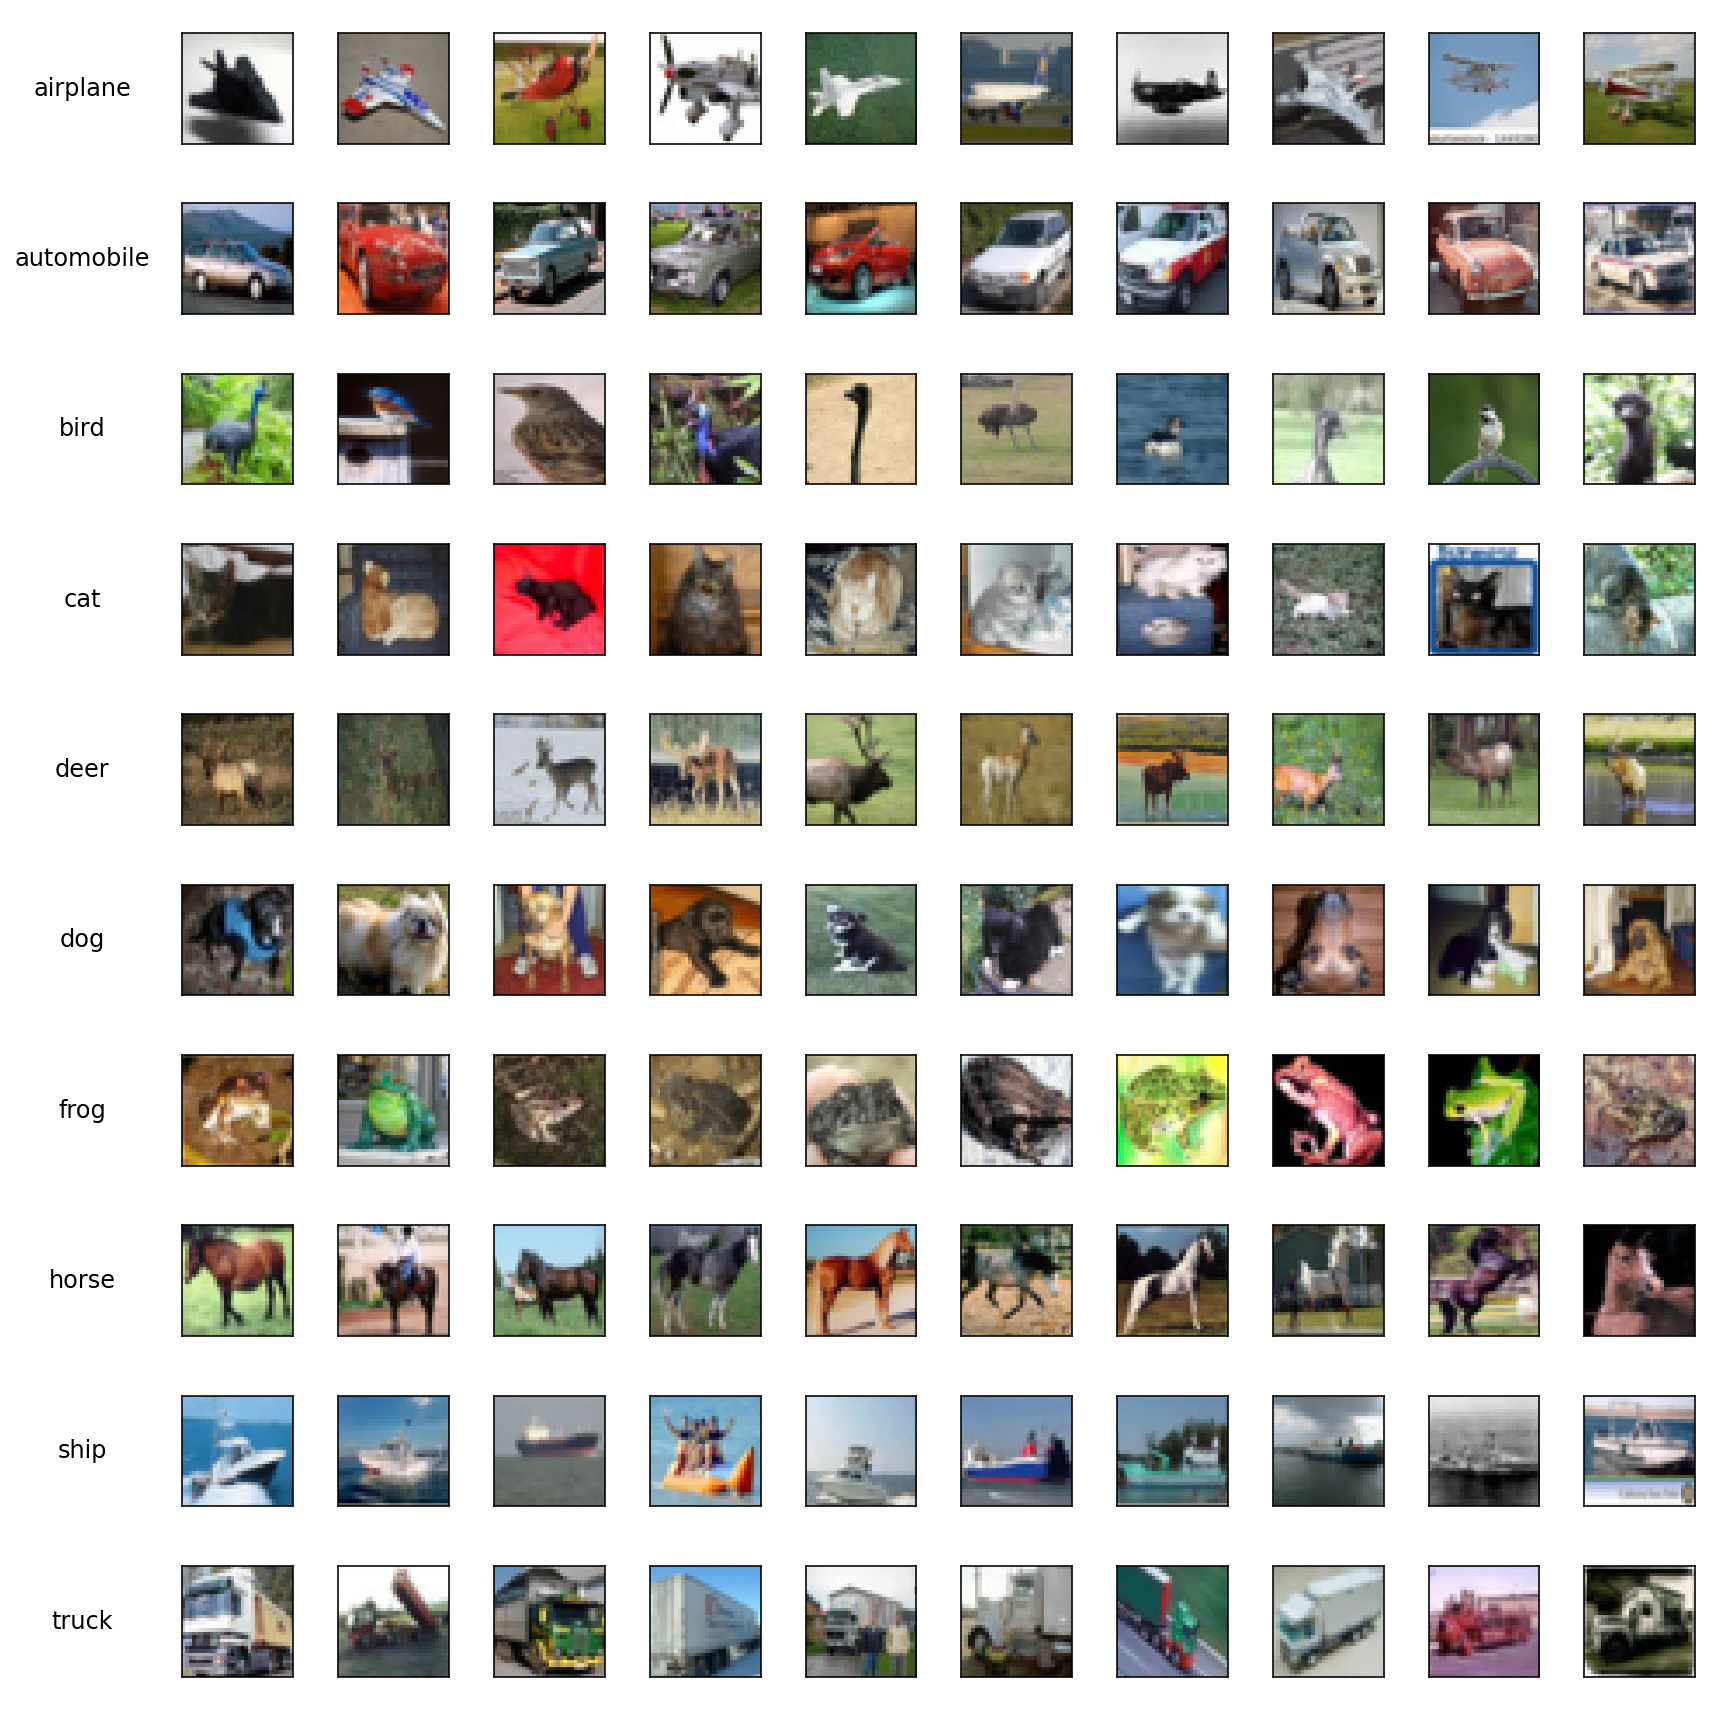

In [12]:
fig, ax = plt.subplots(nrows=num_classes, ncols=11, figsize=(12, 12))

for i in range(0, num_classes):
    indices = np.where(y_train == i)[0]
    indices = indices[:10] # first 10 images belonging to i-th class 
    for j in range(0, 10):
        img = X_train[indices[j], :, :, :]
        ax[i, j+1].imshow(img)
        ax[i, j+1].set_xticks([]); ax[i, j+1].set_yticks([])
        ax[i, j+1].set_xticklabels([]); ax[i, j+1].set_yticklabels([])
    ax[i, 0].text(0.5, 0.5, label_names[i], fontsize=12, ha='center', va='center')
    ax[i, 0].set_xticks([]); ax[i, 0].set_yticks([])
    ax[i, 0].set_xticklabels([]); ax[i, 0].set_yticklabels([])

    # remove frame of the plot by setting spines visibility to False
    for spine in ax[i, 0].spines.values():
        spine.set_visible(False)

plt.tight_layout()
plt.show()

### "Traditional" feature extraction methods: 1. colour histogram

In [12]:
def calculate_color_histogram(index, num_bins=256):
    img = X_train[index]

    # RGB color space
    r = img[:, :, 0] # first RGB plane corresponds to red color channel -> shape: (32, 32)
    g = img[:, :, 1] # second RGB plane corresponds to green color channel
    b = img[:, :, 2] # third RGB plane corresponds to blue color channel

    # compute the histograms for the all image channel
    hist_r, _ = np.histogram(r, bins=num_bins, range=(0, num_bins))
    hist_g, _ = np.histogram(g, bins=num_bins, range=(0, num_bins))
    hist_b, _ = np.histogram(b, bins=num_bins, range=(0, num_bins))

    # convert histograms to floating-point type before normalization
    hist_r = hist_r.astype(np.float32)
    hist_g = hist_g.astype(np.float32)
    hist_b = hist_b.astype(np.float32)

    hist_r /= hist_r.sum()
    hist_g /= hist_g.sum()
    hist_b /= hist_b.sum()

    return hist_r, hist_g, hist_b

In [13]:
# Plot color histograms and R, G, B channels as grayscale images
def plot_rgb(r_hist, g_hist, b_hist, index):
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

    ax[0, 0].imshow(X_train[index]); ax[0, 0].set_xticks([]); ax[0, 0].set_yticks([]); ax[0, 0].set_title('RGB image')
    ax[0, 1].imshow(X_train[index]); ax[0, 1].set_xticks([]); ax[0, 1].set_yticks([]); ax[0, 1].set_title('RGB image')
    ax[0, 2].imshow(X_train[index]); ax[0, 2].set_xticks([]); ax[0, 2].set_yticks([]); ax[0, 2].set_title('RGB image')

    ax[1, 0].plot(r_hist, 'red'); ax[1, 0].set_xlim([0, len(r_hist)]); ax[1, 0].set_title('R histogram'); ax[1, 0].set_xlabel('bins'); ax[1, 0].set_ylabel('normalized frequency')
    ax[1, 1].plot(g_hist, 'green'); ax[1, 1].set_xlim([0, len(g_hist)]); ax[1, 1].set_title('G histogram'); ax[1, 1].set_xlabel('bins'); ax[1, 1].set_ylabel('normalized frequency')
    ax[1, 2].plot(b_hist, 'blue'); ax[1, 2].set_xlim([0, len(b_hist)]); ax[1, 2].set_title('B histogram'); ax[1, 2].set_xlabel('bins'); ax[1, 2].set_ylabel('normalized frequency')

    ax[2, 0].imshow(X_train[index][:, :, 0], cmap='gray'); ax[2, 0].set_xticks([]); ax[2, 0].set_yticks([]); ax[2, 0].set_title('R channel matrix')
    ax[2, 1].imshow(X_train[index][:, :, 1], cmap='gray'); ax[2, 1].set_xticks([]); ax[2, 1].set_yticks([]); ax[2, 1].set_title('G channel matrix')
    ax[2, 2].imshow(X_train[index][:, :, 2], cmap='gray'); ax[2, 2].set_xticks([]); ax[2, 2].set_yticks([]); ax[2, 2].set_title('B channel matrix')

    plt.show()


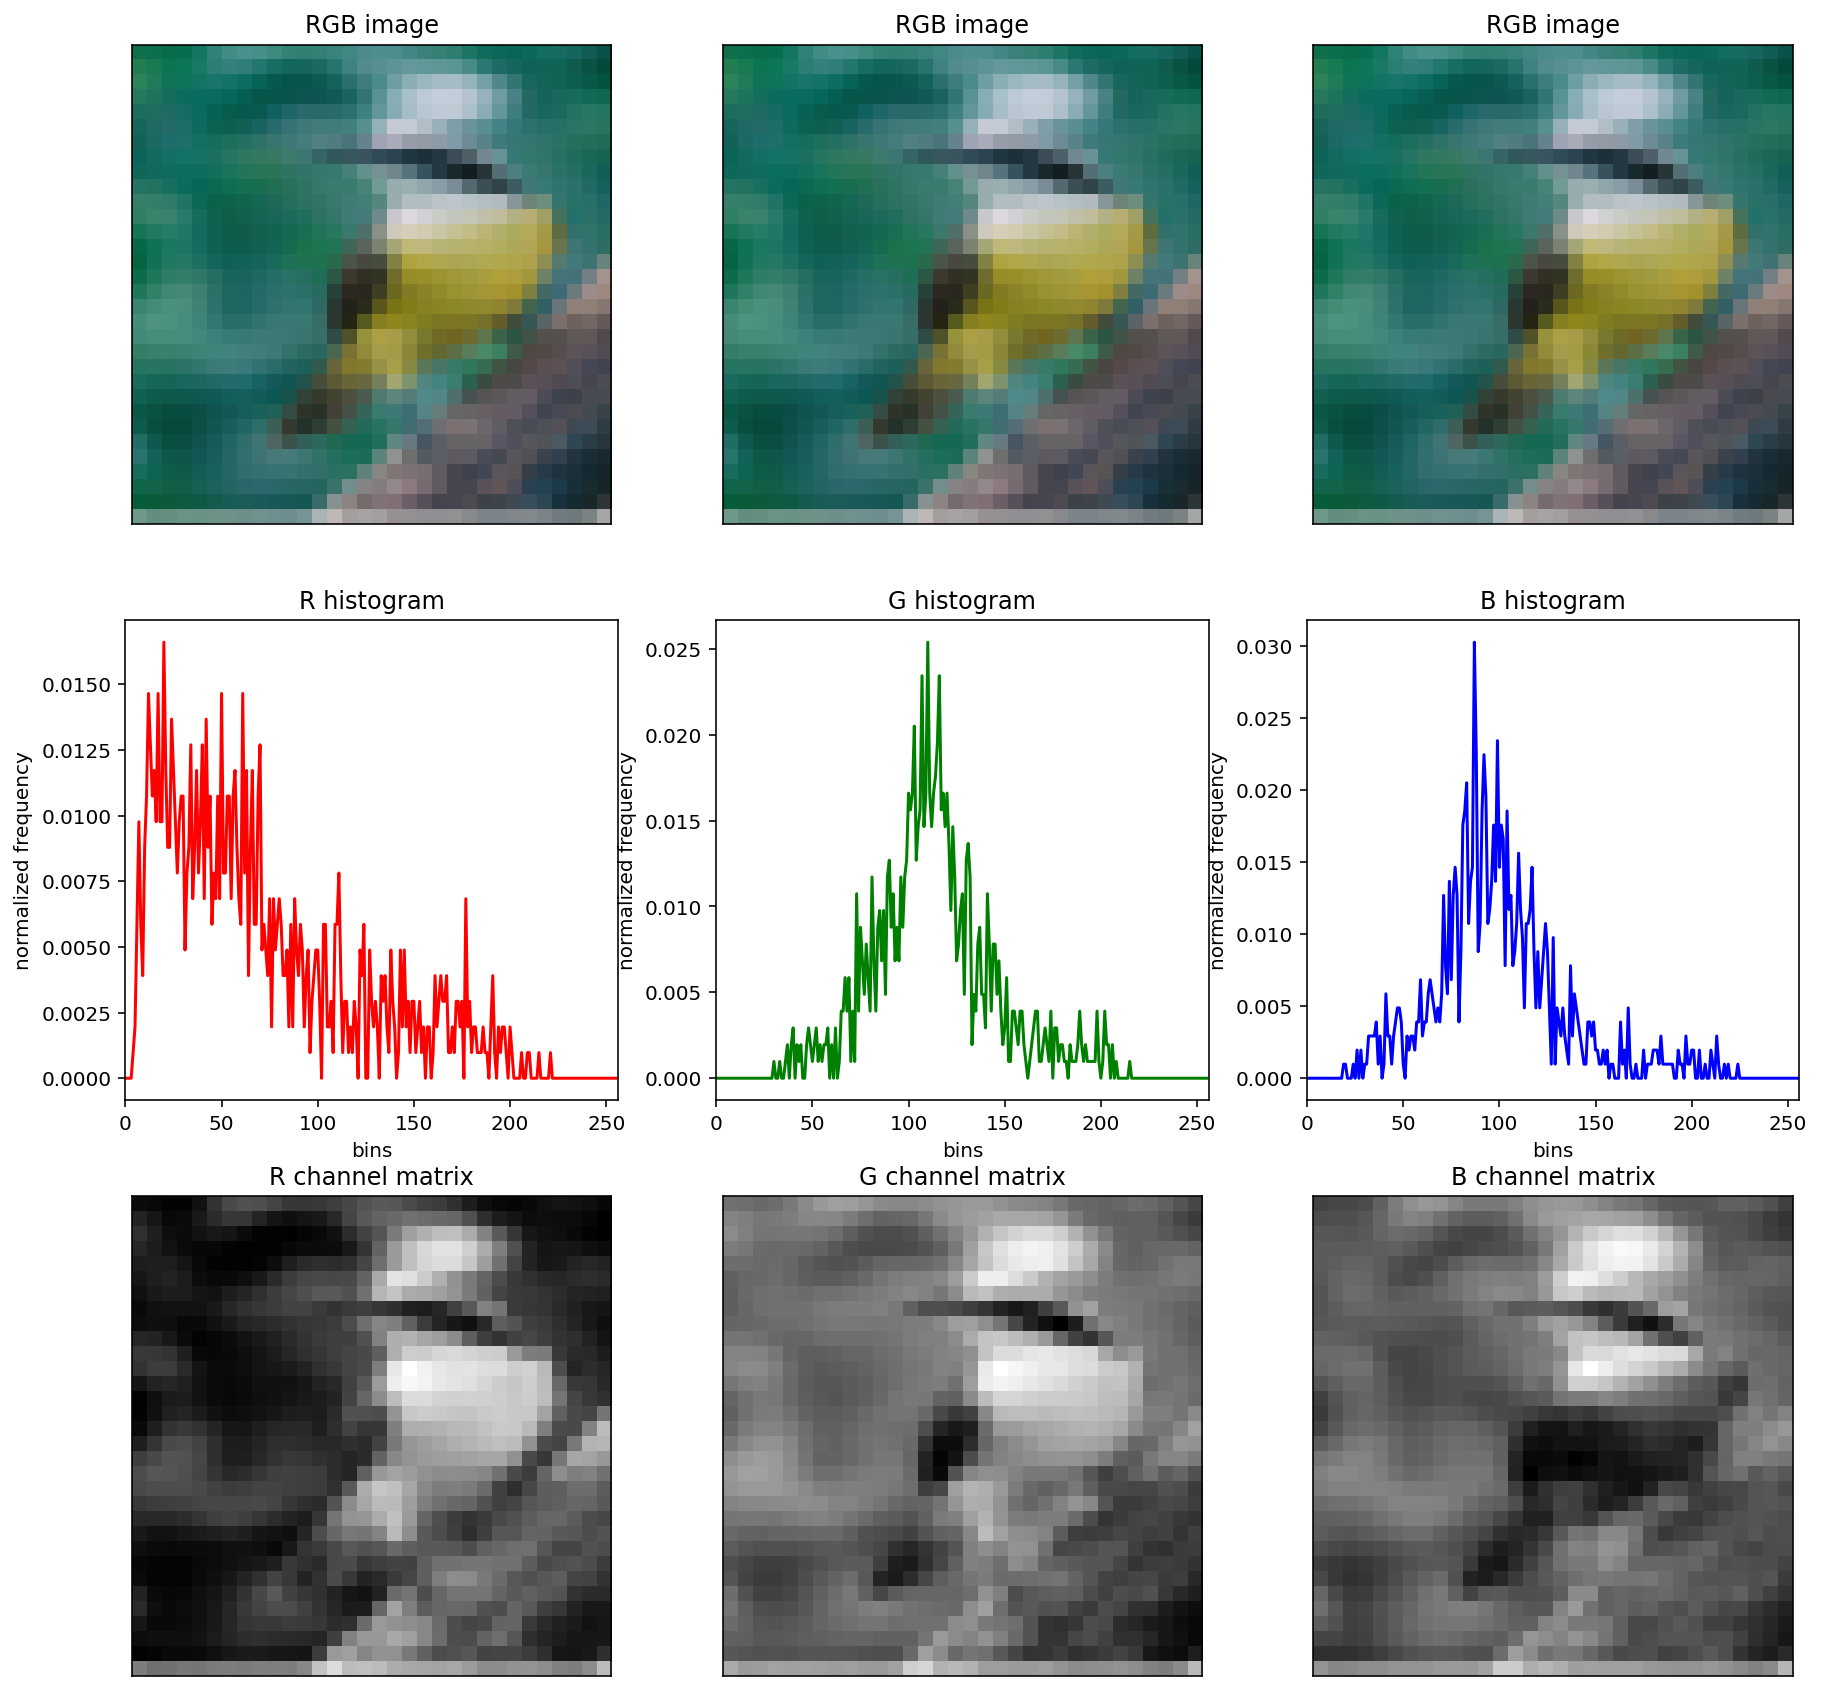

In [38]:
r_hist, g_hist, b_hist = calculate_color_histogram(index=27001)
plot_rgb(r_hist, g_hist, b_hist, index=27001)

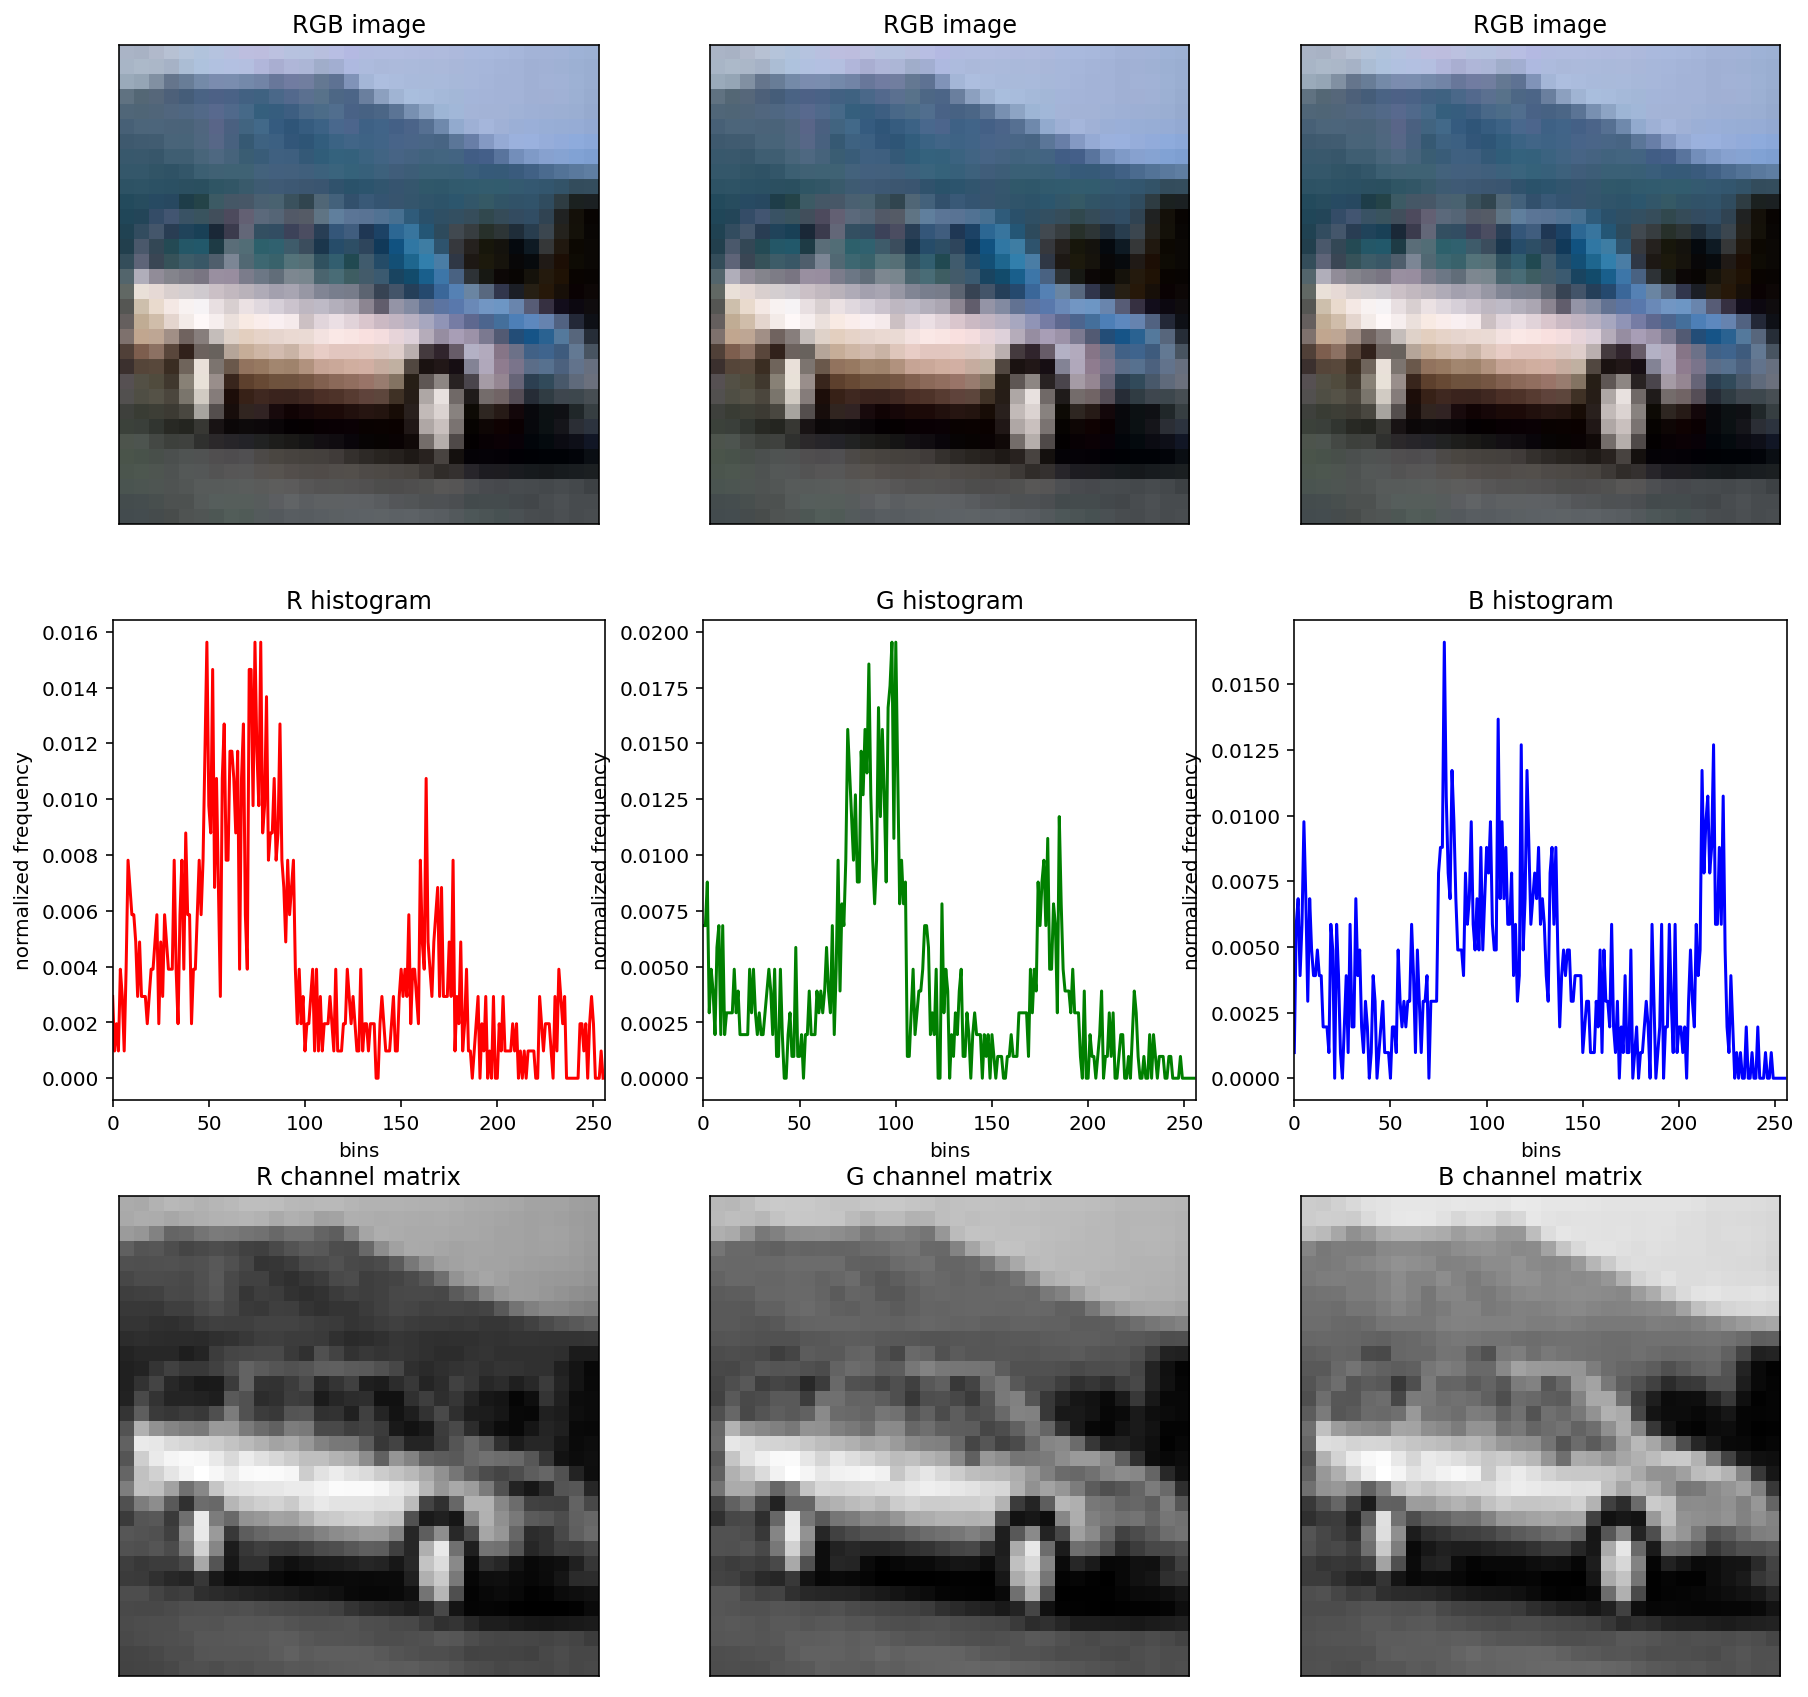

In [39]:
r_hist, g_hist, b_hist = calculate_color_histogram(index=4)
plot_rgb(r_hist, g_hist, b_hist, index=4)

### k-NN classifier 
features: 1. concatenation of R, G, B colour histograms

In [14]:
import time

start_time = time.time()
num_samples = X_train.shape[0]
X_train_feature_vects = np.zeros([num_samples, 3*256])
for i in range(0, num_samples): 
    r_hist, g_hist, b_hist = calculate_color_histogram(index=i)
    X_train_feature_vects[i, :] = np.concatenate((r_hist, g_hist, b_hist))
print("Time needed for feature extraction on the whole training dataset:", time.time() - start_time)


Time needed for feature extraction on the whole training dataset: 10.10599398612976


In [15]:
start_time = time.time()
num_samples = X_test.shape[0]
X_test_feature_vects = np.zeros([num_samples, 3*256])
for i in range(0, num_samples): 
    r_hist, g_hist, b_hist = calculate_color_histogram(index=i)
    X_test_feature_vects[i, :] = np.concatenate((r_hist, g_hist, b_hist))
print("Time needed for feature extraction on the whole testing dataset:", time.time() - start_time)

Time needed for feature extraction on the whole testing dataset: 2.1199522018432617


In [34]:
def knn_evaluate(model):
    y_train_pred = model.predict(X_train_feature_vects)
    y_test_pred = model.predict(X_test_feature_vects)

    # accuracy
    print("#"*40)
    print("Accuracy on train: ", accuracy_score(y_true=y_train, y_pred=y_train_pred))
    print("Accuracy on test: ", accuracy_score(y_true=y_test, y_pred=y_test_pred))
    # recall
    print("#"*40)
    print("Recall on train: ", recall_score(y_true=y_train, y_pred=y_train_pred, average='macro'))
    print("Recall on test: ", recall_score(y_true=y_test, y_pred=y_test_pred, average = 'macro'))
    # precision
    print("#"*40)
    print("Precision on train: ", precision_score(y_true=y_train, y_pred=y_train_pred, average='macro'))
    print("Precision on test: ", precision_score(y_true=y_test, y_pred=y_test_pred, average='macro'))

    # plot confusion matrices
    print("#"*40)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    c_1 = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
    cmd_1 = ConfusionMatrixDisplay(c_1, display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    cmd_1.plot(ax=ax[0], cmap=plt.cm.Blues)
    ax[0].set_title("Confusion matrix: train data")

    c_2 = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
    cmd_2 = ConfusionMatrixDisplay(c_2, display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    cmd_2.plot(ax=ax[1], cmap=plt.cm.Blues)
    ax[1].set_title("Confusion matrix: test data")

    k = model.n_neighbors
    plt.tight_layout()
    plt.suptitle("k-NN classifier, k = " + str(k), fontsize=15, ha='center')
    plt.subplots_adjust(top=0.85)

    plt.show()

########################################
Accuracy on train:  0.56236
Accuracy on test:  0.1038
########################################
Recall on train:  0.56236
Recall on test:  0.10380000000000003
########################################
Precision on train:  0.6088842413284654
Precision on test:  0.10401236686940611
########################################


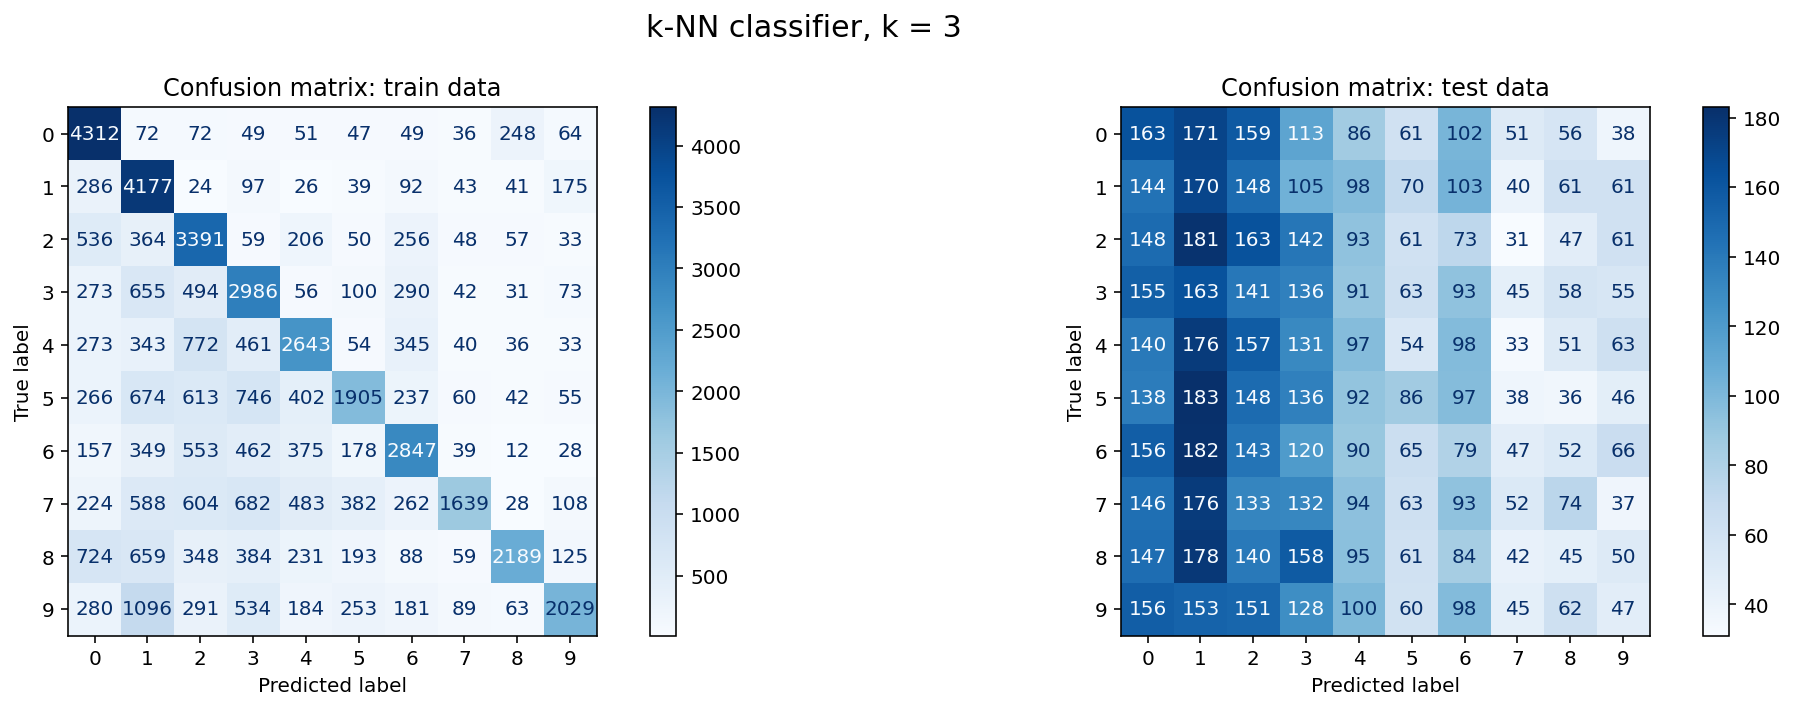

In [20]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_feature_vects, y_train)
knn_evaluate(knn)

########################################
Accuracy on train:  0.50016
Accuracy on test:  0.1023
########################################
Recall on train:  0.5001599999999999
Recall on test:  0.10229999999999999
########################################
Precision on train:  0.517988741213767
Precision on test:  0.10351629424394297
########################################


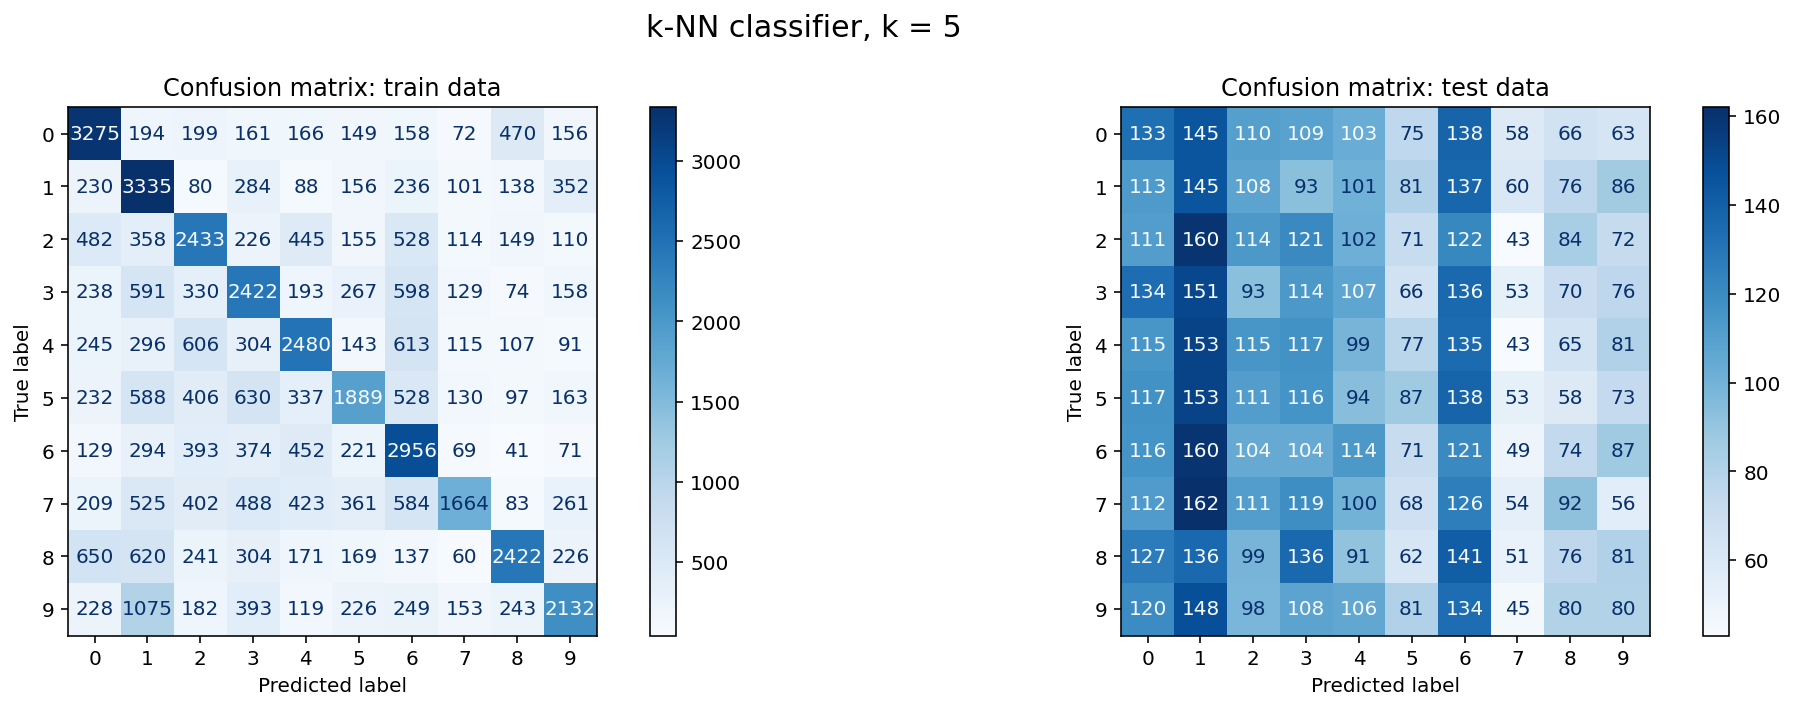

In [21]:
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_feature_vects, y_train)
knn_evaluate(knn)

Too simple features, proper classification and high accuracy score weren't even expected. We are going to try with more complex features (part 2: SIFT, proper determination of parameter k for kNN will also be done there).

We are aware that final performance  estimation  (accuracy and other metrics) shouldn't be done in this way and that cross-validation/hold-out methods should be employed. Due to the dataset's large size and the time-consuming feature extraction as well as classifier training especially in subsequent parts of this assignment (2. Scale Invariant Feature Transform - SIFT), we decided to work only with training/test split predefined by the dataset authors. It is noteworthy that the metrics provided are not considered as the final evaluation. Specifically, for this part here, we will perform a holdout evaluation.

In [41]:
from sklearn.model_selection import train_test_split 

def hold_out(k):
    N = 20
    accuracy_test = np.zeros(N)
    accuracy_train = np.zeros(N)
    for i in range(0, N):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=i, stratify=Y)
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_train_pred = knn.predict(X_train)
        y_test_pred = knn.predict(X_test)
        # accuracy
        accuracy_train[i] = accuracy_score(y_true=y_train, y_pred=y_train_pred)
        accuracy_test[i] = accuracy_score(y_true=y_test, y_pred=y_test_pred)
        
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, N+1, 1), accuracy_train, 'o-', color='royalblue', label='training set')
    plt.plot(np.arange(1, N+1, 1), accuracy_test, 'o-', color='darkblue', label='testing set')
    plt.legend()
    plt.title('Accuracy, holdout method, k-NN clasifier k = '+str(k))
    plt.ylabel('accuracy')

In [54]:
X = np.concatenate((X_train_feature_vects, X_test_feature_vects), axis=0)
Y = np.concatenate((y_train, y_test), axis=0)

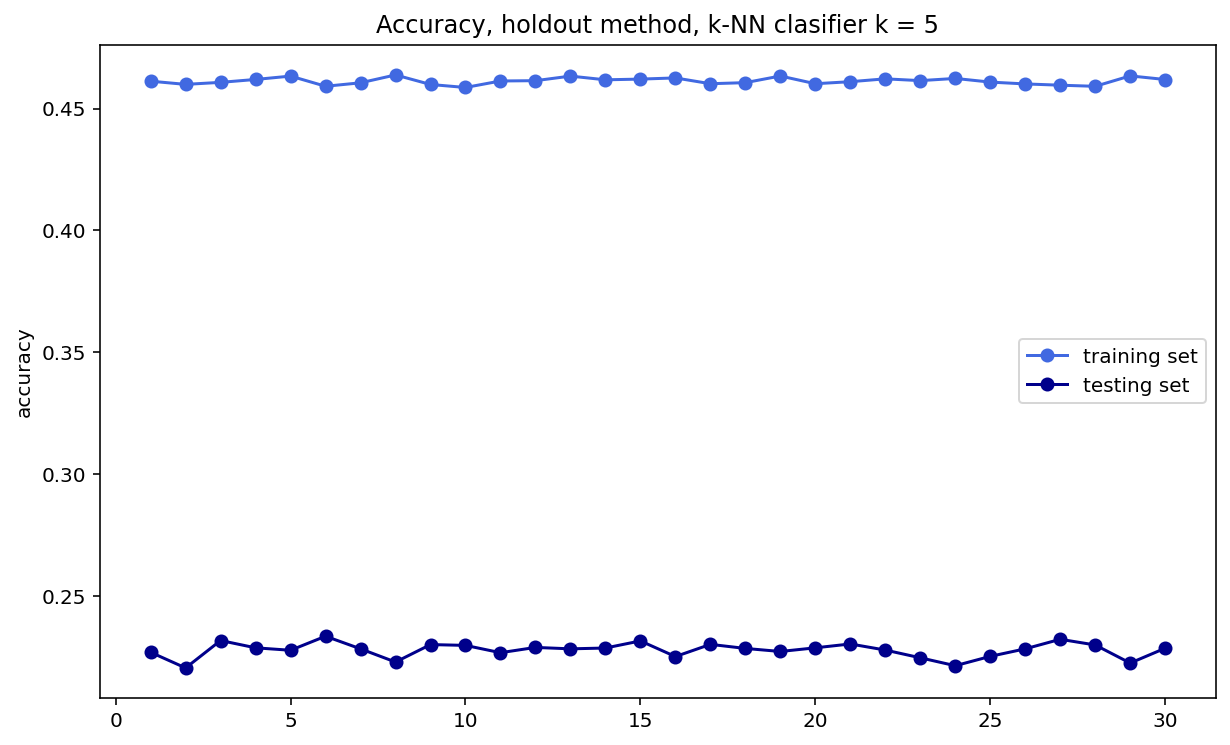

In [57]:
hold_out(k=5)

### One vs Rest - SVM
features: 1. concatenation of R, G, B colour histograms

In [16]:
def train_svm(X, Y, c):
    start_time = time.time()
    print("Starting training with model SVM...")
    svm_model = OneVsRestClassifier(SVC(kernel='linear', C=c)).fit(X,Y)
    print("Training completed!")
    print ("Time taken in training - {0}".format((time.time() - start_time)))
    return svm_model

In [17]:
def svm_evaluate(model):
    y_train_pred = model.predict(X_train_feature_vects)
    y_test_pred = model.predict(X_test_feature_vects)
    c = model.estimators_[0].C

    # accuracy
    print("#"*40)
    print("Accuracy on train: ", accuracy_score(y_true=y_train, y_pred=y_train_pred))
    print("Accuracy on test: ", accuracy_score(y_true=y_test, y_pred=y_test_pred))
    # recall
    print("#"*40)
    print("Recall on train: ", recall_score(y_true=y_train, y_pred=y_train_pred, average='macro'))
    print("Recall on test: ", recall_score(y_true=y_test, y_pred=y_test_pred, average = 'macro'))
    # precision
    print("#"*40)
    print("Precision on train: ", precision_score(y_true=y_train, y_pred=y_train_pred, average='macro'))
    print("Precision on test: ", precision_score(y_true=y_test, y_pred=y_test_pred, average='macro'))

    # plot confusion matrices
    print("#"*40)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    c_1 = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
    cmd_1 = ConfusionMatrixDisplay(c_1, display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    cmd_1.plot(ax=ax[0], cmap=plt.cm.Blues)
    ax[0].set_title("Confusion matrix: train data")

    c_2 = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
    cmd_2 = ConfusionMatrixDisplay(c_2, display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    cmd_2.plot(ax=ax[1], cmap=plt.cm.Blues)
    ax[1].set_title("Confusion matrix: test data")

    plt.tight_layout()
    plt.suptitle("SVM classifier, c = " + str(c), fontsize=15, ha='center')
    plt.subplots_adjust(top=0.85)

    plt.show()

Starting training with model SVM...
Training completed!
Time taken in training - 5736.820877313614
########################################
Accuracy on train:  0.21966
Accuracy on test:  0.1017
########################################
Recall on train:  0.21966000000000002
Recall on test:  0.10169999999999998
########################################
Precision on train:  0.2187088325048975
Precision on test:  0.10169274884788607
########################################


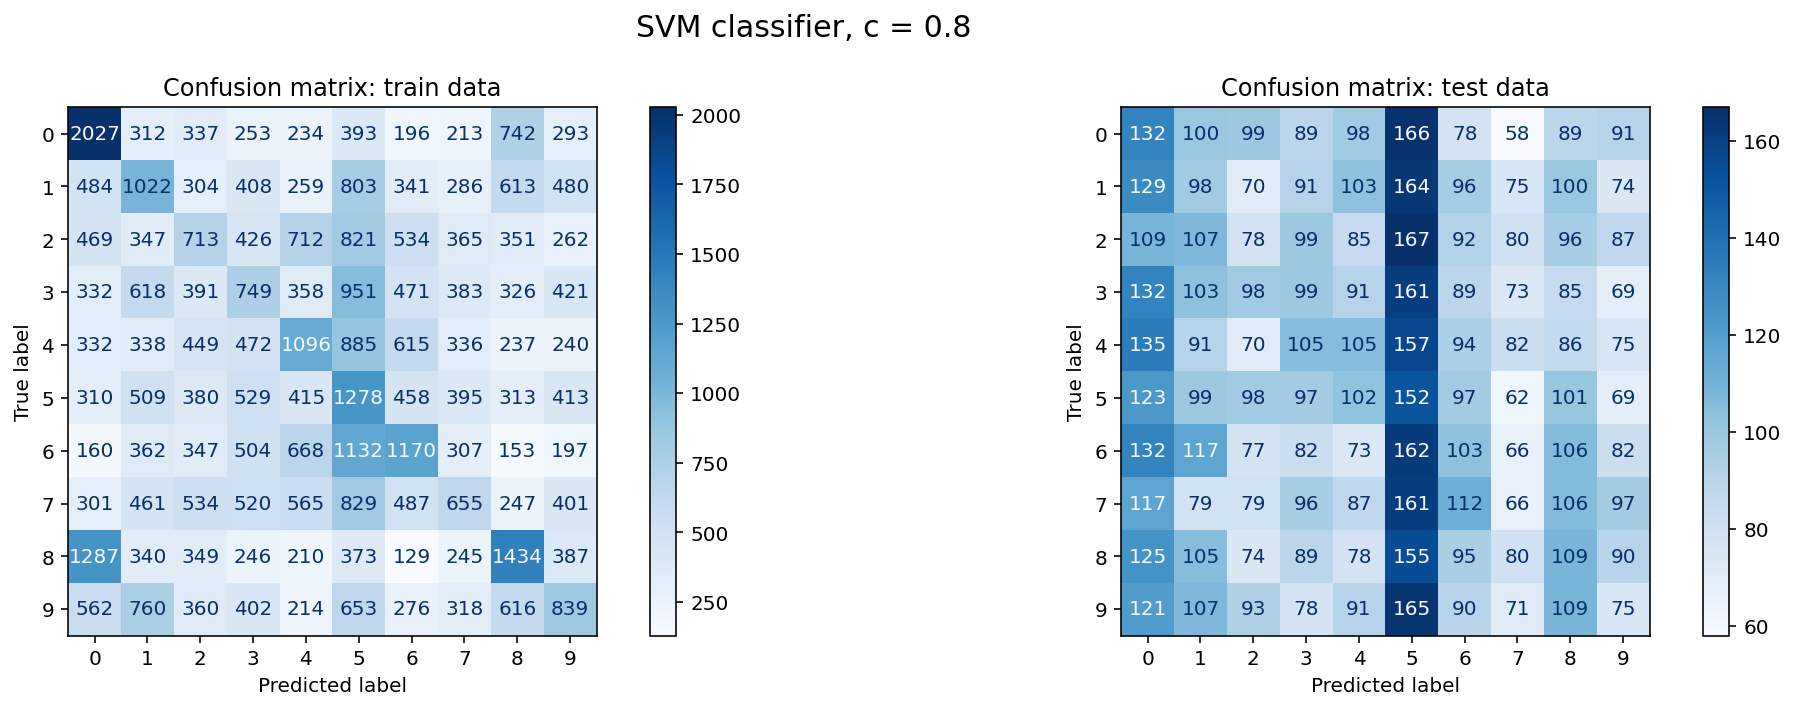

In [18]:
c = 0.8
svm_model = train_svm(X_train_feature_vects, y_train, c)
svm_evaluate(svm_model)
# 141 min 

### "Traditional" feature extraction methods: 1. colour histogram HSV

In [13]:
def calculate_histogram_hsv(index, num_bins=256):
    img = X_train[index]

    # convert RGB image to HSV color space
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # HSV color space
    h = img_hsv[:, :, 0]  # hue channel, shape: (32, 32)
    s = img_hsv[:, :, 1]  # saturation channel
    v = img_hsv[:, :, 2]  # value channel (corresponds to the light amount)

    # compute the histograms for all image channels
    hist_h, _ = np.histogram(h, bins=num_bins, range=(0, num_bins))
    hist_s, _ = np.histogram(s, bins=num_bins, range=(0, num_bins))
    hist_v, _ = np.histogram(v, bins=num_bins, range=(0, num_bins))

    # convert histograms to floating-point type before normalization
    hist_h = hist_h.astype(np.float32)
    hist_s = hist_s.astype(np.float32)
    hist_v = hist_v.astype(np.float32)

    hist_h /= hist_h.sum()
    hist_s /= hist_s.sum()
    hist_v /= hist_v.sum()

    return hist_h, hist_s, hist_v

In [14]:
def plot_hsv(h_hist, s_hist, v_hist, index):
    img = X_train[index]
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

    ax[0, 0].imshow(img); ax[0, 0].set_xticks([]); ax[0, 0].set_yticks([]); ax[0, 0].set_title('RGB image')
    ax[0, 1].imshow(img); ax[0, 1].set_xticks([]); ax[0, 1].set_yticks([]); ax[0, 1].set_title('RGB image')
    ax[0, 2].imshow(img); ax[0, 2].set_xticks([]); ax[0, 2].set_yticks([]); ax[0, 2].set_title('RGB image')

    ax[1, 0].plot(h_hist, 'darkblue'); ax[1, 0].set_xlim([0, len(h_hist)]); ax[1, 0].set_title('H histogram'); ax[1, 0].set_xlabel('bins'); ax[1, 0].set_ylabel('normalized frequency')
    ax[1, 1].plot(s_hist, 'darkblue'); ax[1, 1].set_xlim([0, len(s_hist)]); ax[1, 1].set_title('S histogram'); ax[1, 1].set_xlabel('bins'); ax[1, 1].set_ylabel('normalized frequency')
    ax[1, 2].plot(v_hist, 'darkblue'); ax[1, 2].set_xlim([0, len(v_hist)]); ax[1, 2].set_title('V histogram'); ax[1, 2].set_xlabel('bins'); ax[1, 2].set_ylabel('normalized frequency')

    ax[2, 0].imshow(img_hsv[:, :, 0], cmap='jet'); ax[2, 0].set_xticks([]); ax[2, 0].set_yticks([]); ax[2, 0].set_title('H channel matrix')
    ax[2, 1].imshow(img_hsv[:, :, 1], cmap='jet'); ax[2, 1].set_xticks([]); ax[2, 1].set_yticks([]); ax[2, 1].set_title('S channel matrix')
    ax[2, 2].imshow(img_hsv[:, :, 2], cmap='gray'); ax[2, 2].set_xticks([]); ax[2, 2].set_yticks([]); ax[2, 2].set_title('V channel matrix')

    plt.show()

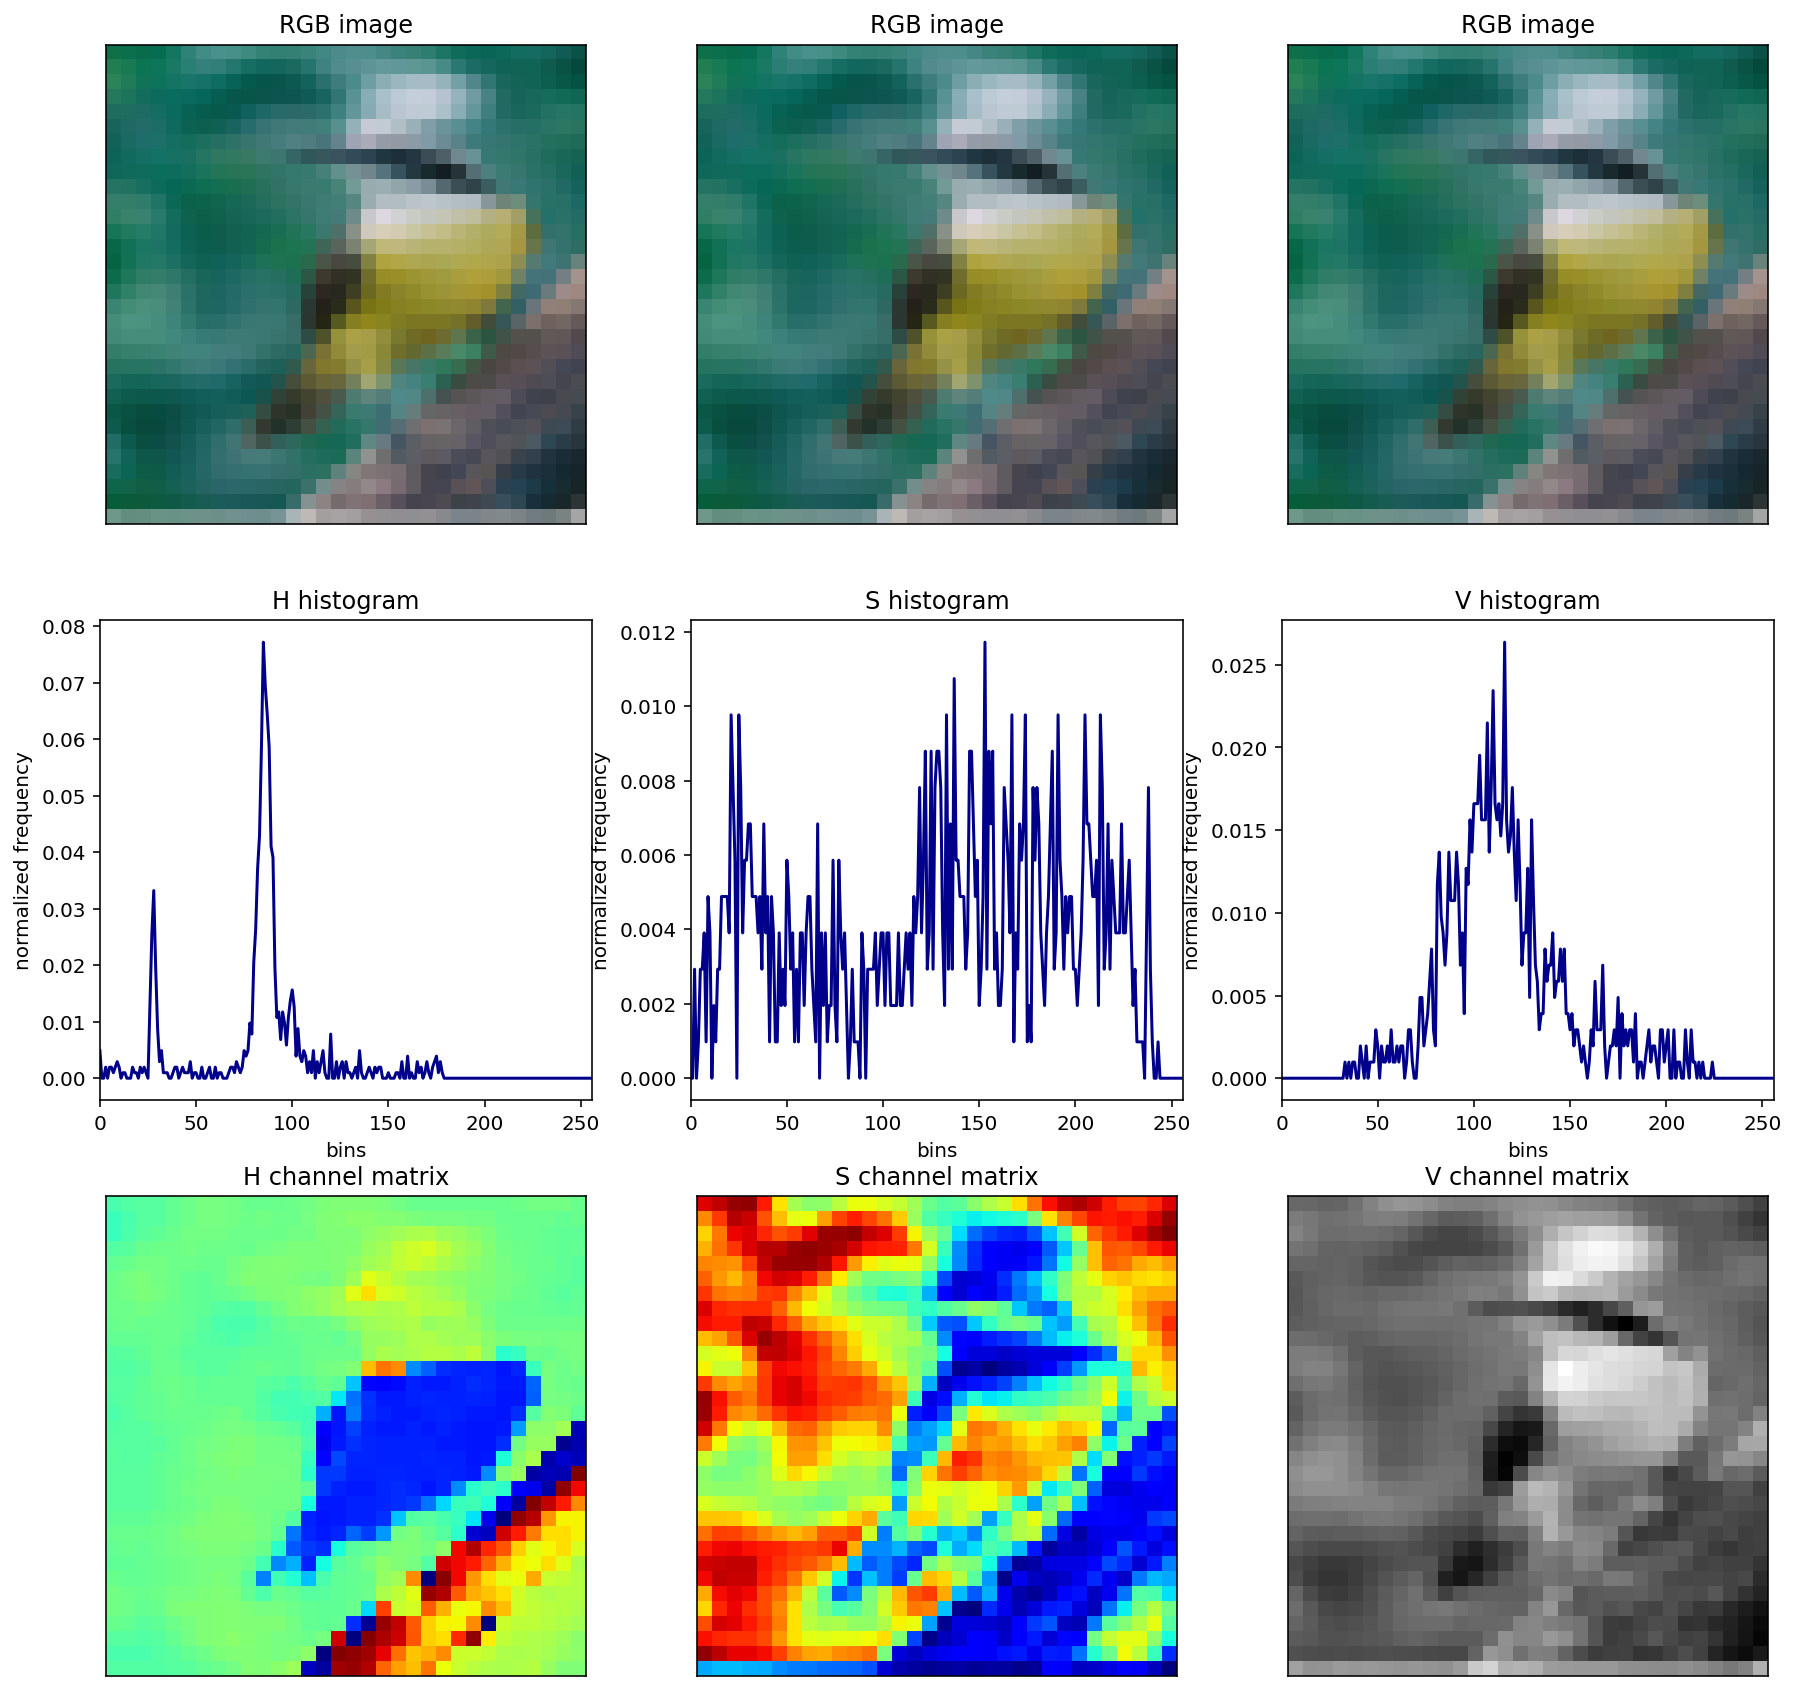

In [25]:
h_hist, s_hist, v_hist = calculate_histogram_hsv(index=27001)
plot_hsv(h_hist, s_hist, v_hist, index=27001)

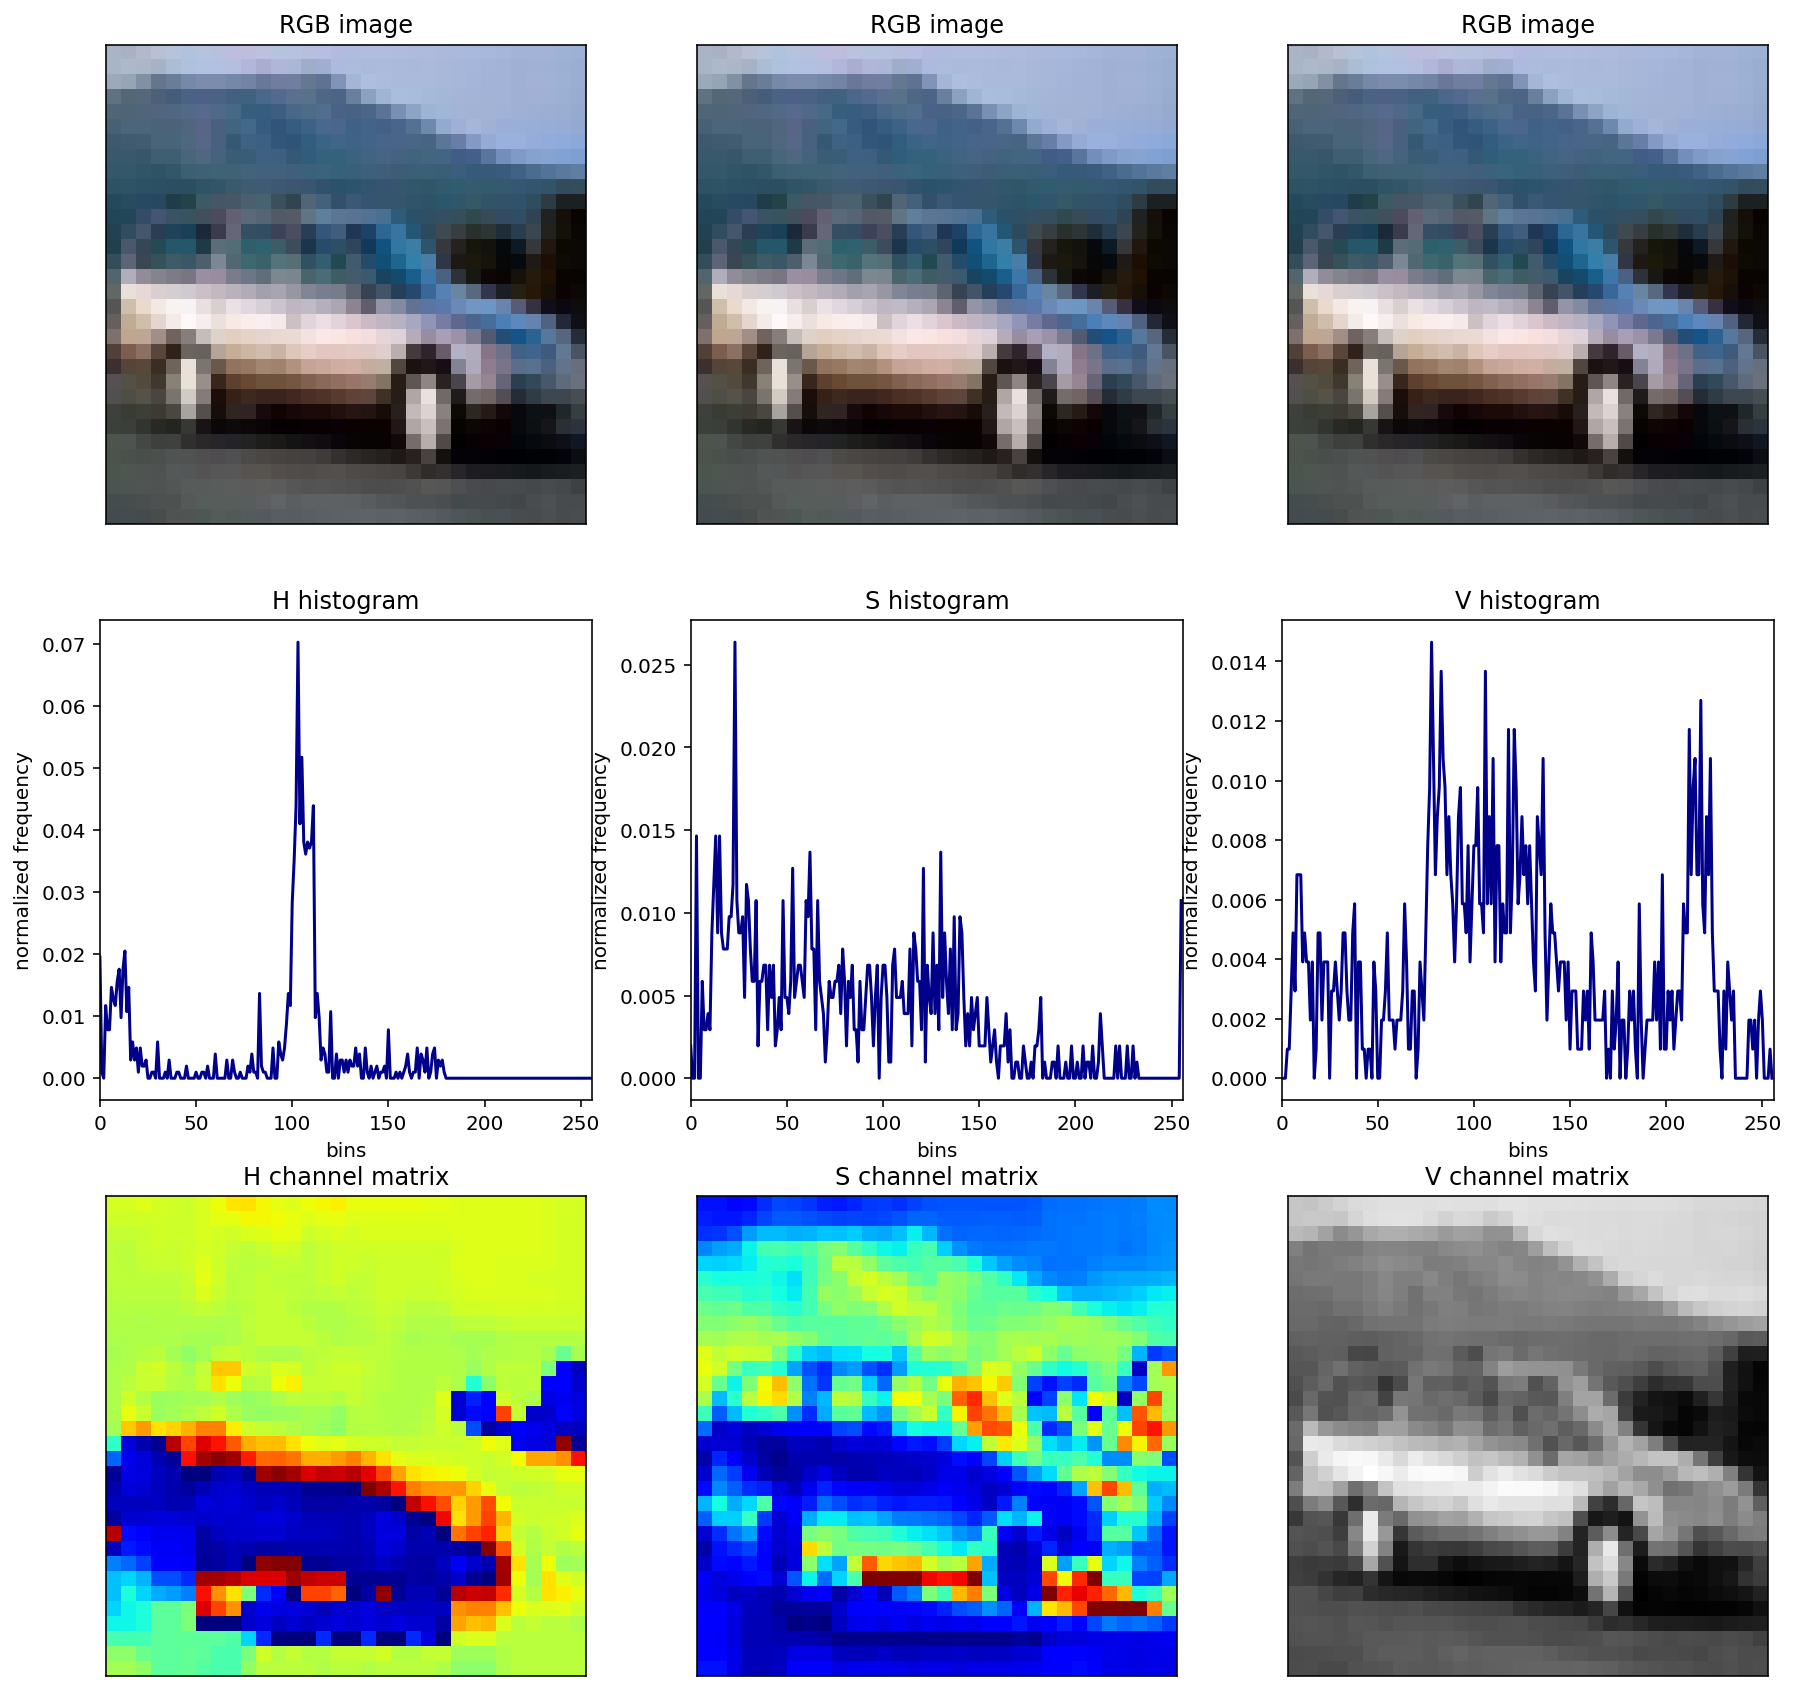

In [26]:
h_hist, s_hist, v_hist = calculate_histogram_hsv(index=4)
plot_hsv(h_hist, s_hist, v_hist, index=4)

### k-NN classifier 
features: 1. concatenation of H, S, V colour histograms

In [20]:
start_time = time.time()
num_samples = X_train.shape[0]
X_train_feature_vects = np.zeros([num_samples, 3*256])
for i in range(0, num_samples): 
    h_hist, s_hist, v_hist = calculate_histogram_hsv(index=i)
    X_train_feature_vects[i, :] = np.concatenate((h_hist, s_hist, v_hist))
print("Time needed for feature extraction on the whole training dataset:", time.time() - start_time)

Time needed for feature extraction on the whole training dataset: 12.040368556976318


In [21]:
start_time = time.time()
num_samples = X_test.shape[0]
X_test_feature_vects = np.zeros([num_samples, 3*256])
for i in range(0, num_samples): 
    h_hist, s_hist, v_hist = calculate_histogram_hsv(index=i)
    X_test_feature_vects[i, :] = np.concatenate((h_hist, s_hist, v_hist))
print("Time needed for feature extraction on the whole testing dataset:", time.time() - start_time)

Time needed for feature extraction on the whole testing dataset: 2.49153995513916


########################################
Accuracy on train:  0.59248
Accuracy on test:  0.0985
########################################
Recall on train:  0.59248
Recall on test:  0.0985
########################################
Precision on train:  0.6294055587777883
Precision on test:  0.0998250568989568
########################################


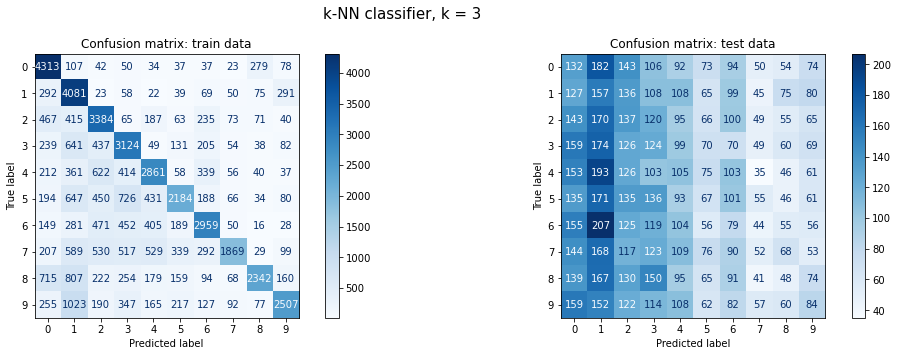

In [22]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_feature_vects, y_train)
knn_evaluate(knn)

########################################
Accuracy on train:  0.52168
Accuracy on test:  0.0988
########################################
Recall on train:  0.5216799999999999
Recall on test:  0.09879999999999999
########################################
Precision on train:  0.5352135571422882
Precision on test:  0.10041383010253128
########################################


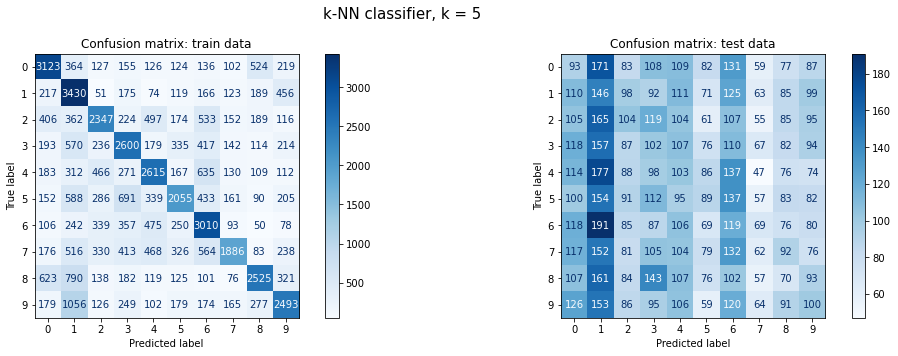

In [23]:
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_feature_vects, y_train)
knn_evaluate(knn)

features: only V colour histograms (informatin about brightness)

In [25]:
start_time = time.time()
num_samples = X_train.shape[0]
X_train_feature_vects = np.zeros([num_samples, 256])
for i in range(0, num_samples): 
    _, _, v_hist = calculate_histogram_hsv(index=i)
    X_train_feature_vects[i, :] = v_hist
print("Time needed for feature extraction on the whole training dataset:", time.time() - start_time)

Time needed for feature extraction on the whole training dataset: 11.710521697998047


In [26]:
start_time = time.time()
num_samples = X_test.shape[0]
X_test_feature_vects = np.zeros([num_samples, 256])
for i in range(0, num_samples): 
    _, _, v_hist = calculate_histogram_hsv(index=i)
    X_test_feature_vects[i, :] = v_hist
print("Time needed for feature extraction on the whole testing dataset:", time.time() - start_time)

Time needed for feature extraction on the whole testing dataset: 2.3372678756713867


########################################
Accuracy on train:  0.51138
Accuracy on test:  0.0986
########################################
Recall on train:  0.5113800000000001
Recall on test:  0.09860000000000001
########################################
Precision on train:  0.5647948110183899
Precision on test:  0.09872645127867685
########################################


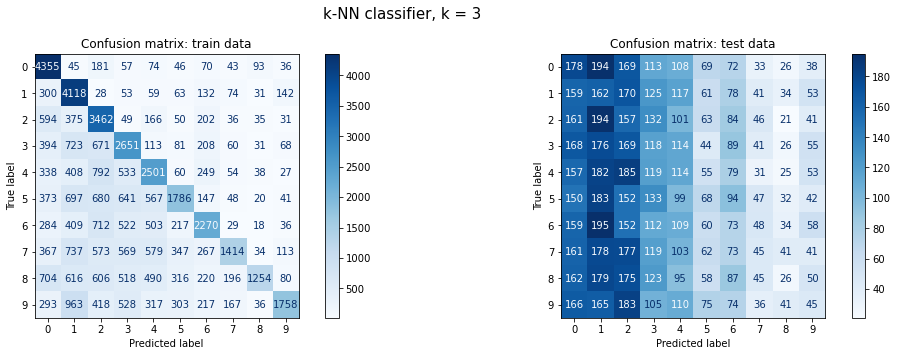

In [27]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_feature_vects, y_train)
knn_evaluate(knn)

Using only V histograms resulted in similar performance (not considerably downgraded).

### "Traditional" feature extraction methods: 1. Sobel filter

In [27]:
def sobel_filter(index):
    img = X_train[index]

    # convert the RGB image to grayscale
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # apply Sobel filter to compute gradients along x and y directions
    sobel_x = cv2.Sobel(gray_image, cv2.CV_64F, dx=1, dy=0, ksize=3) # gradient along x axis (horizontal) -> vertical edges
    sobel_y = cv2.Sobel(gray_image, cv2.CV_64F, dx=0, dy=1, ksize=3) # gradient along y axis (vertical) -> horizontal edges

    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2) # gradient magnitude
    gradient_magnitude /= gradient_magnitude.max() # normalize gradient magnitude to [0,1]

    feature_vector = gradient_magnitude.flatten()

    return sobel_x, sobel_y, gradient_magnitude, feature_vector

In [28]:
def plot_sobel(sobel_x, sobel_y, gradient_magnitude, index):
    img = X_train[index]
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

    ax[0, 0].imshow(img, cmap='jet'); ax[0, 0].set_xticks([]); ax[0, 0].set_yticks([]); ax[0, 0].set_title('RGB image')
    ax[0, 1].imshow(gray_image, cmap='gray'); ax[0, 1].set_xticks([]); ax[0, 1].set_yticks([]); ax[0, 1].set_title('Grayscale image')
    ax[0, 2].imshow(gradient_magnitude, cmap='gray'); ax[0, 2].set_xticks([]); ax[0, 2].set_yticks([]); ax[0, 2].set_title('Edges (applied Sobel filter)')

    ax[1, 0].imshow(sobel_x, cmap='gray'); ax[1, 0].set_xticks([]); ax[1, 0].set_yticks([]); ax[1, 0].set_title('Horizontal gradient -> vertical edges')
    ax[1, 1].imshow(sobel_y, cmap='gray'); ax[1, 1].set_xticks([]); ax[1, 1].set_yticks([]); ax[1, 1].set_title('Vertical gradient -> horizontal edges')    
    ax[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


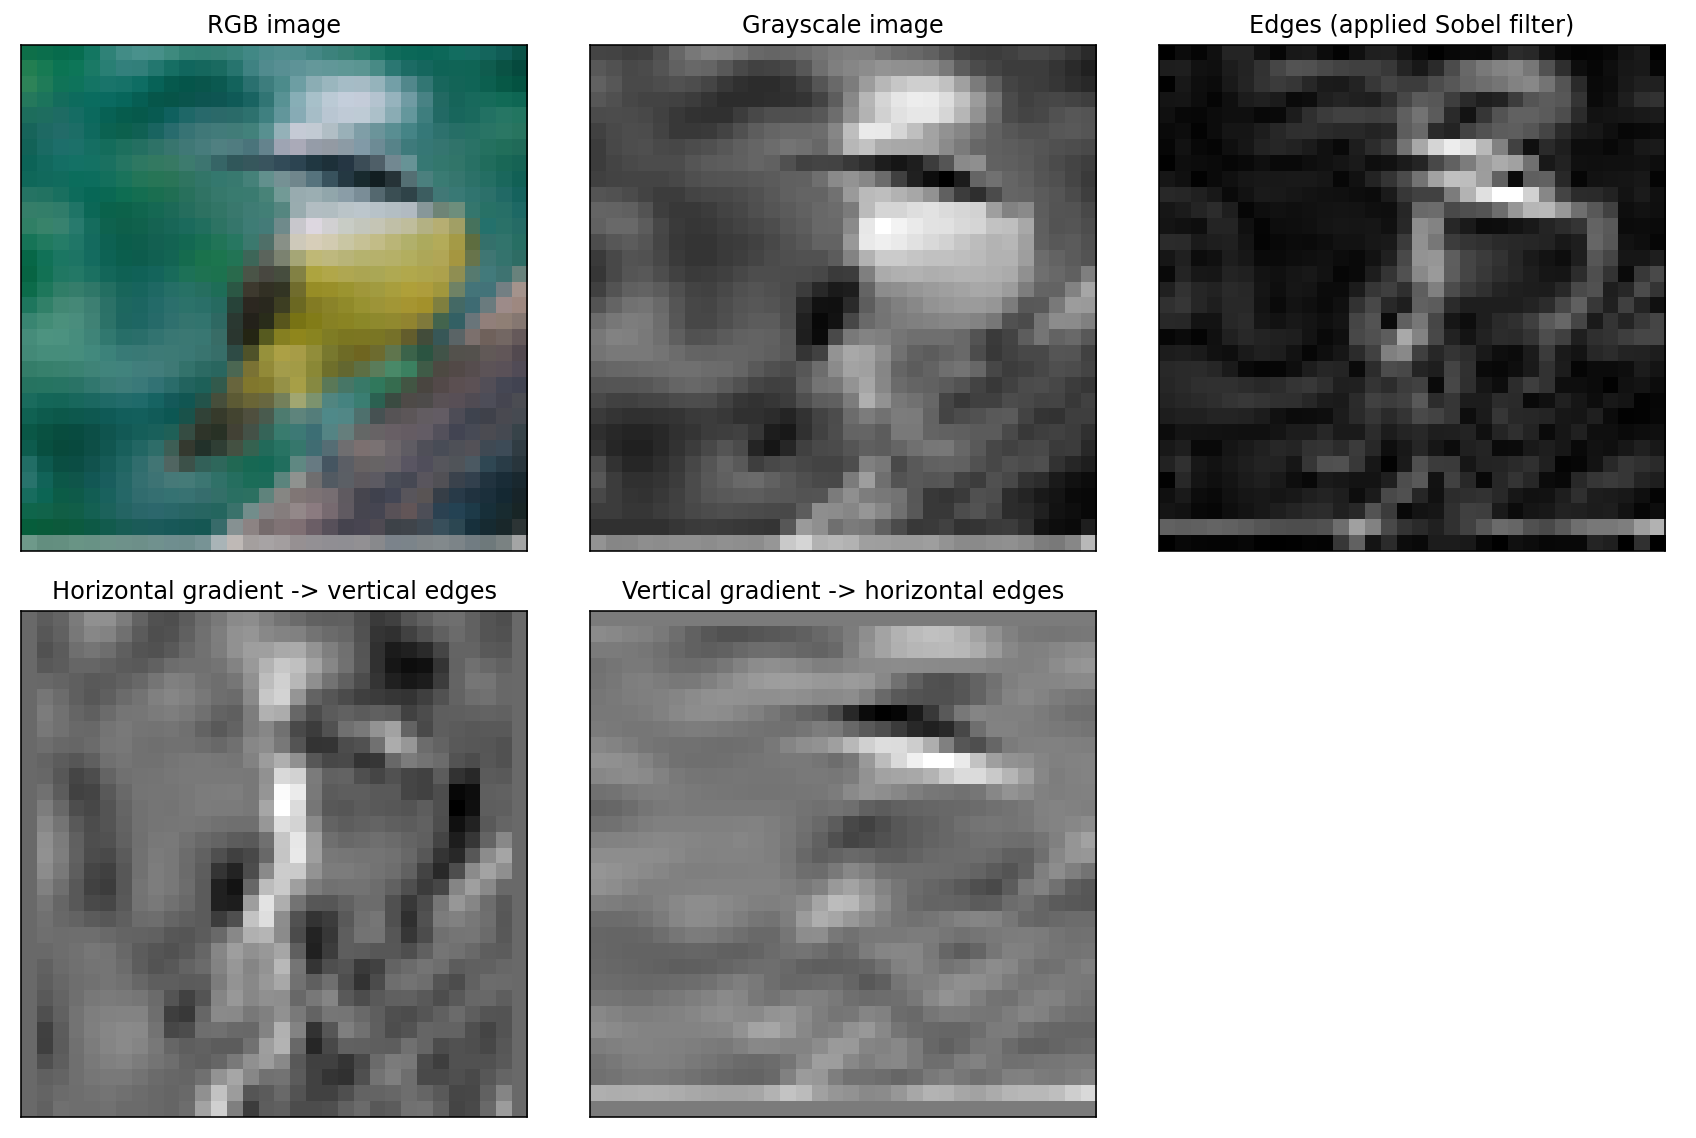

In [29]:
sobel_x, sobel_y, gradient_magnitude, feature_vector = sobel_filter(index=27001)
plot_sobel(sobel_x, sobel_y, gradient_magnitude, index=27001)

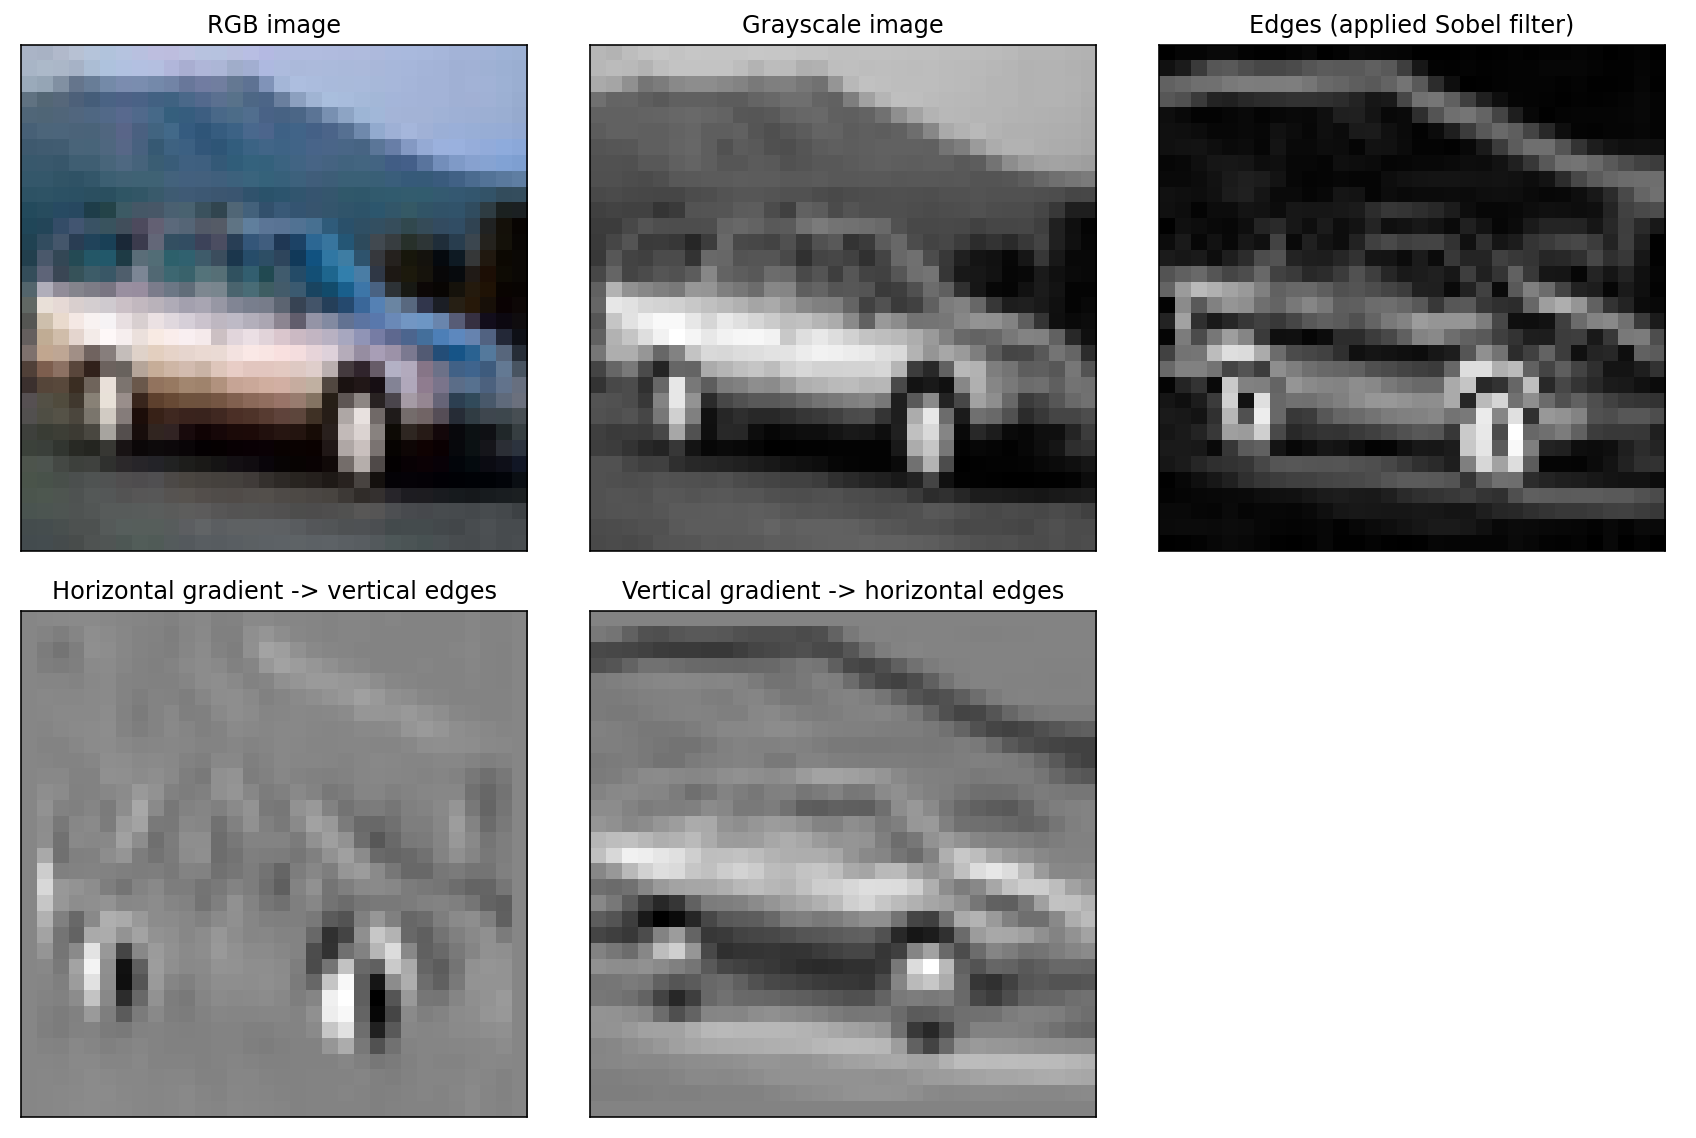

In [30]:
sobel_x, sobel_y, gradient_magnitude, feature_vector = sobel_filter(index=4)
plot_sobel(sobel_x, sobel_y, gradient_magnitude, index=4)

### k-NN classifier 
features: 1. flattened image after applying Sobel filter

In [31]:
start_time = time.time()
num_samples = X_train.shape[0]
X_train_feature_vects = np.zeros([num_samples, 32*32])
for i in range(0, num_samples): 
    _, _, _, feature_vector = sobel_filter(index=i)
    X_train_feature_vects[i, :] = feature_vector
print("Time needed for feature extraction on the whole training dataset:", time.time() - start_time)

Time needed for feature extraction on the whole training dataset: 2.064108371734619


In [32]:
start_time = time.time()
num_samples = X_test.shape[0]
X_test_feature_vects = np.zeros([num_samples, 32*32])
for i in range(0, num_samples): 
    _, _, _, feature_vector = sobel_filter(index=i)
    X_test_feature_vects[i, :] = feature_vector
print("Time needed for feature extraction on the whole training dataset:", time.time() - start_time)

Time needed for feature extraction on the whole training dataset: 0.43402576446533203


########################################
Accuracy on train:  0.5768
Accuracy on test:  0.105
########################################
Recall on train:  0.5767999999999999
Recall on test:  0.10499999999999998
########################################
Precision on train:  0.6563046781082378
Precision on test:  0.10221433323934388
########################################


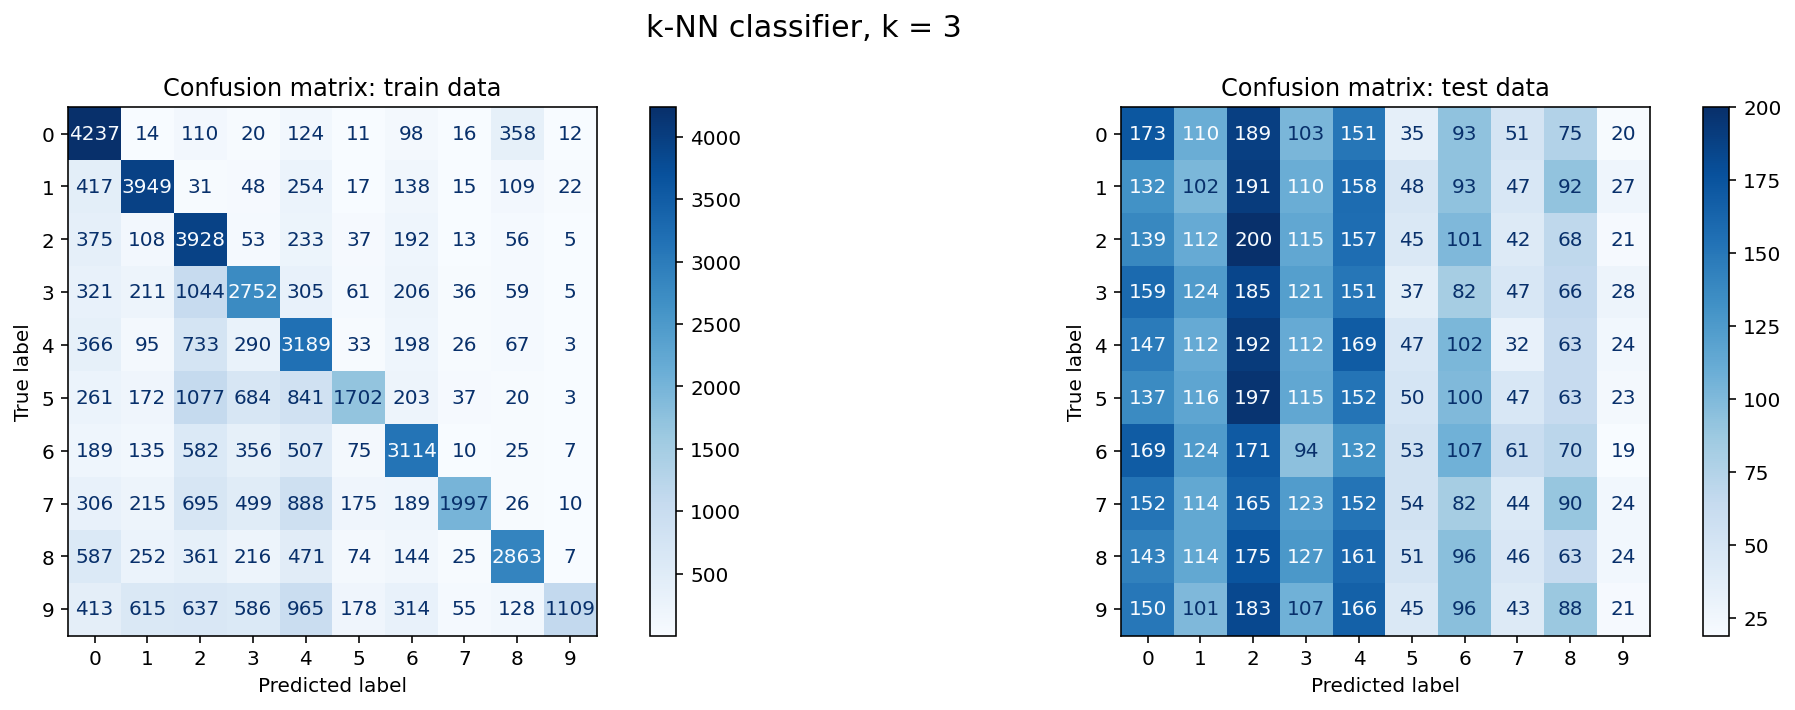

In [35]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_feature_vects, y_train)
knn_evaluate(knn)

### "Traditional" feature extraction methods: 2. Scale Invariant Feature Transform - SIFT

https://github.com/deepanshut041/feature-detection/blob/master/sift/sift.ipynb


SIFT is an algorithm that identifies keypoints and computes their corresponding descriptors. Keypoints represent points of interest in an image, and descriptors capture the local features by extracting small, fixed-size (128) patches (converted into vectors) around each keypoint, describing the surrounding area.

In [13]:
def sift(index):
    
    plt.imshow(X_train[index])
    plt.title("Initial image")
    plt.show()
    training_image  = X_train[index]
    
    #  converting image to RGB
    training_image = cv2.cvtColor(training_image, cv2.COLOR_BGR2RGB)
    # converting to gray scale
    training_image_gray = cv2.cvtColor(training_image,cv2.COLOR_RGB2GRAY)

    # detecting keypoints
    sift = cv2.SIFT_create()
    train_keypoints, train_descriptor = sift.detectAndCompute(training_image_gray, None)
    keypoints_without_size = np.copy(training_image)
    keypoints_with_size = np.copy(training_image)

    cv2.drawKeypoints(training_image, train_keypoints, keypoints_without_size, color = (0, 255, 0))
    cv2.drawKeypoints(training_image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Display image with and without keypoints size
    fx, plots = plt.subplots(1, 2, figsize=(5,5))

    plots[0].set_title("Train keypoints With Size")
    plots[0].imshow(keypoints_with_size, cmap='gray')

    plots[1].set_title("Train keypoints Without Size")
    plots[1].imshow(keypoints_without_size, cmap='gray')

    # Print the number of keypoints detected in the training image
    print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))
    # print(train_keypoints)
    # print(train_descriptor)
    # print(train_descriptor.shape)



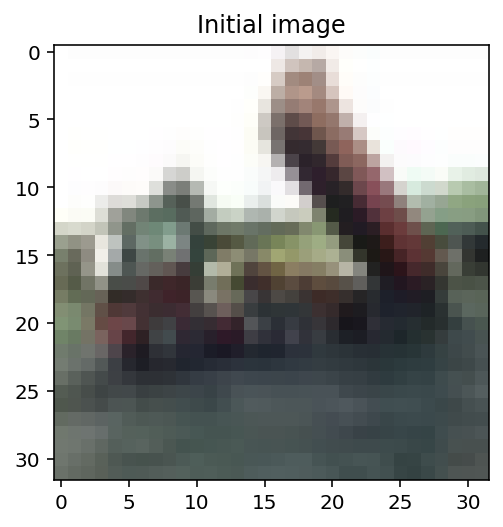

Number of Keypoints Detected In The Training Image:  13


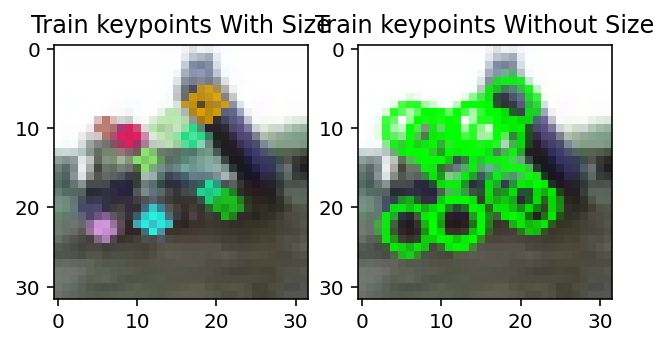

In [32]:
sift(2)

## COULD BE HELPFUL FOR BAG OF WORDS & BASELINE

https://github.com/shubpate/bag_of_visual_words/blob/master/bag_of_SIFT_features_KNN_SVM_training.py


In [423]:
# def formatND(l):
#         print ("Stacking begins ..")
#         vStack = np.array(l[0])
#         for remaining in l[1:]:
#             vStack = np.vstack((vStack, remaining))
#         print ("Stacking done")
#         return vStack

In [426]:
# def create_des_list(X):
#     sift = cv2.SIFT()
#     des_list = []
#     for image in X:
#         kp, des = sift.detectAndCompute(image,None)
#         des_list.append(des)
#     return np.array(des_list)

####  THIS LINK SEEMS TO DO WHAT WE ARE TRYING TO ACHIEVE I BELIEVE
https://github.com/shubpate/bag_of_visual_words/blob/master/bag_of_SIFT_features_KNN_SVM_training.py

In [14]:
def create_descriptor_list(subset):
    X_train_subset = X_train[:subset]
    sift = cv2.SIFT()
    list_of_all_descriptors = []

    for i in range(0, subset):
        img = X_train_subset[i]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # converting image to RGB (not necessary since it's already in RGB)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # converting to gray scale

        # detecting keypoints
        sift = cv2.SIFT_create()
        train_keypoints, train_descriptor = sift.detectAndCompute(img, None)

        list_of_all_descriptors.append(train_descriptor)  

    return list_of_all_descriptors

In [15]:
def develop_vocabulary_try(n_images, descriptor_list, no_clusters, kmeans_ret):
 
    mega_histogram = np.array([np.zeros(no_clusters) for _ in range(n_images)])  # #n_images x #no_clusters
    old_count = 0
    for i in range(n_images):
        l = len(descriptor_list[i])
        for j in range(l):
            idx = kmeans_ret[old_count+j]
            mega_histogram[i][idx] += 1
        old_count += l
    print ("Vocabulary Histogram Generated")

    return mega_histogram

In [16]:
def format_vocab(l):
    # 

    print ("Stacking begins ..")
    vStack = np.array(l[0])
    for remaining in l[1:]:
        vStack = np.vstack((vStack, remaining))
    print ("Stacking done")

    return vStack

In [431]:
no_clusters = 10
list_of_all_descriptors = create_descriptor_list(subset=4)
des_stack = format_vocab(list_of_all_descriptors) 

start_time = time.time()
print("Starting with clustering...")
kmeans_obj = KMeans( no_clusters)
kmeans_ret = kmeans_obj.fit_predict(des_stack)
print("Clustering completed!")
print("Time taken : ",time.time() - start_time )

Stacking begins ..
Stacking done
Starting with clustering...
Clustering completed!
Time taken :  0.06025505065917969


/Users/nadia/Desktop/TUSS23/ML/MachineLearningEx3/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [438]:
mega_histogram = develop_vocabulary_try(4, list_of_all_descriptors,10,kmeans_ret)

Vocabulary Histogram Generated


### Bag of Visual Words Model for Image Classification
https://kushalvyas.github.io/BOV.html

1. keypoint detection and feature extraction 

Keypoints could be detected using SIFT algorithm. Once keypoints are identified, local features -  descriptors are extracted around each keypoint. These descriptors encode the information about the visual characteristics of the image region around the keypoint. Therefore each image from the training dataset is now represented as a set of descriptors. SIFT returns m x 128 dimension array (m - number of keypoints).


2. building a visual vocabulary

Firstly, we group all the descriptors (obtained from all the images from the training dataset) into predefined number of clusters (using K-means algorithm, reason: information compression and grouping similar features). The K centroids ("visual words") obtained from the clustering process together form the visual vocabulary. This vocabulary represents the distinctive local patterns found in the dataset.


3. assign visual words to image descriptors

For each image in the training dataset, the descriptors are again extracted, and each descriptor is assigned to the closest visual word (centroid) from the visual vocabulary. This assignment is done using distance metrics like Euclidean distance or cosine similarity.

4. histogram creation

The image is represented as a histogram, where each bin of the histogram corresponds to a visual word from the vocabulary. The value of each bin represents the frequency of occurrence of the corresponding visual word in the image. In other words, the histogram counts how many times each visual word appears in the image.

5. train a classifier

Once the images are represented as histograms of visual words, a classifier is trained on these histogram representations. The classifier learns to differentiate between different image categories based on the frequency distribution of visual words.

6. image classification

In [14]:
from sklearn.cluster import KMeans
import time

def generate_vocabulary(n_images, no_clusters):

    # list_of_all_descriptors: list of numpy arrays such that each element of the list - 2D numpy array 
    # corresponds to descriptors of the one training image
    # descriptor matrix of one image: (#keypoints x 128)

    print("SIFT feature extraction begins...")
    start_time = time.time()
    X_train_subset = X_train[:n_images]
    sift = cv2.SIFT()
    list_of_all_descriptors = []

    for i in range(0, n_images):
        img = X_train_subset[i]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # converting image to RGB (not necessary since it's already in RGB)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # converting to gray scale

        # detecting keypoints
        sift = cv2.SIFT_create()
        train_keypoints, train_descriptor = sift.detectAndCompute(img, None)
        list_of_all_descriptors.append(train_descriptor)  

    print("Time taken for SIFT feature extraction:", time.time() - start_time)

    # converting into 2D numpy array (vertical stacking of the list elements): mat_of_all_descriptors

    print ("Stacking begins...")
    mat_of_all_descriptors = np.array(list_of_all_descriptors[0])
    for remaining in list_of_all_descriptors[1:]:
        if remaining is not None:                   
            # it can happen that SIFT detector doesn't detect any keypoints -> exclude empty lists
            mat_of_all_descriptors = np.vstack((mat_of_all_descriptors, remaining))
    print ("Stacking done")

    # perform clustering: K-means algorithm

    start_time = time.time()
    print("Starting with clustering...")
    kmeans_obj = KMeans(no_clusters)
    kmeans_ret = kmeans_obj.fit_predict(mat_of_all_descriptors) # fitting the model: class label assigned to each descriptor
    # centroids = kmeans_obj.cluster_centers_
    print("Clustering completed!")
    print("Time taken for clustering:", time.time() - start_time)

    return list_of_all_descriptors, kmeans_obj

In [18]:
list_of_all_descriptors, kmeans_obj = generate_vocabulary(n_images=100, no_clusters=15)

SIFT feature extraction begins...
Time taken for SIFT feature extraction: 0.12572216987609863
Stacking begins...
Stacking done
Starting with clustering...


/Users/nadia/Desktop/TUSS23/ML/MachineLearningEx3/venv/lib/python3.9/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(


Clustering completed!
Time taken for clustering: 0.31241416931152344


In [15]:
def histogram_creation(descriptor_list, kmeans_obj):

    n_images = len(descriptor_list)
    kmeans_ret = kmeans_obj.labels_
    no_clusters = len(kmeans_obj.cluster_centers_)


    mega_histogram = np.array([np.zeros(no_clusters) for _ in range(n_images)])  # #n_images x #no_clusters
    old_count = 0
    for i in range(n_images):
        if descriptor_list[i] is None:
            continue 
        l = len(descriptor_list[i])
        for j in range(l):
            idx = kmeans_ret[old_count+j]
            mega_histogram[i][idx] += 1
        old_count += l
    print ("Vocabulary Histogram Generated")

    return mega_histogram

In [20]:
mega_histogram = histogram_creation(descriptor_list=list_of_all_descriptors, kmeans_obj=kmeans_obj)

Vocabulary Histogram Generated


In [37]:
mega_histogram.shape

(100, 15)

### Histogram: results inspection

In [20]:
n_images = 1000
no_clusters = 15
list_of_all_descriptors, kmeans_obj = generate_vocabulary(n_images=n_images, no_clusters=no_clusters)
mega_histogram = histogram_creation(descriptor_list=list_of_all_descriptors, kmeans_obj=kmeans_obj)

SIFT feature extraction begins...
Time taken for SIFT feature extraction: 0.9968218803405762
Stacking begins...
Stacking done
Starting with clustering...


c:\Users\sofij\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Clustering completed!
Time taken for clustering: 2.015587568283081
Vocabulary Histogram Generated


In [16]:
def plot_bowv_histogram(axis, img_idx):
    class_label = y_train[img_idx]
    x_labels = np.arange(0, no_clusters)
    data = mega_histogram[img_idx, :]

    axis.bar(x_labels, data)
    axis.set_xlabel("visual word index")
    axis.set_ylabel("frequency")
    axis.set_title(f"Histogram of image: {img_idx}, class label: {class_label}")

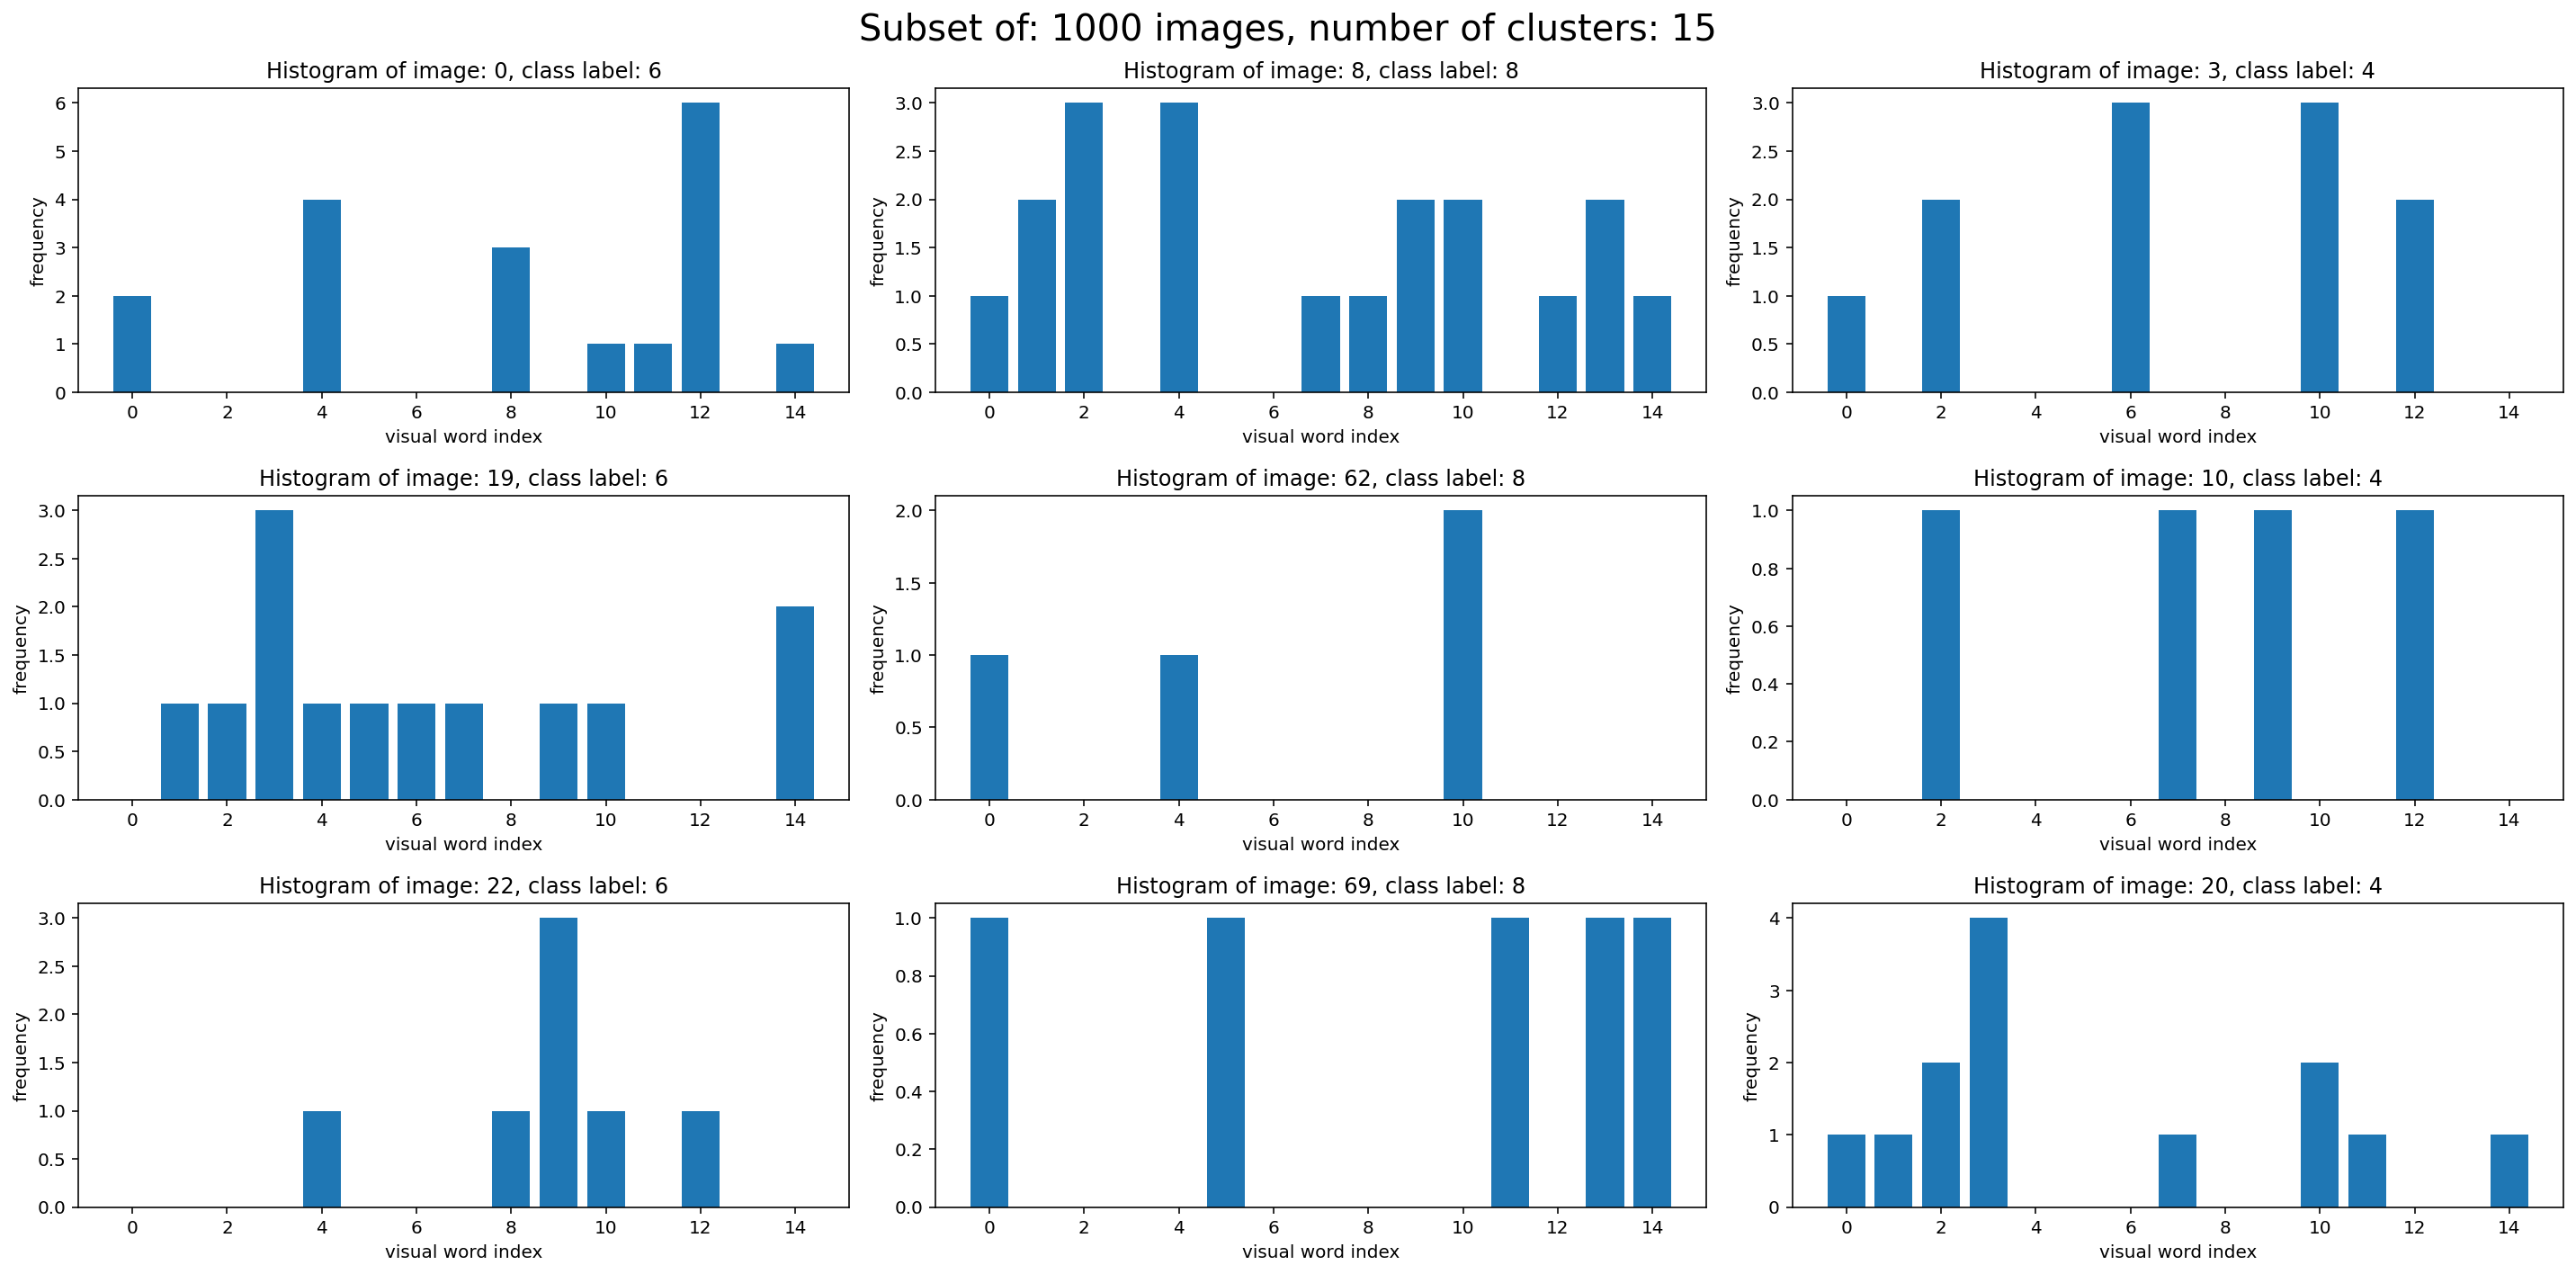

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))

indices_6 = np.where(y_train == 6)[0][:3]  # first 3 images belonging to class 6
for i, img_idx in enumerate(indices_6):
    plot_bowv_histogram(ax[i, 0], img_idx)

indices_8 = np.where(y_train == 8)[0][:3]  # first 3 images belonging to class 8
for i, img_idx in enumerate(indices_8):
    plot_bowv_histogram(ax[i, 1], img_idx)

indices_4 = np.where(y_train == 4)[0][:3]  # first 3 images belonging to class 4
for i, img_idx in enumerate(indices_4):
    plot_bowv_histogram(ax[i, 2], img_idx)

plt.suptitle(f"Subset of: {n_images} images, number of clusters: {no_clusters}", fontsize=20)

plt.tight_layout()
plt.show()


In [24]:
n_images = len(X_test) # whole dataset
no_clusters = 15
list_of_all_descriptors, kmeans_obj = generate_vocabulary(n_images=n_images, no_clusters=no_clusters)
mega_histogram = histogram_creation(descriptor_list=list_of_all_descriptors, kmeans_obj=kmeans_obj)

SIFT feature extraction begins...
Time taken for SIFT feature extraction: 8.619746446609497
Stacking begins...
Stacking done
Starting with clustering...


c:\Users\sofij\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Clustering completed!
Time taken for clustering: 18.78606867790222
Vocabulary Histogram Generated


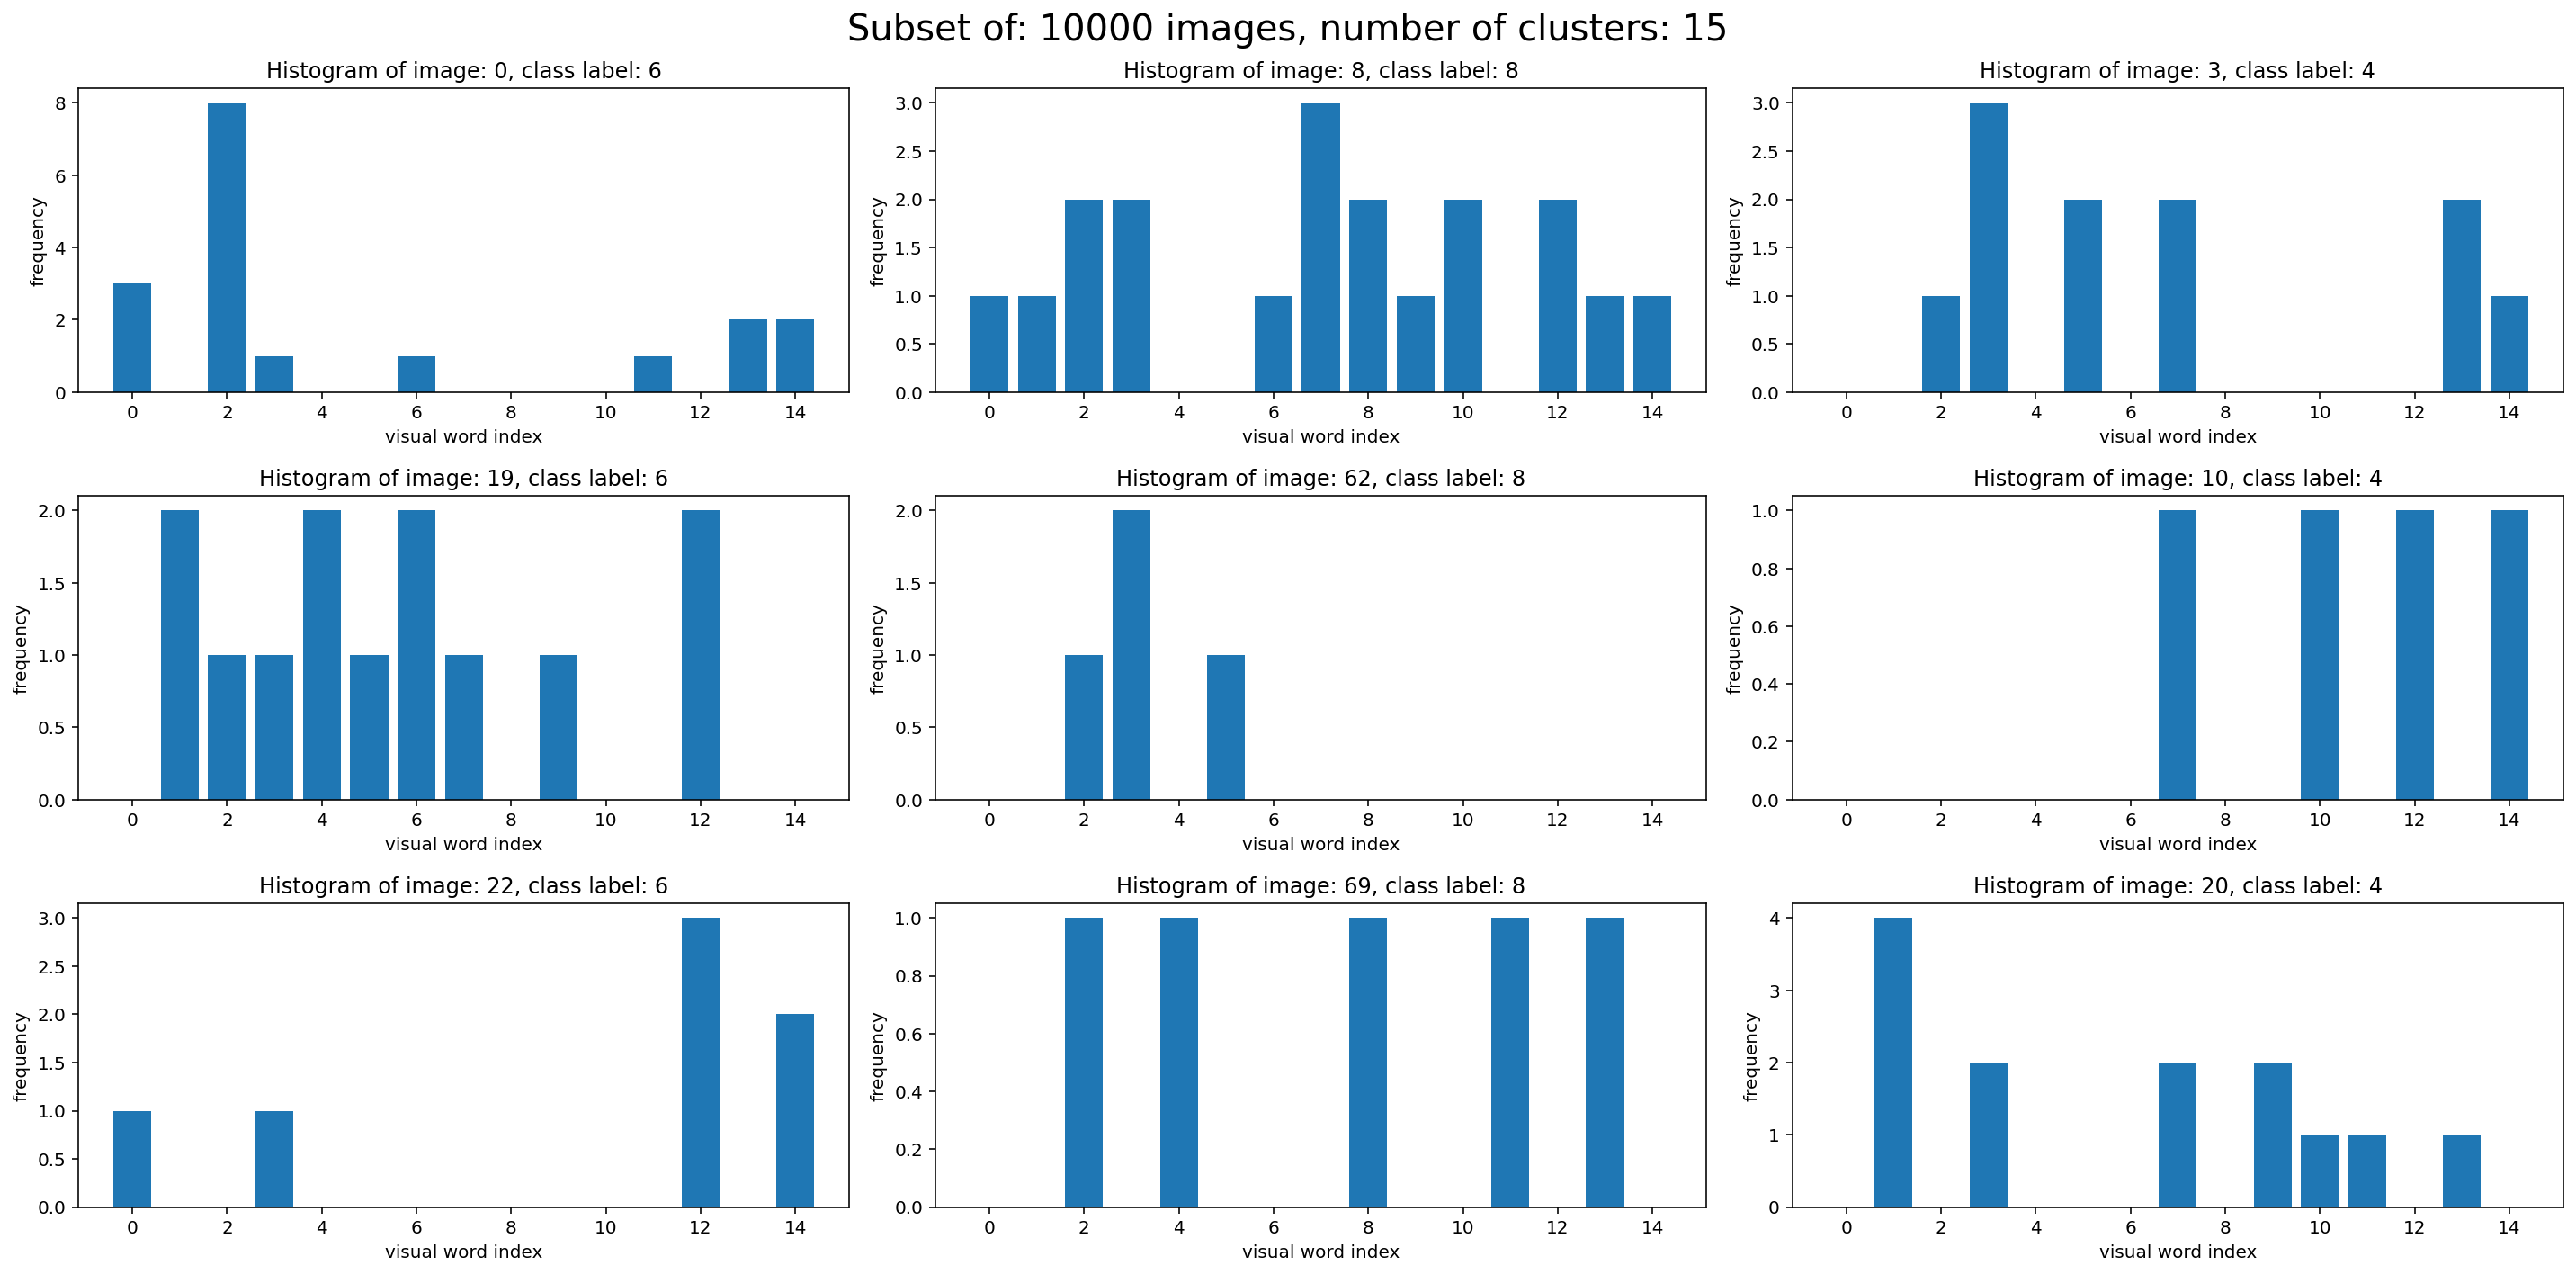

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))

indices_6 = np.where(y_train == 6)[0][:3]  # first 3 images belonging to class 6
for i, img_idx in enumerate(indices_6):
    plot_bowv_histogram(ax[i, 0], img_idx)

indices_8 = np.where(y_train == 8)[0][:3]  # first 3 images belonging to class 8
for i, img_idx in enumerate(indices_8):
    plot_bowv_histogram(ax[i, 1], img_idx)

indices_4 = np.where(y_train == 4)[0][:3]  # first 3 images belonging to class 4
for i, img_idx in enumerate(indices_4):
    plot_bowv_histogram(ax[i, 2], img_idx)

plt.suptitle(f"Subset of: {n_images} images, number of clusters: {no_clusters}", fontsize=20)

plt.tight_layout()
plt.show()


### KNN Train and Test

In [16]:
def train_knn(X, y, k):
    start_time = time.time()
    print("Starting with training of KNN model...")
    knn_model = KNeighborsClassifier(k)
    knn_model.fit(X, y)
    print("Training completed!")
    print ("Time taken in training {0}".format((time.time() - start_time)))
    return knn_model

In [17]:
def recognize(model, kmeans_obj, test_img):
    sift = cv2.SIFT_create()
    img_keypoints, img_desc = sift.detectAndCompute(test_img, None)
    no_clusters = kmeans_obj.n_clusters
    vocab = np.array( [[ 0 for i in range(no_clusters)]])
    if img_desc is not None:
        test_ret = kmeans_obj.predict(img_desc)
        for each in test_ret:
            vocab[0][each] +=1
        lb = model.predict(vocab)
        return lb
    else:
        lb = np.array([-1000])
        return lb

def test_model(model, kmeans_obj, x_test):
    predictions = []
    start_time = time.time()
    print ("Testing started ..")
    for image in x_test:
        cl = recognize(model, kmeans_obj, image)
        predictions.append(cl)
    print ("Testing completed")
    print ("Time taken in testing - {0}".format((time.time() - start_time)))
    return np.array(predictions)

def test_model_train_set(model, mega_histogram): 
    # there is no need to test the training set in the same way as test (mega_histogram is saved)
    start_time = time.time()
    print ("Testing started ..")
    predictions = model.predict(mega_histogram)
    print ("Testing completed")
    print ("Time taken in testing - {0}".format((time.time() - start_time)))
    return np.array(predictions)

In [18]:
def evaluate_model(y_train_pred, y_test_pred, k):
    # accuracy
    print("#"*40)
    print("Accuracy on train: ", accuracy_score(y_true=y_train, y_pred=y_train_pred))
    print("Accuracy on test: ", accuracy_score(y_true=y_test, y_pred=y_test_pred))
    # recall
    print("#"*40)
    print("Recall on train: ", recall_score(y_true=y_train, y_pred=y_train_pred, average='macro'))
    print("Recall on test: ", recall_score(y_true=y_test, y_pred=y_test_pred, average = 'macro'))
    # precision
    print("#"*40)
    print("Precision on train: ", precision_score(y_true=y_train, y_pred=y_train_pred, average='macro'))
    print("Precision on test: ", precision_score(y_true=y_test, y_pred=y_test_pred, average='macro'))

    # plot confusion matrices
    print("#"*40)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    c_1 = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
    if (len(np.unique(y_train_pred))==10):
        cmd_1 = ConfusionMatrixDisplay(c_1, display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    else:
        cmd_1 = ConfusionMatrixDisplay(c_1, display_labels=['not classified', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    cmd_1.plot(ax=ax[0], cmap=plt.cm.Blues)
    ax[0].set_title("Confusion matrix: train data")

    c_2 = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
    if (len(np.unique(y_test_pred))==10):
        cmd_2 = ConfusionMatrixDisplay(c_2, display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    else:
        cmd_2 = ConfusionMatrixDisplay(c_2, display_labels=['not classified', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    cmd_2.plot(ax=ax[1], cmap=plt.cm.Blues)
    ax[1].set_title("Confusion matrix: test data")
    
    plt.tight_layout()
    plt.suptitle("k-NN classifier, k = " + str(k), fontsize=15, ha='center')
    plt.subplots_adjust(top=0.85)

    plt.show()

HERE STARTS TRAINING AND TESTING OUR MODEL........

### no_clusters = 10

In [17]:
list_of_all_descriptors, kmeans_obj = generate_vocabulary(n_images=50000, no_clusters=10)
mega_histogram = histogram_creation(descriptor_list=list_of_all_descriptors, kmeans_obj=kmeans_obj)
# this whole part was running for 46 min

SIFT feature extraction begins...
Time taken for SIFT feature extraction: 45.79066300392151
Stacking begins...
Stacking done
Starting with clustering...
Clustering completed!
Time taken for clustering: 65.8406891822815
Vocabulary Histogram Generated


In [18]:
# save the current model
with open('mega_histogram_train_10.txt', 'wb') as f:
    np.save(f, mega_histogram)
joblib.dump(kmeans_obj, 'kmeans_model_10.pkl')

['kmeans_model_10.pkl']

In [19]:
with open('mega_histogram_train_10.txt', 'rb') as f:
    mega_histogram = np.load(f)
kmeans_obj = joblib.load('kmeans_model_10.pkl')
no_clusters = kmeans_obj.n_clusters

Starting with training of KNN model...
Training completed!
Time taken in training 0.2483508586883545
Testing started ..
Testing completed
Time taken in testing - 146.41596293449402
Testing started ..
Testing completed
Time taken in testing - 8.484174489974976
########################################
Accuracy on train:  0.46
Accuracy on test:  0.1595
########################################
Recall on train:  0.45999999999999996
Recall on test:  0.14500000000000002
########################################
Precision on train:  0.5266589185964421
Precision on test:  0.1508063883294357
########################################


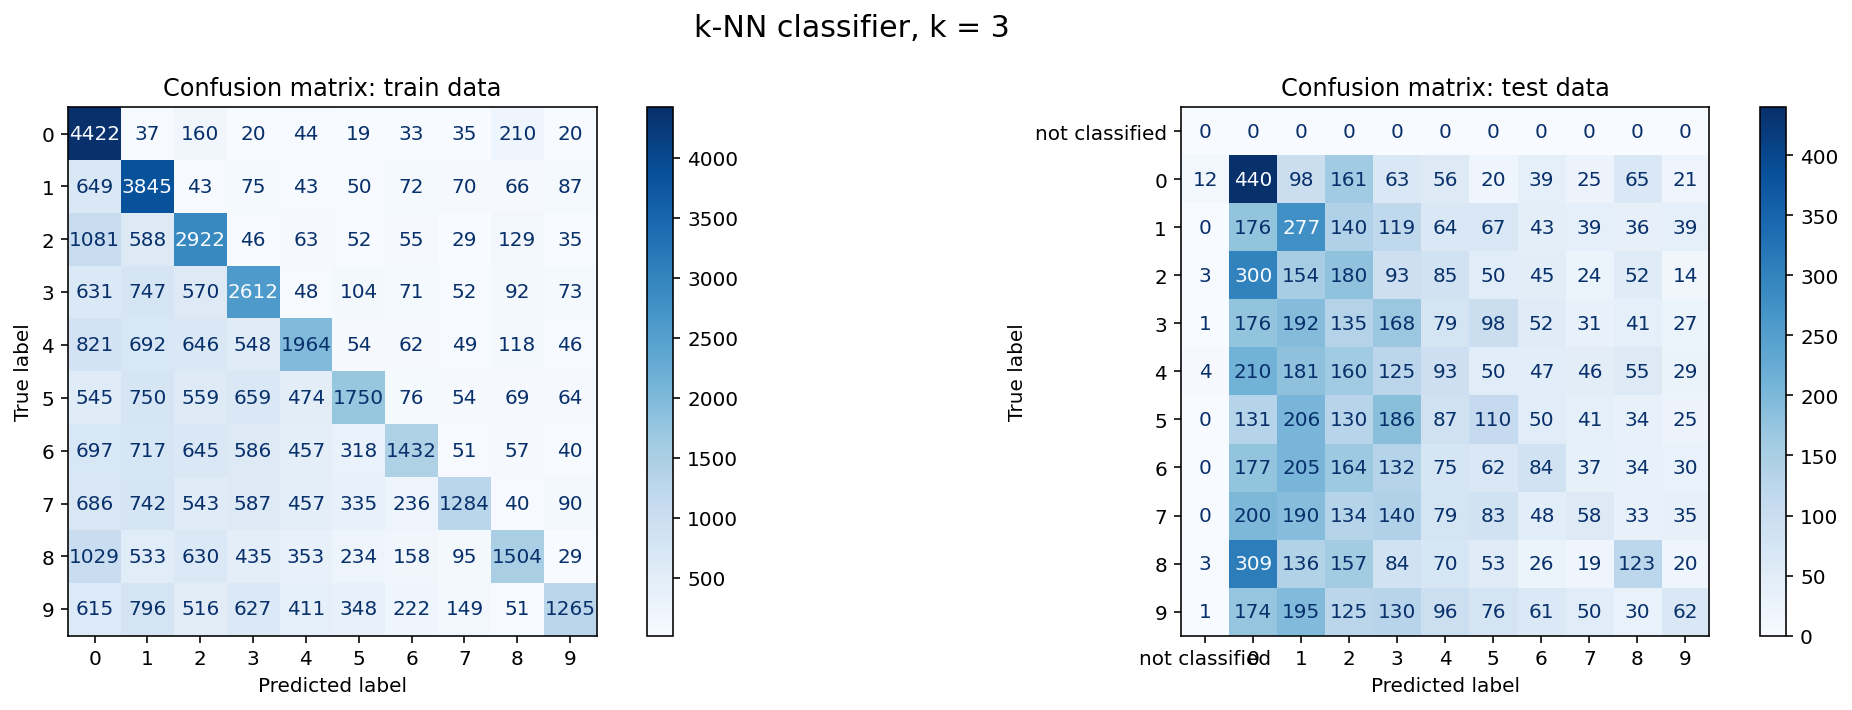

In [23]:
k = 3
knn_model = train_knn(mega_histogram, y_train, k)
y_test_pred = test_model(knn_model, kmeans_obj, X_test)
y_train_pred = test_model_train_set(knn_model, mega_histogram)
evaluate_model(y_train_pred, y_test_pred, k)

In [24]:
k_vect = np.array([3, 5, 7, 11, 15, 17])
acc_train_vect = np.zeros(len(k_vect))
acc_test_vect = np.zeros(len(k_vect))
for i in range(0, len(k_vect)):
    k = k_vect[i]
    print("k=", k)
    knn_model = train_knn(mega_histogram, y_train, k)
    y_test_pred = test_model(knn_model, kmeans_obj, X_test)
    y_train_pred = test_model_train_set(knn_model, mega_histogram)
    acc_train_vect[i] = accuracy_score(y_true=y_train, y_pred=y_train_pred)
    acc_test_vect[i] = accuracy_score(y_true=y_test, y_pred=y_test_pred)

k= 3
Starting with training of KNN model...
Training completed!
Time taken in training 0.2263939380645752
Testing started ..
Testing completed
Time taken in testing - 147.5225522518158
Testing started ..
Testing completed
Time taken in testing - 8.32973313331604
k= 5
Starting with training of KNN model...
Training completed!
Time taken in training 0.1878371238708496
Testing started ..
Testing completed
Time taken in testing - 143.060613155365
Testing started ..
Testing completed
Time taken in testing - 9.517116069793701
k= 7
Starting with training of KNN model...
Training completed!
Time taken in training 0.2613534927368164
Testing started ..
Testing completed
Time taken in testing - 146.55365705490112
Testing started ..
Testing completed
Time taken in testing - 11.49843716621399
k= 11
Starting with training of KNN model...
Training completed!
Time taken in training 0.20951151847839355
Testing started ..
Testing completed
Time taken in testing - 144.41938877105713
Testing started ..
Te

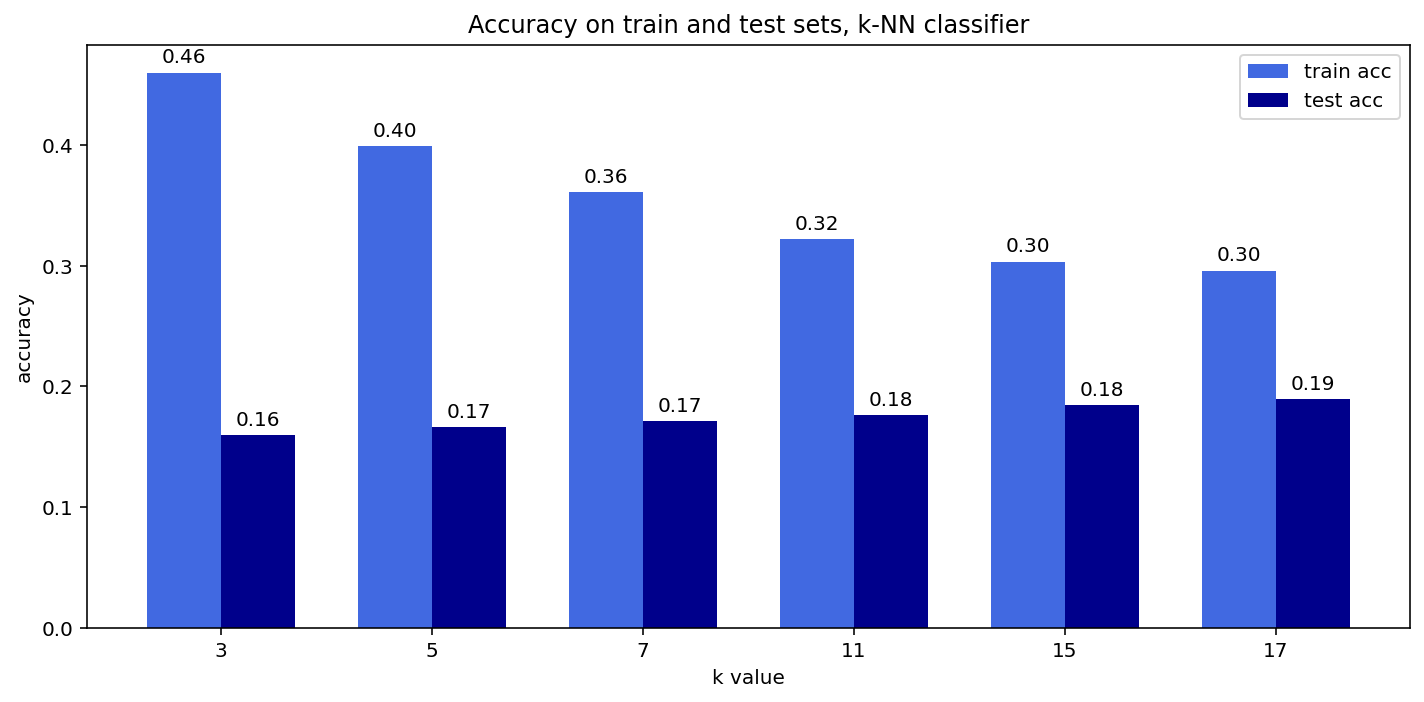

In [25]:
bar_width = 0.35
x_pos = range(len(k_vect))

fig, ax = plt.subplots(figsize=(10, 5))

train_bars = ax.bar(x_pos, acc_train_vect, width=bar_width, label='train acc', color='royalblue')
test_bars = ax.bar([pos + bar_width for pos in x_pos], acc_test_vect, width=bar_width, label='test acc', color='darkblue')

ax.set_xticks([pos + bar_width / 2 for pos in x_pos])
ax.set_xticklabels(k_vect)

ax.set_xlabel('k value')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy on train and test sets, k-NN classifier')
ax.legend()

# function to add text labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom')

# add labels on top of the bars
add_labels(train_bars)
add_labels(test_bars)

plt.tight_layout()
plt.show()

Starting with training of KNN model...
Training completed!
Time taken in training 0.31449007987976074
Testing started ..
Testing completed
Time taken in testing - 150.0239737033844
Testing started ..
Testing completed
Time taken in testing - 15.53845500946045
########################################
Accuracy on train:  0.2959
Accuracy on test:  0.1894
########################################
Recall on train:  0.29589999999999994
Recall on test:  0.17218181818181819
########################################
Precision on train:  0.2953062780821305
Precision on test:  0.1676680516599155
########################################


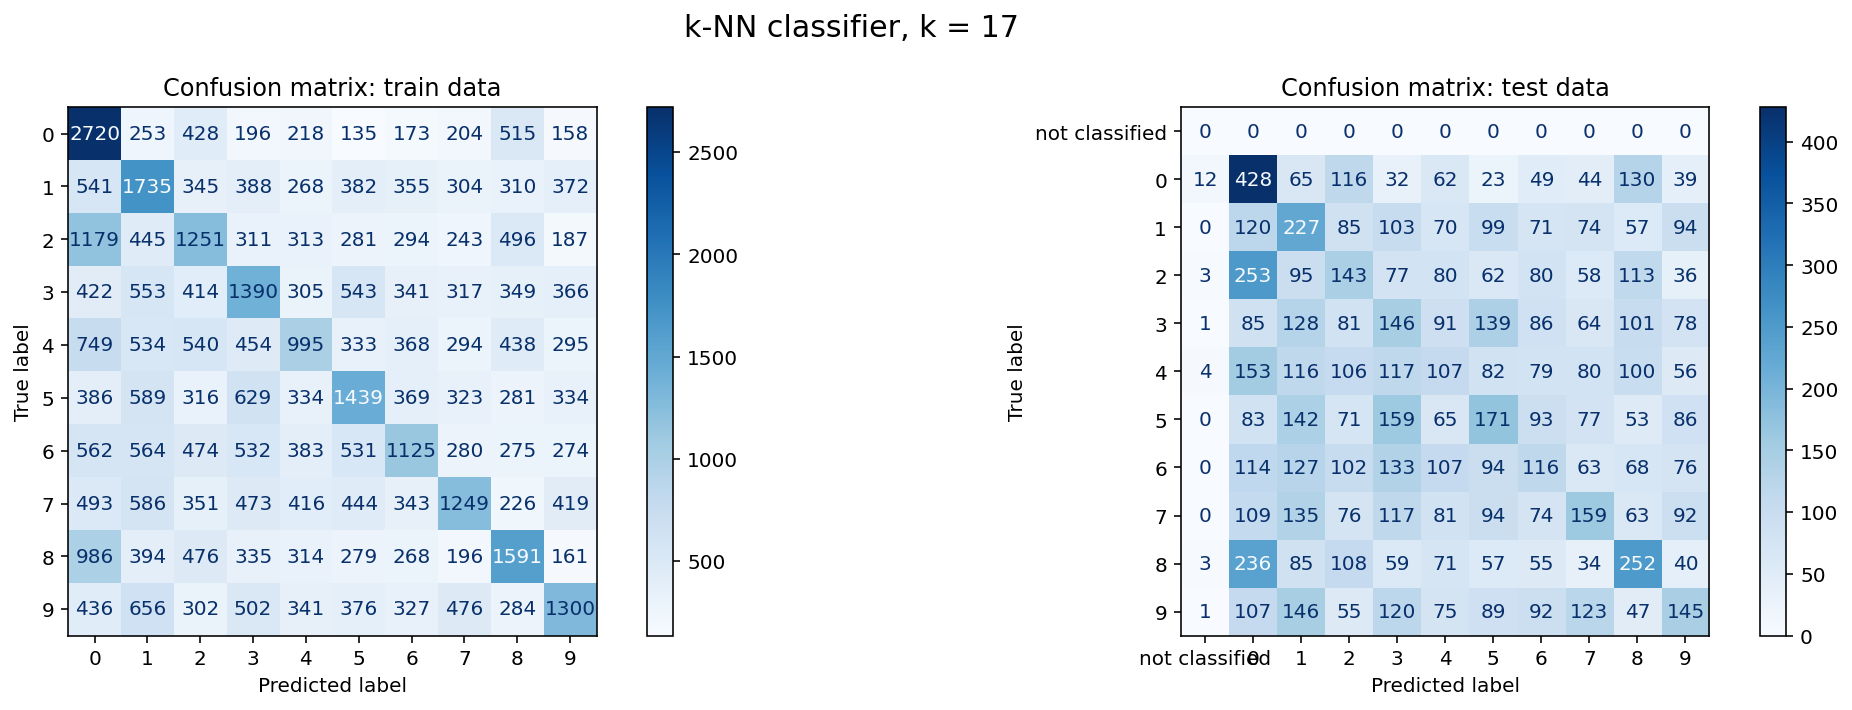

In [26]:
k = 17
knn_model = train_knn(mega_histogram, y_train, k)
y_test_pred = test_model(knn_model, kmeans_obj, X_test)
y_train_pred = test_model_train_set(knn_model, mega_histogram)
evaluate_model(y_train_pred, y_test_pred, k)

### no_clusters = 50

In [42]:
list_of_all_descriptors, kmeans_obj = generate_vocabulary(n_images=50000, no_clusters=50)
mega_histogram = histogram_creation(descriptor_list=list_of_all_descriptors, kmeans_obj=kmeans_obj)
# this whole part was running for 51 min

SIFT feature extraction begins...
Time taken for SIFT feature extraction: 44.08966374397278
Stacking begins...
Stacking done
Starting with clustering...
Clustering completed!
Time taken for clustering: 485.1972529888153
Vocabulary Histogram Generated


In [54]:
# save the current model
with open('mega_histogram_train_50.txt', 'wb') as f:
    np.save(f, mega_histogram)
joblib.dump(kmeans_obj, 'kmeans_model_50.pkl')

['kmeans_model_50.pkl']

In [16]:
with open('mega_histogram_train_50.txt', 'rb') as f:
    mega_histogram = np.load(f)
kmeans_obj = joblib.load('kmeans_model_50.pkl')
no_clusters = kmeans_obj.n_clusters

Starting with training of KNN model...
Training completed!
Time taken in training 0.010979413986206055
Testing started ..
Testing completed
Time taken in testing - 223.69797277450562
Testing started ..
Testing completed
Time taken in testing - 7.045614719390869
########################################
Accuracy on train:  0.44814
Accuracy on test:  0.1702
########################################
Recall on train:  0.44814
Recall on test:  0.15472727272727274
########################################
Precision on train:  0.5450769755985527
Precision on test:  0.17105372687631892
########################################


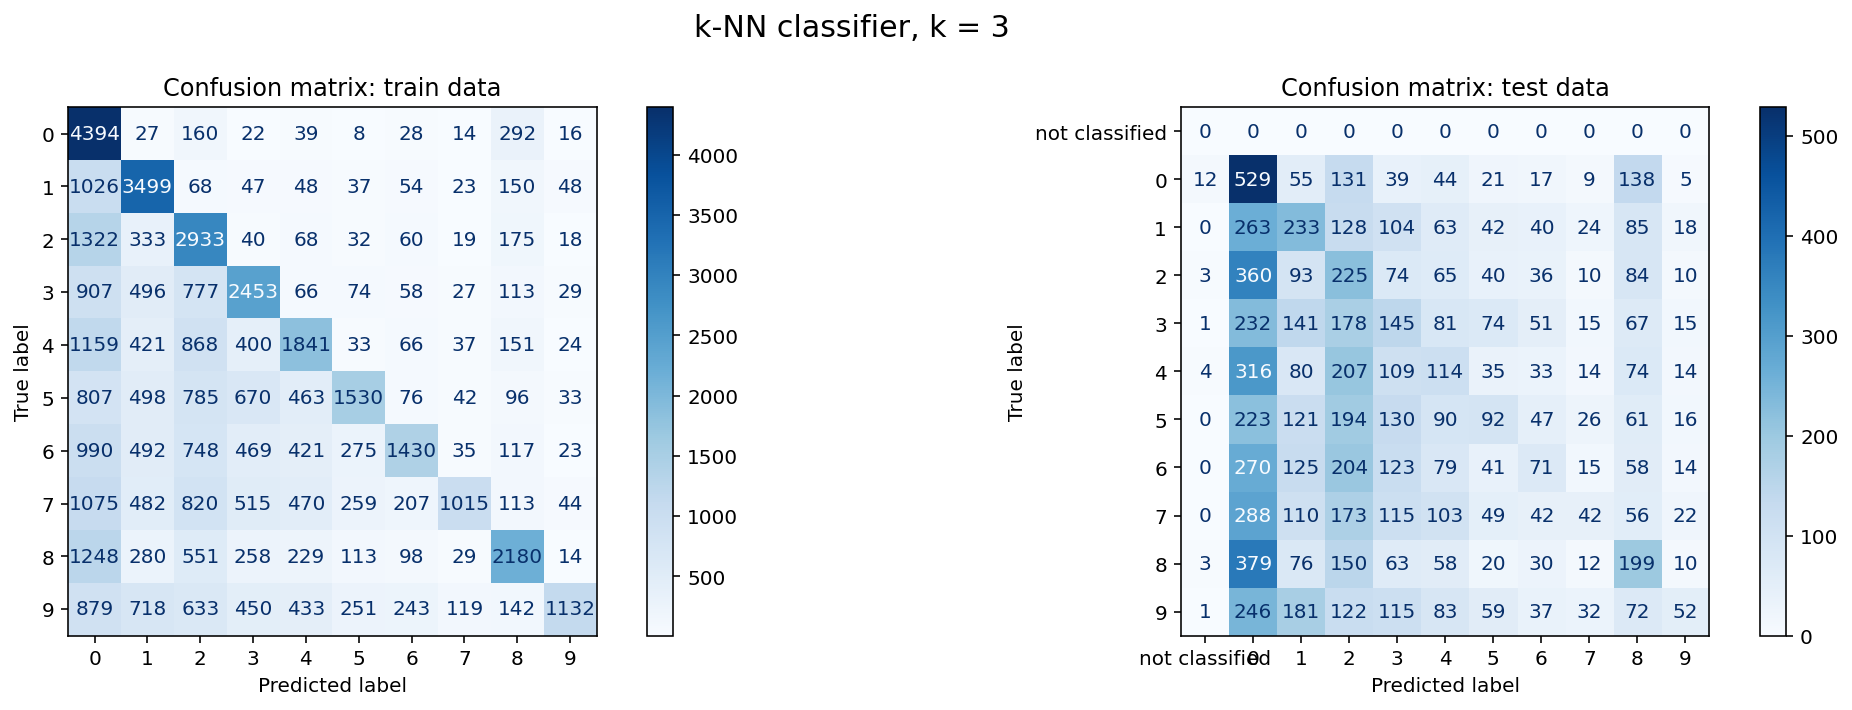

In [60]:
k = 3
knn_model = train_knn(mega_histogram, y_train, k)
y_test_pred = test_model(knn_model, kmeans_obj, X_test)
y_train_pred = test_model_train_set(knn_model, mega_histogram)
evaluate_model(y_train_pred, y_test_pred, k)

In [32]:
k_vect = np.array([3, 5, 7, 11, 15, 17])
acc_train_vect = np.zeros(len(k_vect))
acc_test_vect = np.zeros(len(k_vect))
for i in range(0, len(k_vect)):
    k = k_vect[i]
    print("k=", k)
    knn_model = train_knn(mega_histogram, y_train, k)
    y_test_pred = test_model(knn_model, kmeans_obj, X_test)
    y_train_pred = test_model_train_set(knn_model, mega_histogram)
    acc_train_vect[i] = accuracy_score(y_true=y_train, y_pred=y_train_pred)
    acc_test_vect[i] = accuracy_score(y_true=y_test, y_pred=y_test_pred)

k= 3
Starting with training of KNN model...
Training completed!
Time taken in training 0.020610570907592773
Testing started ..
Testing completed
Time taken in testing - 218.6298987865448
Testing started ..
Testing completed
Time taken in testing - 4.3217689990997314
k= 5
Starting with training of KNN model...
Training completed!
Time taken in training 0.007990598678588867
Testing started ..
Testing completed
Time taken in testing - 284.21739768981934
Testing started ..
Testing completed
Time taken in testing - 5.75485897064209
k= 7
Starting with training of KNN model...
Training completed!
Time taken in training 0.007996082305908203
Testing started ..
Testing completed
Time taken in testing - 293.1151342391968
Testing started ..
Testing completed
Time taken in testing - 4.399677991867065
k= 11
Starting with training of KNN model...
Training completed!
Time taken in training 0.0026035308837890625
Testing started ..
Testing completed
Time taken in testing - 221.1695671081543
Testing star

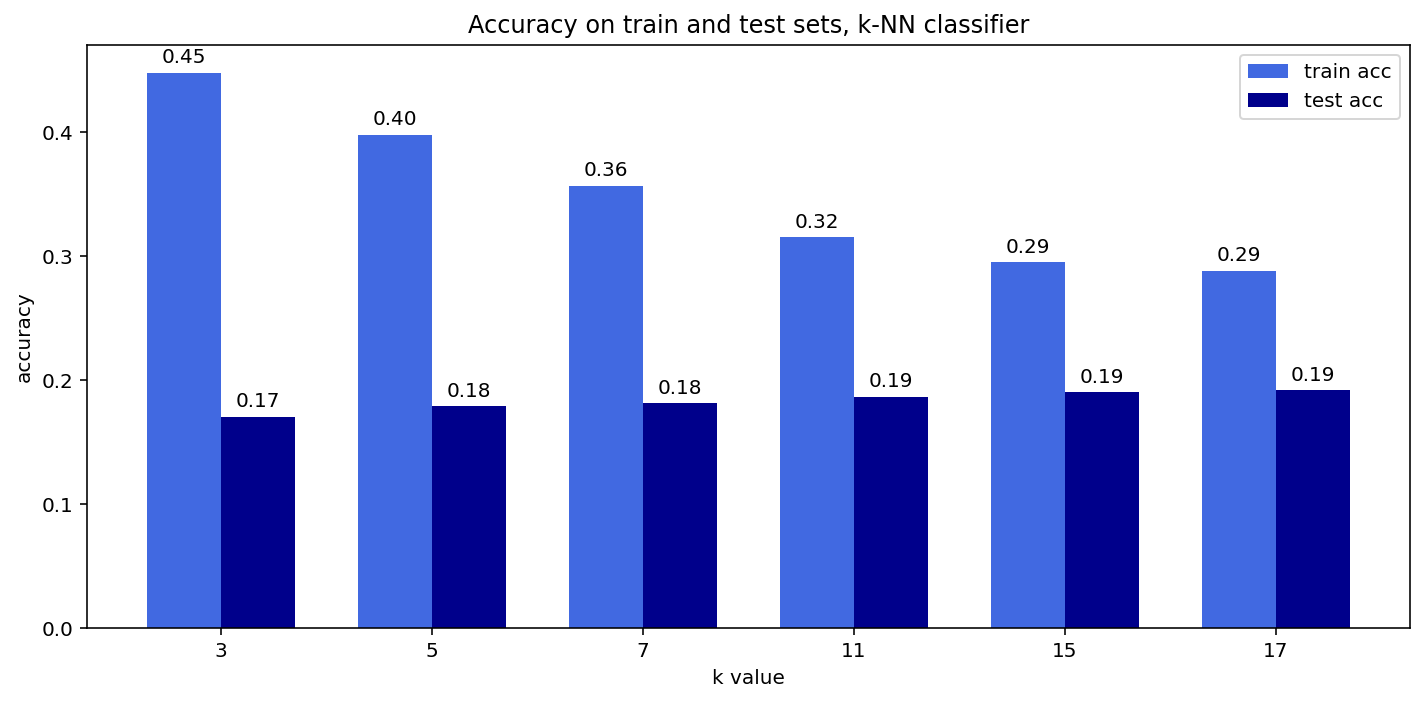

In [36]:
bar_width = 0.35
x_pos = range(len(k_vect))

fig, ax = plt.subplots(figsize=(10, 5))

train_bars = ax.bar(x_pos, acc_train_vect, width=bar_width, label='train acc', color='royalblue')
test_bars = ax.bar([pos + bar_width for pos in x_pos], acc_test_vect, width=bar_width, label='test acc', color='darkblue')

ax.set_xticks([pos + bar_width / 2 for pos in x_pos])
ax.set_xticklabels(k_vect)

ax.set_xlabel('k value')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy on train and test sets, k-NN classifier')
ax.legend()

# function to add text labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom')

# add labels on top of the bars
add_labels(train_bars)
add_labels(test_bars)

plt.tight_layout()
plt.show()


Starting with training of KNN model...
Training completed!
Time taken in training 0.0032095909118652344
Testing started ..
Testing completed
Time taken in testing - 279.8499665260315
Testing started ..
Testing completed
Time taken in testing - 6.9142842292785645
########################################
Accuracy on train:  0.31514
Accuracy on test:  0.1863
########################################
Recall on train:  0.31514
Recall on test:  0.16936363636363636
########################################
Precision on train:  0.3590315731266493
Precision on test:  0.1819584751533873
########################################


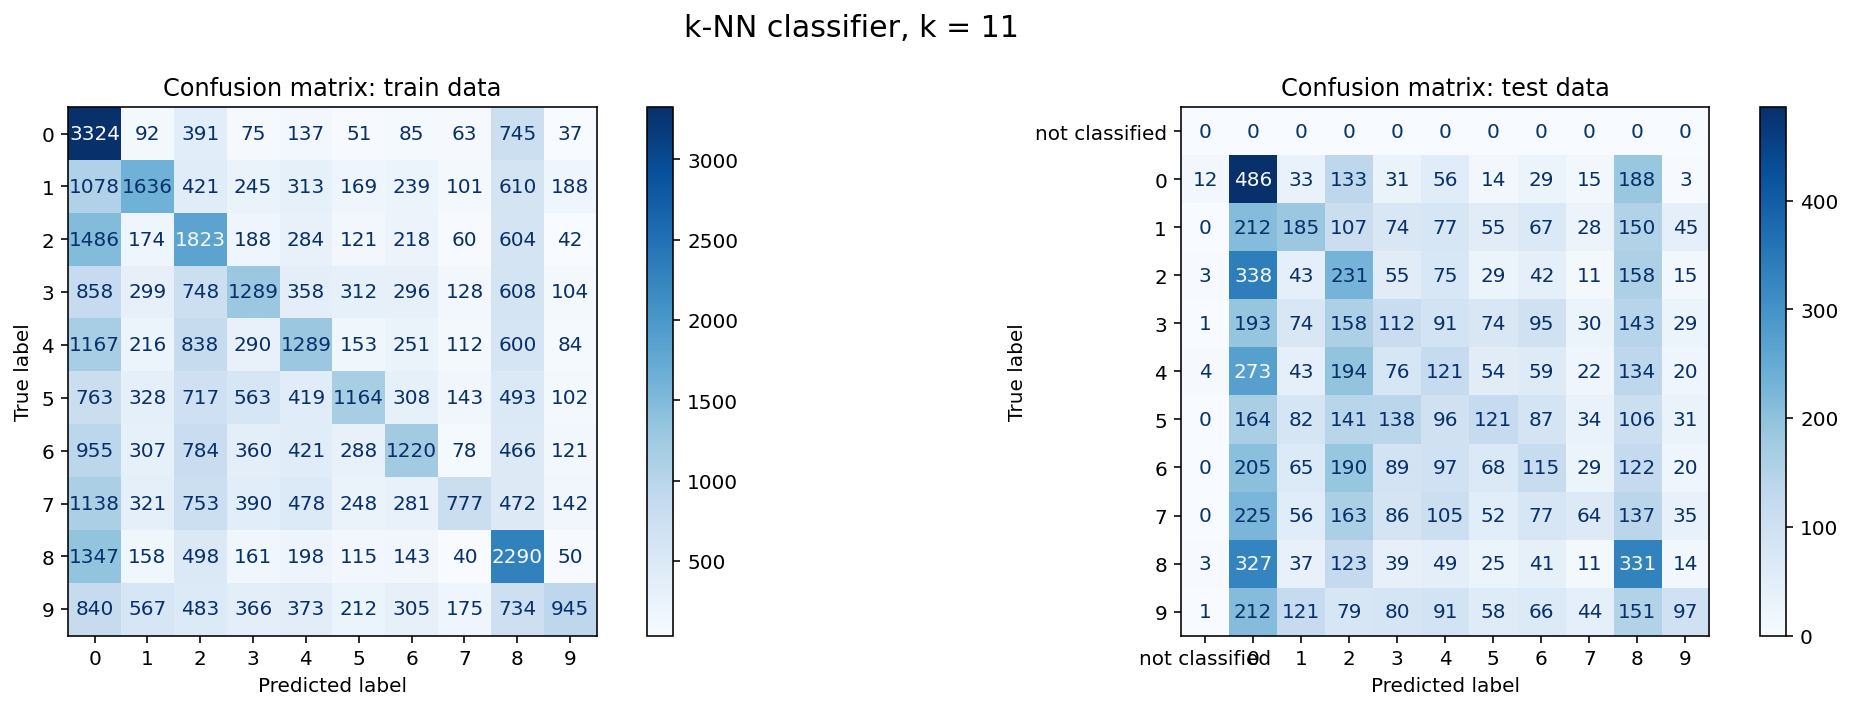

In [61]:
k = 11
knn_model = train_knn(mega_histogram, y_train, k)
y_test_pred = test_model(knn_model, kmeans_obj, X_test)
y_train_pred = test_model_train_set(knn_model, mega_histogram)
evaluate_model(y_train_pred, y_test_pred, k)

### Feature combiner: features - combination of SIFT and V (from HSV) + k-NN
This step was taken with the aim of classification improvement...

In [19]:
with open('mega_histogram_train_50.txt', 'rb') as f:
    mega_histogram = np.load(f)
kmeans_obj = joblib.load('kmeans_model_50.pkl')
no_clusters = kmeans_obj.n_clusters

In [20]:
num_samples = X_train.shape[0]
v_histogram = np.zeros([num_samples, 256])
for i in range(0, num_samples): 
    _, _, v_hist = calculate_histogram_hsv(index=i)
    v_histogram[i, :] = v_hist

In [21]:
combination = np.concatenate((mega_histogram, v_histogram), axis=1)
print(mega_histogram.shape, v_histogram.shape, combination.shape)

(50000, 50) (50000, 256) (50000, 306)


In [22]:
# For testing purposes of model that uses combination of features functions recognize and test_model need to be adapted a bit

def recognize_combiner(model, kmeans_obj, test_img):
    sift = cv2.SIFT_create()
    img_keypoints, img_desc = sift.detectAndCompute(test_img, None)
    no_clusters = kmeans_obj.n_clusters
    vocab = np.array( [[ 0 for i in range(no_clusters)]])
    if img_desc is not None:
        test_ret = kmeans_obj.predict(img_desc)
        for each in test_ret:
            vocab[0][each] +=1

        # adding V histogram from HSV
        img_hsv = cv2.cvtColor(test_img, cv2.COLOR_RGB2HSV)
        v = img_hsv[:, :, 2]  # value channel (corresponds to the light amount)
        hist_v, _ = np.histogram(v, bins=256, range=(0, 256))
        hist_v = hist_v.astype(np.float32)
        hist_v /= hist_v.sum()
        
        vocab = np.concatenate((vocab, hist_v.reshape(1, 256)), axis=1)
        lb = model.predict(vocab)
        return lb
    else:
        lb = np.array([-1000])
        return lb

def test_model_combiner(model, kmeans_obj, x_test):
    predictions = []
    start_time = time.time()
    print ("Testing started ..")
    for image in x_test:
        cl = recognize_combiner(model, kmeans_obj, image)
        predictions.append(cl)
    print ("Testing completed")
    print ("Time taken in testing - {0}".format((time.time() - start_time)))
    return np.array(predictions)

Starting with training of KNN model...
Training completed!
Time taken in training 0.03661513328552246
Testing started ..
Testing completed
Time taken in testing - 394.7171926498413
Testing started ..
Testing completed
Time taken in testing - 13.860177278518677
########################################
Accuracy on train:  0.46704
Accuracy on test:  0.1767
########################################
Recall on train:  0.46704
Recall on test:  0.16063636363636363
########################################
Precision on train:  0.5514483920180517
Precision on test:  0.17281693799311848
########################################


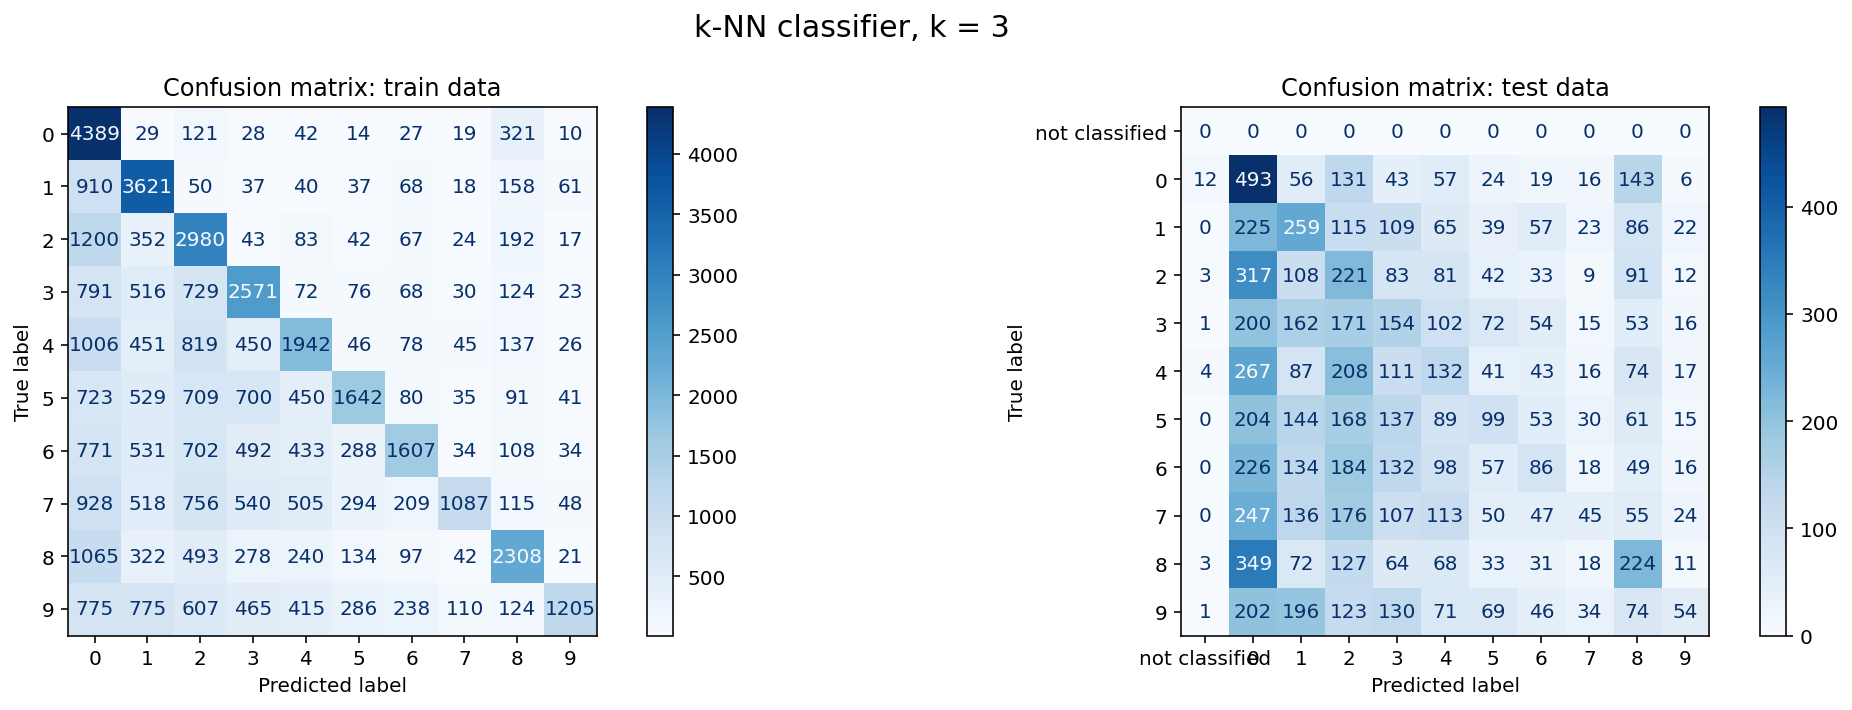

In [23]:
k = 3
knn_model = train_knn(combination, y_train, k)
y_test_pred = test_model_combiner(knn_model, kmeans_obj, X_test)
y_train_pred = test_model_train_set(knn_model, mega_histogram=combination)
evaluate_model(y_train_pred, y_test_pred, k)
# 7 min

In [24]:
k_vect = np.array([3, 7, 15, 19])
acc_train_vect = np.zeros(len(k_vect))
acc_test_vect = np.zeros(len(k_vect))
for i in range(0, len(k_vect)):
    k = k_vect[i]
    print("k=", k)
    knn_model = train_knn(combination, y_train, k)
    y_test_pred = test_model_combiner(knn_model, kmeans_obj, X_test)
    y_train_pred = test_model_train_set(knn_model, mega_histogram=combination)
    acc_train_vect[i] = accuracy_score(y_true=y_train, y_pred=y_train_pred)
    acc_test_vect[i] = accuracy_score(y_true=y_test, y_pred=y_test_pred)

k= 3
Starting with training of KNN model...
Training completed!
Time taken in training 0.04776406288146973
Testing started ..
Testing completed
Time taken in testing - 400.8074417114258
Testing started ..
Testing completed
Time taken in testing - 13.512794256210327
k= 7
Starting with training of KNN model...
Training completed!
Time taken in training 0.020054101943969727
Testing started ..
Testing completed
Time taken in testing - 394.2934331893921
Testing started ..
Testing completed
Time taken in testing - 14.977176666259766
k= 15
Starting with training of KNN model...
Training completed!
Time taken in training 0.02491617202758789
Testing started ..
Testing completed
Time taken in testing - 417.809095621109
Testing started ..
Testing completed
Time taken in testing - 15.019411087036133
k= 19
Starting with training of KNN model...
Training completed!
Time taken in training 0.02391958236694336
Testing started ..
Testing completed
Time taken in testing - 458.55304622650146
Testing start

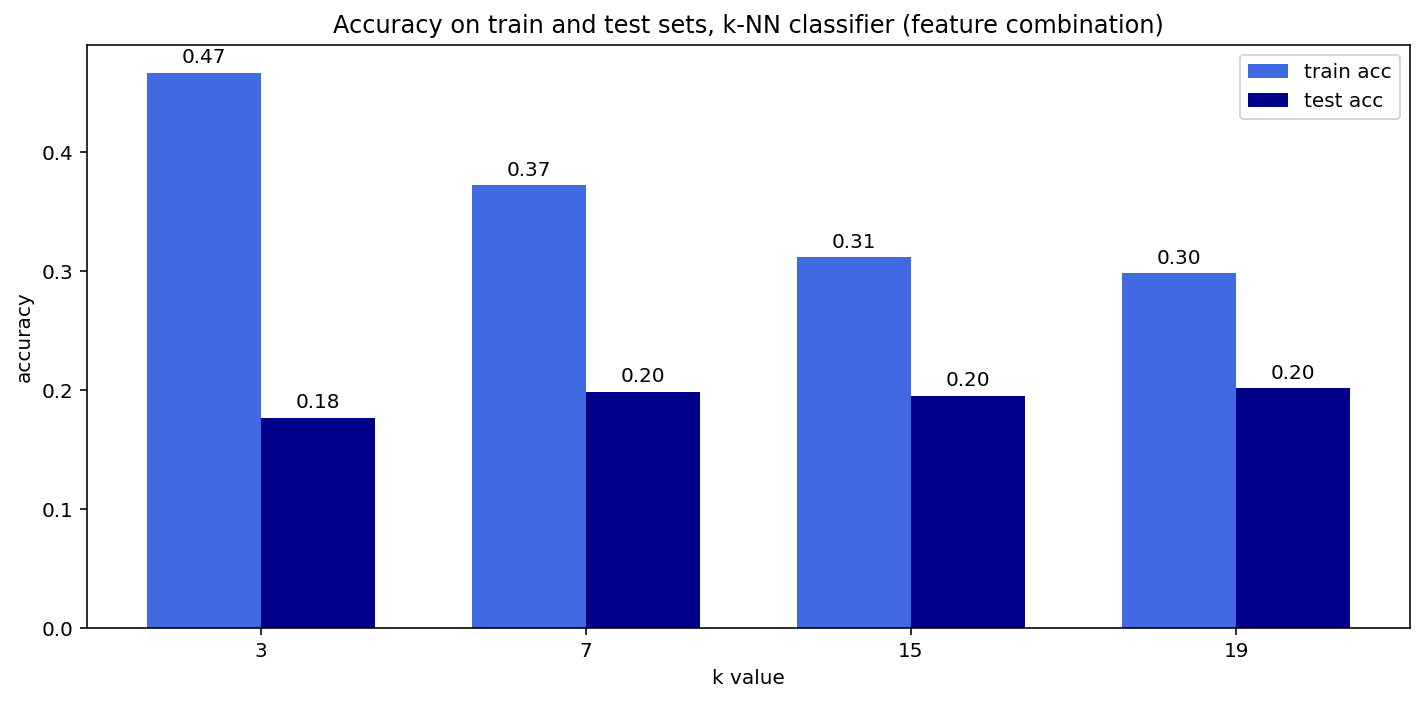

In [25]:
bar_width = 0.35
x_pos = range(len(k_vect))

fig, ax = plt.subplots(figsize=(10, 5))

train_bars = ax.bar(x_pos, acc_train_vect, width=bar_width, label='train acc', color='royalblue')
test_bars = ax.bar([pos + bar_width for pos in x_pos], acc_test_vect, width=bar_width, label='test acc', color='darkblue')

ax.set_xticks([pos + bar_width / 2 for pos in x_pos])
ax.set_xticklabels(k_vect)

ax.set_xlabel('k value')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy on train and test sets, k-NN classifier (feature combination)')
ax.legend()

# function to add text labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom')

# add labels on top of the bars
add_labels(train_bars)
add_labels(test_bars)

plt.tight_layout()
plt.show()

Starting with training of KNN model...
Training completed!
Time taken in training 0.0366365909576416
Testing started ..
Testing completed
Time taken in testing - 399.1564972400665
Testing started ..
Testing completed
Time taken in testing - 20.371562719345093
########################################
Accuracy on train:  0.31166
Accuracy on test:  0.195
########################################
Recall on train:  0.31166
Recall on test:  0.17727272727272728
########################################
Precision on train:  0.34301834461399866
Precision on test:  0.18385494125106214
########################################


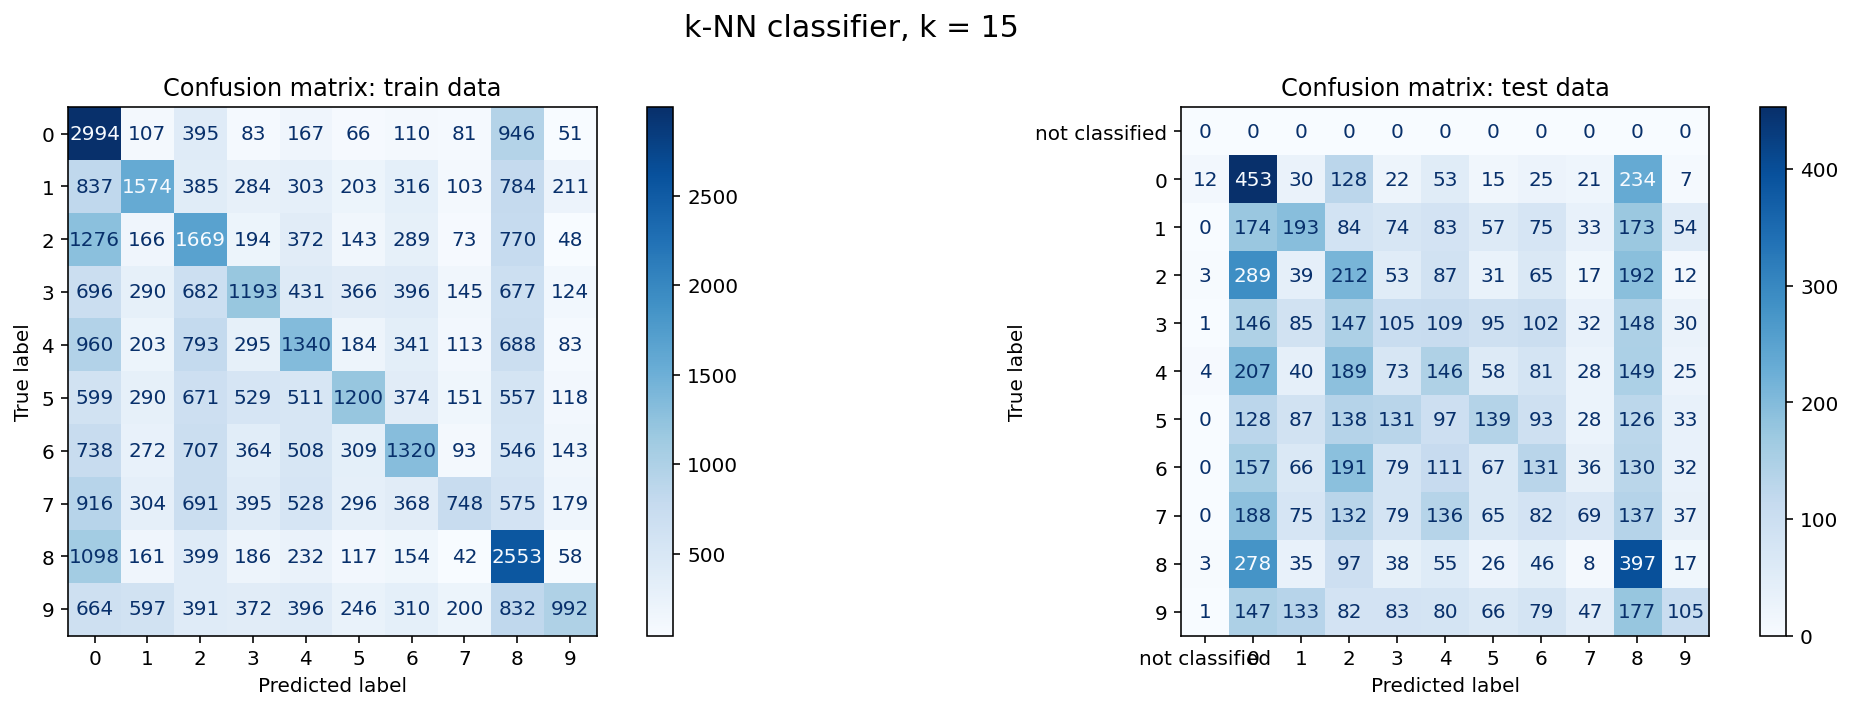

In [26]:
k = 15
knn_model = train_knn(combination, y_train, k)
y_test_pred = test_model_combiner(knn_model, kmeans_obj, X_test)
y_train_pred = test_model_train_set(knn_model, mega_histogram=combination)
evaluate_model(y_train_pred, y_test_pred, k)

### One vs Rest - SVM

In [25]:
def train_svm(X,Y, c):
    start_time = time.time()
    print("Starting training with model SVM...")
    svm_model = OneVsRestClassifier(SVC(kernel = 'linear',C = c)).fit(X,Y)
    print("Training completed!")
    print ("Time taken in training - {0}".format((time.time() - start_time)))
    return svm_model

def evaluate_model_svm(y_train_pred, y_test_pred, c):
    # accuracy
    print("#"*40)
    print("Accuracy on train: ", accuracy_score(y_true=y_train, y_pred=y_train_pred))
    print("Accuracy on test: ", accuracy_score(y_true=y_test, y_pred=y_test_pred))
    # recall
    print("#"*40)
    print("Recall on train: ", recall_score(y_true=y_train, y_pred=y_train_pred, average='macro'))
    print("Recall on test: ", recall_score(y_true=y_test, y_pred=y_test_pred, average = 'macro'))
    # precision
    print("#"*40)
    print("Precision on train: ", precision_score(y_true=y_train, y_pred=y_train_pred, average='macro'))
    print("Precision on test: ", precision_score(y_true=y_test, y_pred=y_test_pred, average='macro'))

    # plot confusion matrices
    print("#"*40)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    c_1 = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
    if (len(np.unique(y_train_pred))==10):
        cmd_1 = ConfusionMatrixDisplay(c_1, display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    else:
        cmd_1 = ConfusionMatrixDisplay(c_1, display_labels=['not classified', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    cmd_1.plot(ax=ax[0], cmap=plt.cm.Blues)
    ax[0].set_title("Confusion matrix: train data")

    c_2 = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
    if (len(np.unique(y_test_pred))==10):
        cmd_2 = ConfusionMatrixDisplay(c_2, display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    else:
        cmd_2 = ConfusionMatrixDisplay(c_2, display_labels=['not classified', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    cmd_2.plot(ax=ax[1], cmap=plt.cm.Blues)
    ax[1].set_title("Confusion matrix: test data")
    
    plt.tight_layout()
    plt.suptitle("SVM Classifier, c = " + str(c), fontsize=15, ha='center')
    plt.subplots_adjust(top=0.85)

    plt.show()

#### k = 10

In [23]:
with open('mega_histogram_train_10.txt', 'rb') as f:
    mega_histogram = np.load(f)
kmeans_obj = joblib.load('kmeans_model_10.pkl')
no_clusters = kmeans_obj.n_clusters

Starting training with model SVM...
Training completed!
Time taken in training - 421.7997920513153
Testing started ..
Testing completed
Time taken in testing - 75.91422009468079
Testing started ..
Testing completed
Time taken in testing - 118.90788984298706
########################################
Accuracy on train:  0.10892
Accuracy on test:  0.1083
########################################
Recall on train:  0.10891999999999999
Recall on test:  0.09845454545454545
########################################
Precision on train:  0.10104500262071126
Precision on test:  0.09535104454875021
########################################


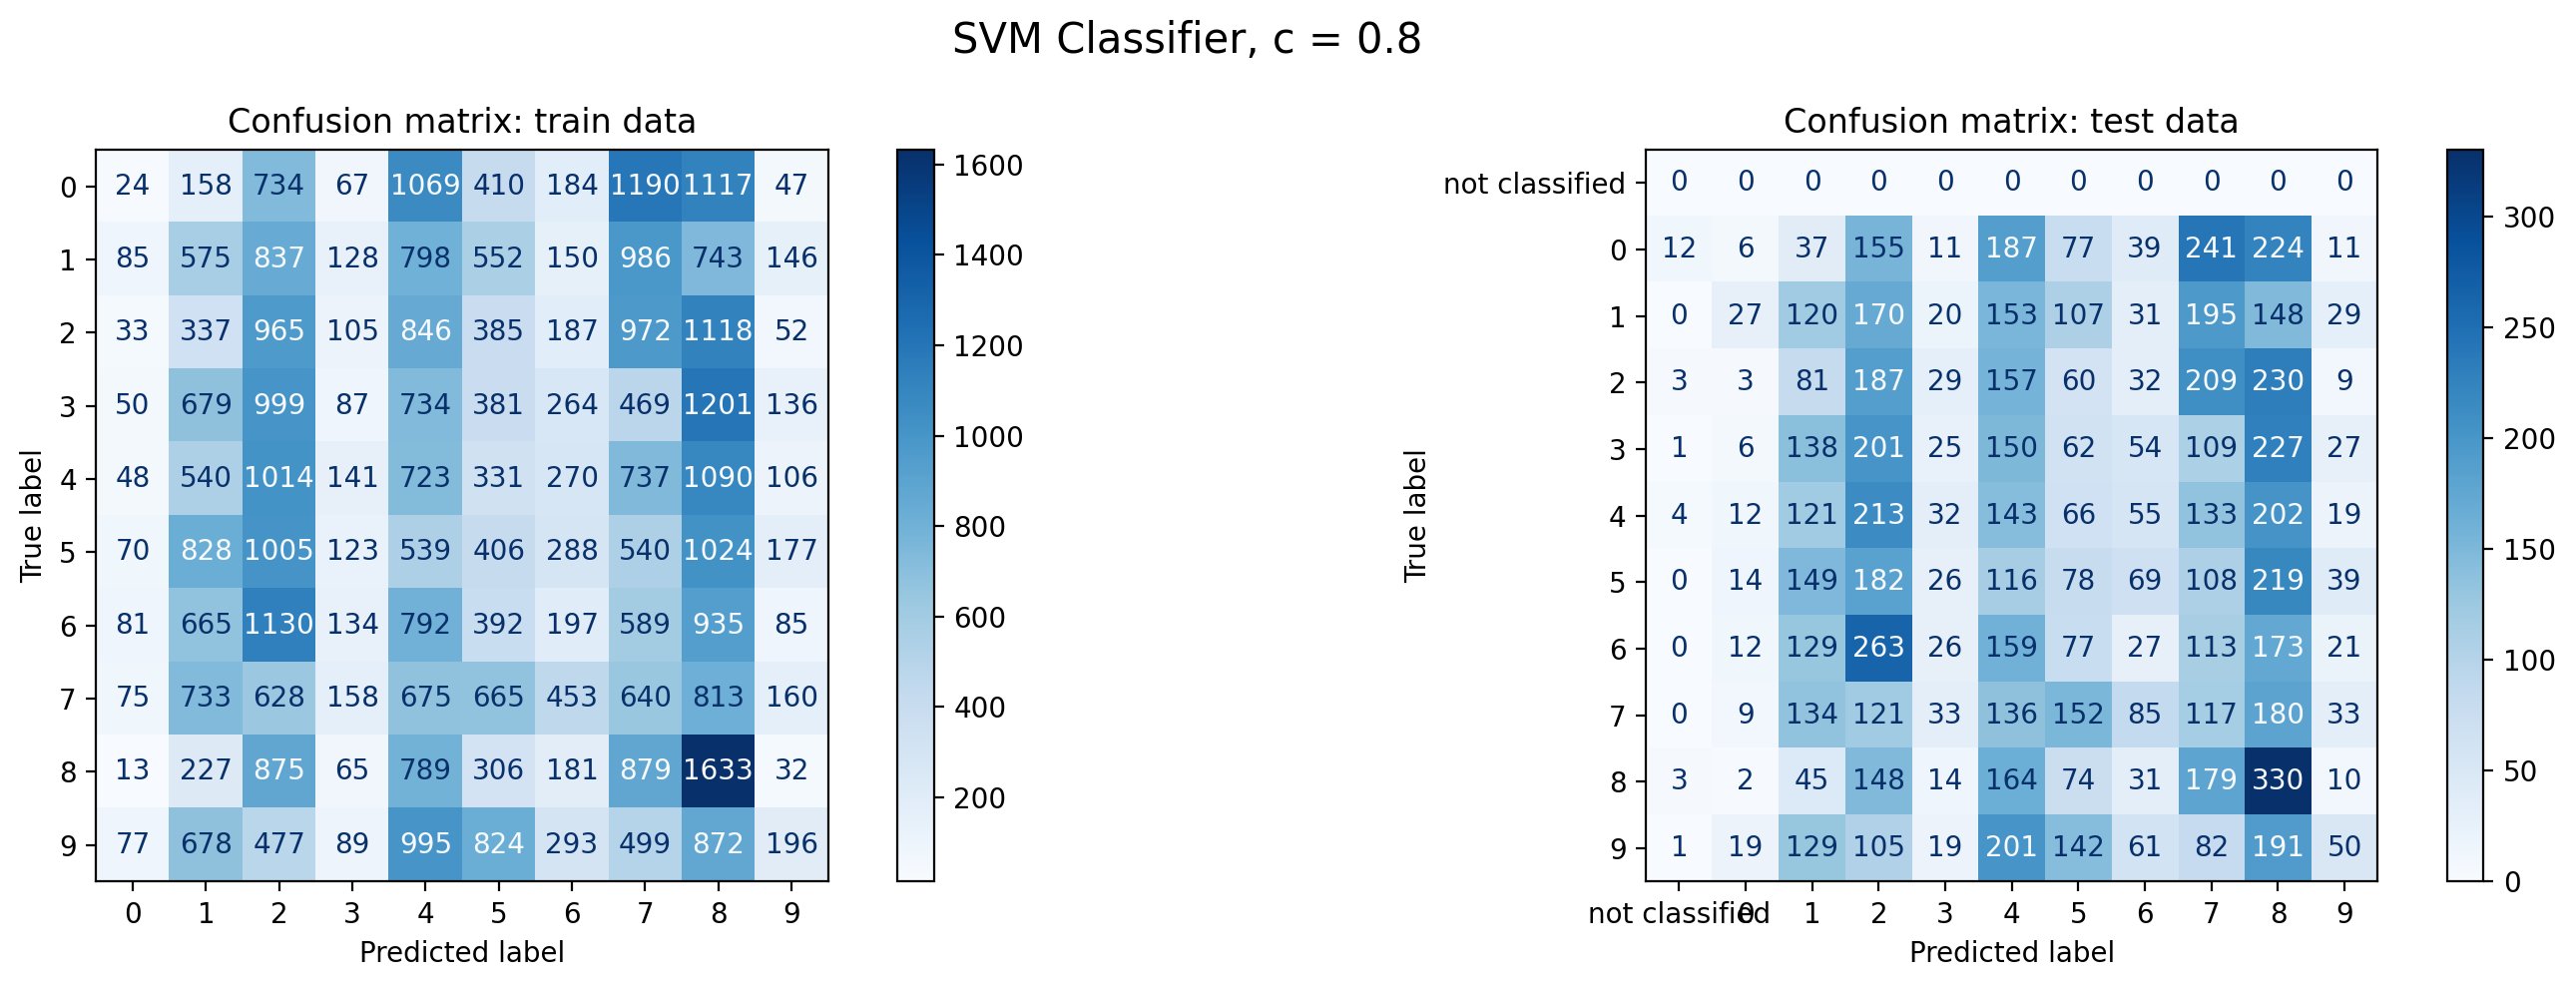

In [26]:
c = 0.8
svm_model = train_svm(mega_histogram, y_train, c)
y_test_pred = test_model(svm_model, kmeans_obj, X_test)
y_train_pred = test_model_train_set(svm_model, mega_histogram)
evaluate_model_svm(y_train_pred, y_test_pred,0.8 )
#10 mins

In [27]:
c_vect = np.array([0.2,0.5,0.8,1])
acc_train_vect_svm = np.zeros(len(c_vect))
acc_test_vect_svm = np.zeros(len(c_vect))
for i in range(0, len(c_vect)):
    c = c_vect[i]
    print("c=", c)
    svm_model = train_svm(mega_histogram, y_train, c)
    y_test_pred = test_model(svm_model, kmeans_obj, X_test)
    y_train_pred = test_model_train_set(svm_model, mega_histogram)
    acc_train_vect_svm[i] = accuracy_score(y_true=y_train, y_pred=y_train_pred)
    acc_test_vect_svm[i] = accuracy_score(y_true=y_test, y_pred=y_test_pred)

#29 mins

c= 0.2
Starting training with model SVM...
Training completed!
Time taken in training - 157.21068692207336
Testing started ..
Testing completed
Time taken in testing - 72.19768786430359
Testing started ..
Testing completed
Time taken in testing - 110.50106883049011
c= 0.5
Starting training with model SVM...
Training completed!
Time taken in training - 228.28450107574463
Testing started ..
Testing completed
Time taken in testing - 73.00615191459656
Testing started ..
Testing completed
Time taken in testing - 114.60936498641968
c= 0.8
Starting training with model SVM...
Training completed!
Time taken in training - 289.0720739364624
Testing started ..
Testing completed
Time taken in testing - 73.35034513473511
Testing started ..
Testing completed
Time taken in testing - 117.25682306289673
c= 1.0
Starting training with model SVM...
Training completed!
Time taken in training - 340.5712242126465
Testing started ..
Testing completed
Time taken in testing - 73.90505599975586
Testing started ..

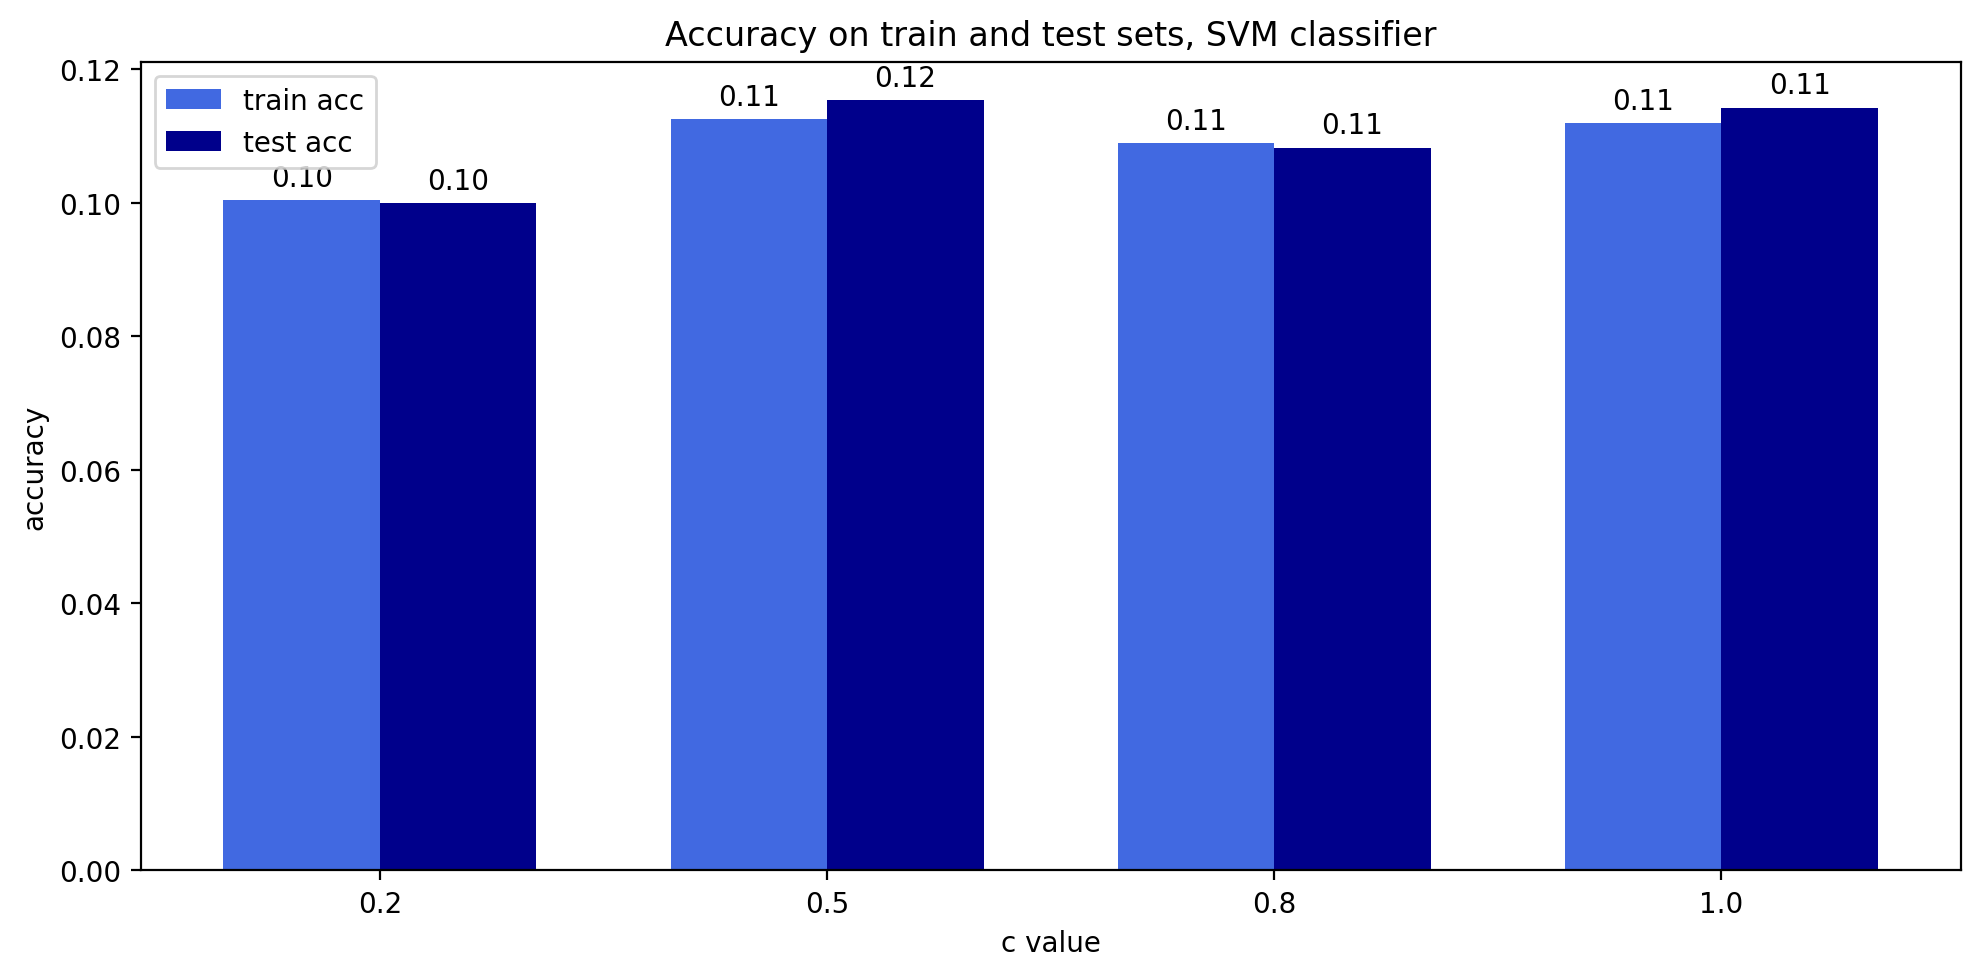

In [28]:
bar_width = 0.35
x_pos = range(len(c_vect))

fig, ax = plt.subplots(figsize=(10, 5))

train_bars = ax.bar(x_pos, acc_train_vect_svm, width=bar_width, label='train acc', color='royalblue')
test_bars = ax.bar([pos + bar_width for pos in x_pos], acc_test_vect_svm, width=bar_width, label='test acc', color='darkblue')

ax.set_xticks([pos + bar_width / 2 for pos in x_pos])
ax.set_xticklabels(c_vect)

ax.set_xlabel('c value')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy on train and test sets, SVM classifier')
ax.legend()

# function to add text labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom')

# add labels on top of the bars
add_labels(train_bars)
add_labels(test_bars)

plt.tight_layout()
plt.show()


##### k = 50

In [16]:
with open('mega_histogram_train_50.txt', 'rb') as f:
    mega_histogram = np.load(f)
kmeans_obj = joblib.load('kmeans_model_50.pkl')
no_clusters = kmeans_obj.n_clusters

Starting training with model SVM...
Training completed!
Time taken in training - 1215.5733880996704
Testing started ..
Testing completed
Time taken in testing - 155.57585787773132
Testing started ..
Testing completed
Time taken in testing - 346.4712550640106
########################################
Accuracy on train:  0.11978
Accuracy on test:  0.1183
########################################
Recall on train:  0.11978000000000003
Recall on test:  0.10754545454545453
########################################
Precision on train:  0.1227503937429478
Precision on test:  0.10994920901025074
########################################


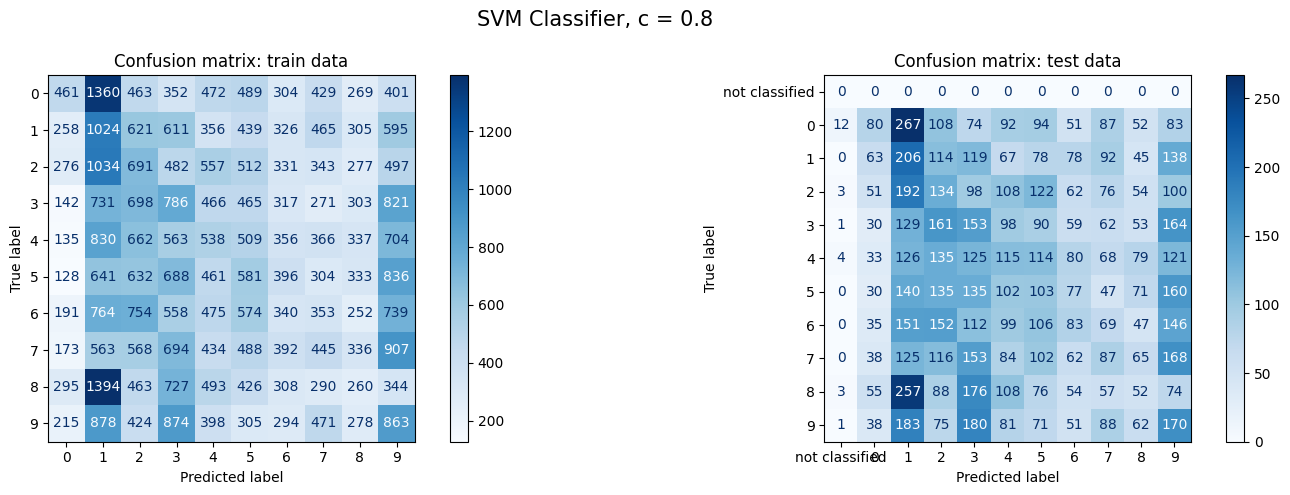

In [19]:
c = 0.8
svm_model = train_svm(mega_histogram, y_train, c)
y_test_pred = test_model(svm_model, kmeans_obj, X_test)
y_train_pred = test_model_train_set(svm_model, mega_histogram)
evaluate_model_svm(y_train_pred, y_test_pred,0.8 )
# 37 mins

In [20]:
c_vect = np.array([0.2,0.5,0.8,1])
acc_train_vect_svm = np.zeros(len(c_vect))
acc_test_vect_svm = np.zeros(len(c_vect))
for i in range(0, len(c_vect)):
    c = c_vect[i]
    print("c=", c)
    svm_model = train_svm(mega_histogram, y_train, c)
    y_test_pred = test_model(svm_model, kmeans_obj, X_test)
    y_train_pred = test_model_train_set(svm_model, mega_histogram)
    acc_train_vect_svm[i] = accuracy_score(y_true=y_train, y_pred=y_train_pred)
    acc_test_vect_svm[i] = accuracy_score(y_true=y_test, y_pred=y_test_pred)

c= 0.2
Starting training with model SVM...
Training completed!
Time taken in training - 450.8590738773346
Testing started ..
Testing completed
Time taken in testing - 84.81836009025574
Testing started ..
Testing completed
Time taken in testing - 314.4625291824341
c= 0.5
Starting training with model SVM...
Training completed!
Time taken in training - 777.3229992389679
Testing started ..
Testing completed
Time taken in testing - 104.59990096092224
Testing started ..
Testing completed
Time taken in testing - 292.30210304260254
c= 0.8
Starting training with model SVM...
Training completed!
Time taken in training - 1031.15100979805
Testing started ..
Testing completed
Time taken in testing - 103.47829103469849
Testing started ..
Testing completed
Time taken in testing - 243.69163012504578
c= 1.0
Starting training with model SVM...
Training completed!
Time taken in training - 1261.4324889183044
Testing started ..
Testing completed
Time taken in testing - 117.04479908943176
Testing started ..

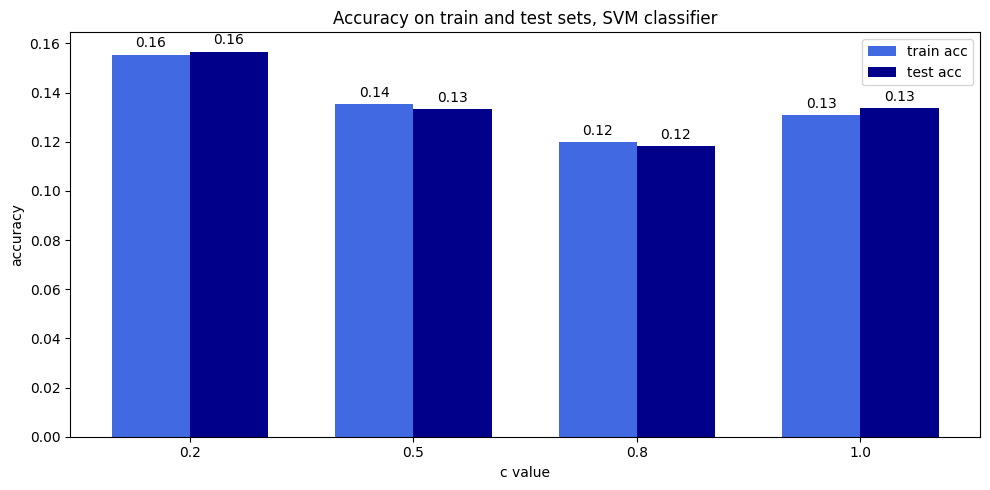

In [21]:
bar_width = 0.35
x_pos = range(len(c_vect))

fig, ax = plt.subplots(figsize=(10, 5))

train_bars = ax.bar(x_pos, acc_train_vect_svm, width=bar_width, label='train acc', color='royalblue')
test_bars = ax.bar([pos + bar_width for pos in x_pos], acc_test_vect_svm, width=bar_width, label='test acc', color='darkblue')

ax.set_xticks([pos + bar_width / 2 for pos in x_pos])
ax.set_xticklabels(c_vect)

ax.set_xlabel('c value')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy on train and test sets, SVM classifier')
ax.legend()

# function to add text labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom')

# add labels on top of the bars
add_labels(train_bars)
add_labels(test_bars)

plt.tight_layout()
plt.show()


### Multi Layer Perceptron (MLP) using Keras Sequential Model



##### Preparing the data

In [60]:
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train_s = X_train.astype('float32')
x_test_s = X_test.astype('float32')
x_train_s /= 255
x_test_s /= 255

# break training set into training and validation sets
(x_train_s, x_valid_s) = x_train_s[10000:], x_train_s[:10000]
(y_train_s, y_valid_s) = y_train[10000:], y_train[:10000]

# print shape of training set
print('x_train shape:', x_train_s.shape)

# print number of training, validation, and test images
print(x_train_s.shape[0], 'train samples')
print(x_test_s.shape[0], 'test samples')
print(x_valid_s.shape[0], 'validation samples')

x_train shape: (40000, 32, 32, 3)
40000 train samples
10000 test samples
10000 validation samples


##### Building and training the MLP

In [30]:
# model architecture
model = Sequential()
model.add(Flatten(input_shape = x_train_s.shape[1:]))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_3 (Dense)             (None, 200)               614600    
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 150)               30150     
                                                                 
 dropout_3 (Dropout)         (None, 150)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                1510      
                                                                 
Total params: 646260 (2.47 MB)
Trainable params: 64626

In [31]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', 
                  metrics=['accuracy'])

In [32]:
mlp_start = time.time() # for stopwatch

checkpointer = ModelCheckpoint(filepath='MLP.best_weights.hdf5', verbose=1, 
                               save_best_only=True)
hist = model.fit(x_train_s, y_train_s, batch_size=32, epochs=50,
          validation_data=(x_valid_s, y_valid_s), callbacks=[checkpointer], 
          verbose=2, shuffle=True)

mlp_end = time.time()
mlp_took = mlp_end -mlp_start
print("took %s seconds"%(mlp_took))

Epoch 1/50

Epoch 1: val_loss improved from inf to 1.84761, saving model to MLP.best_weights.hdf5
1250/1250 - 10s - loss: 2.0436 - accuracy: 0.2358 - val_loss: 1.8476 - val_accuracy: 0.3375 - 10s/epoch - 8ms/step
Epoch 2/50


/Users/nadia/Desktop/TUSS23/ML/MachineLearningEx3/venv/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 1.84761 to 1.84219, saving model to MLP.best_weights.hdf5
1250/1250 - 9s - loss: 1.9365 - accuracy: 0.2849 - val_loss: 1.8422 - val_accuracy: 0.3329 - 9s/epoch - 7ms/step
Epoch 3/50

Epoch 3: val_loss improved from 1.84219 to 1.78795, saving model to MLP.best_weights.hdf5
1250/1250 - 9s - loss: 1.8949 - accuracy: 0.3053 - val_loss: 1.7880 - val_accuracy: 0.3634 - 9s/epoch - 7ms/step
Epoch 4/50

Epoch 4: val_loss improved from 1.78795 to 1.77143, saving model to MLP.best_weights.hdf5
1250/1250 - 9s - loss: 1.8664 - accuracy: 0.3194 - val_loss: 1.7714 - val_accuracy: 0.3642 - 9s/epoch - 7ms/step
Epoch 5/50

Epoch 5: val_loss improved from 1.77143 to 1.75606, saving model to MLP.best_weights.hdf5
1250/1250 - 9s - loss: 1.8549 - accuracy: 0.3248 - val_loss: 1.7561 - val_accuracy: 0.3724 - 9s/epoch - 7ms/step
Epoch 6/50

Epoch 6: val_loss improved from 1.75606 to 1.75474, saving model to MLP.best_weights.hdf5
1250/1250 - 9s - loss: 1.8431 - accuracy: 0.3295 

In [61]:
#Predict and Evaluate
y_test_pred_mlp = model.predict(x_test_s)
y_test_pred_mlp = np.argmax (y_test_pred_mlp, axis = 1)
y_test= np.argmax(y_test, axis=1)


y_train_pred_mlp = model.predict(x_train_s)
y_train_pred_mlp = np.argmax (y_train_pred_mlp, axis = 1)
y_train=np.argmax(y_train, axis=1)


1250/1250 [==============================] - 6s 4ms/step


In [62]:
def evaluate_mlp(y_train_pred, y_test_pred,y_train  = y_train[10000:]):
    # accuracy
    print("#"*40)
    print("Accuracy on train: ", accuracy_score(y_true=y_train, y_pred=y_train_pred))
    print("Accuracy on test: ", accuracy_score(y_true=y_test, y_pred=y_test_pred))
    # recall
    print("#"*40)
    print("Recall on train: ", recall_score(y_true=y_train, y_pred=y_train_pred, average='macro'))
    print("Recall on test: ", recall_score(y_true=y_test, y_pred=y_test_pred, average = 'macro'))
    # precision
    print("#"*40)
    print("Precision on train: ", precision_score(y_true=y_train, y_pred=y_train_pred, average='macro'))
    print("Precision on test: ", precision_score(y_true=y_test, y_pred=y_test_pred, average='macro'))

    # plot confusion matrices
    print("#"*40)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    c_1 = confusion_matrix(y_true=y_train, y_pred=y_train_pred)
    if (len(np.unique(y_train_pred))==10):
        cmd_1 = ConfusionMatrixDisplay(c_1, display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    else:
        cmd_1 = ConfusionMatrixDisplay(c_1, display_labels=['not classified', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    cmd_1.plot(ax=ax[0], cmap=plt.cm.Blues)
    ax[0].set_title("Confusion matrix: train data")

    c_2 = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
    if (len(np.unique(y_test_pred))==10):
        cmd_2 = ConfusionMatrixDisplay(c_2, display_labels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    else:
        cmd_2 = ConfusionMatrixDisplay(c_2, display_labels=['not classified', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
    cmd_2.plot(ax=ax[1], cmap=plt.cm.Blues)
    ax[1].set_title("Confusion matrix: test data")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

    plt.show()

########################################
Accuracy on train:  0.422325
Accuracy on test:  0.3972
########################################
Recall on train:  0.4221399113503873
Recall on test:  0.39720000000000005
########################################
Precision on train:  0.42742747904529715
Precision on test:  0.4025374005616846
########################################


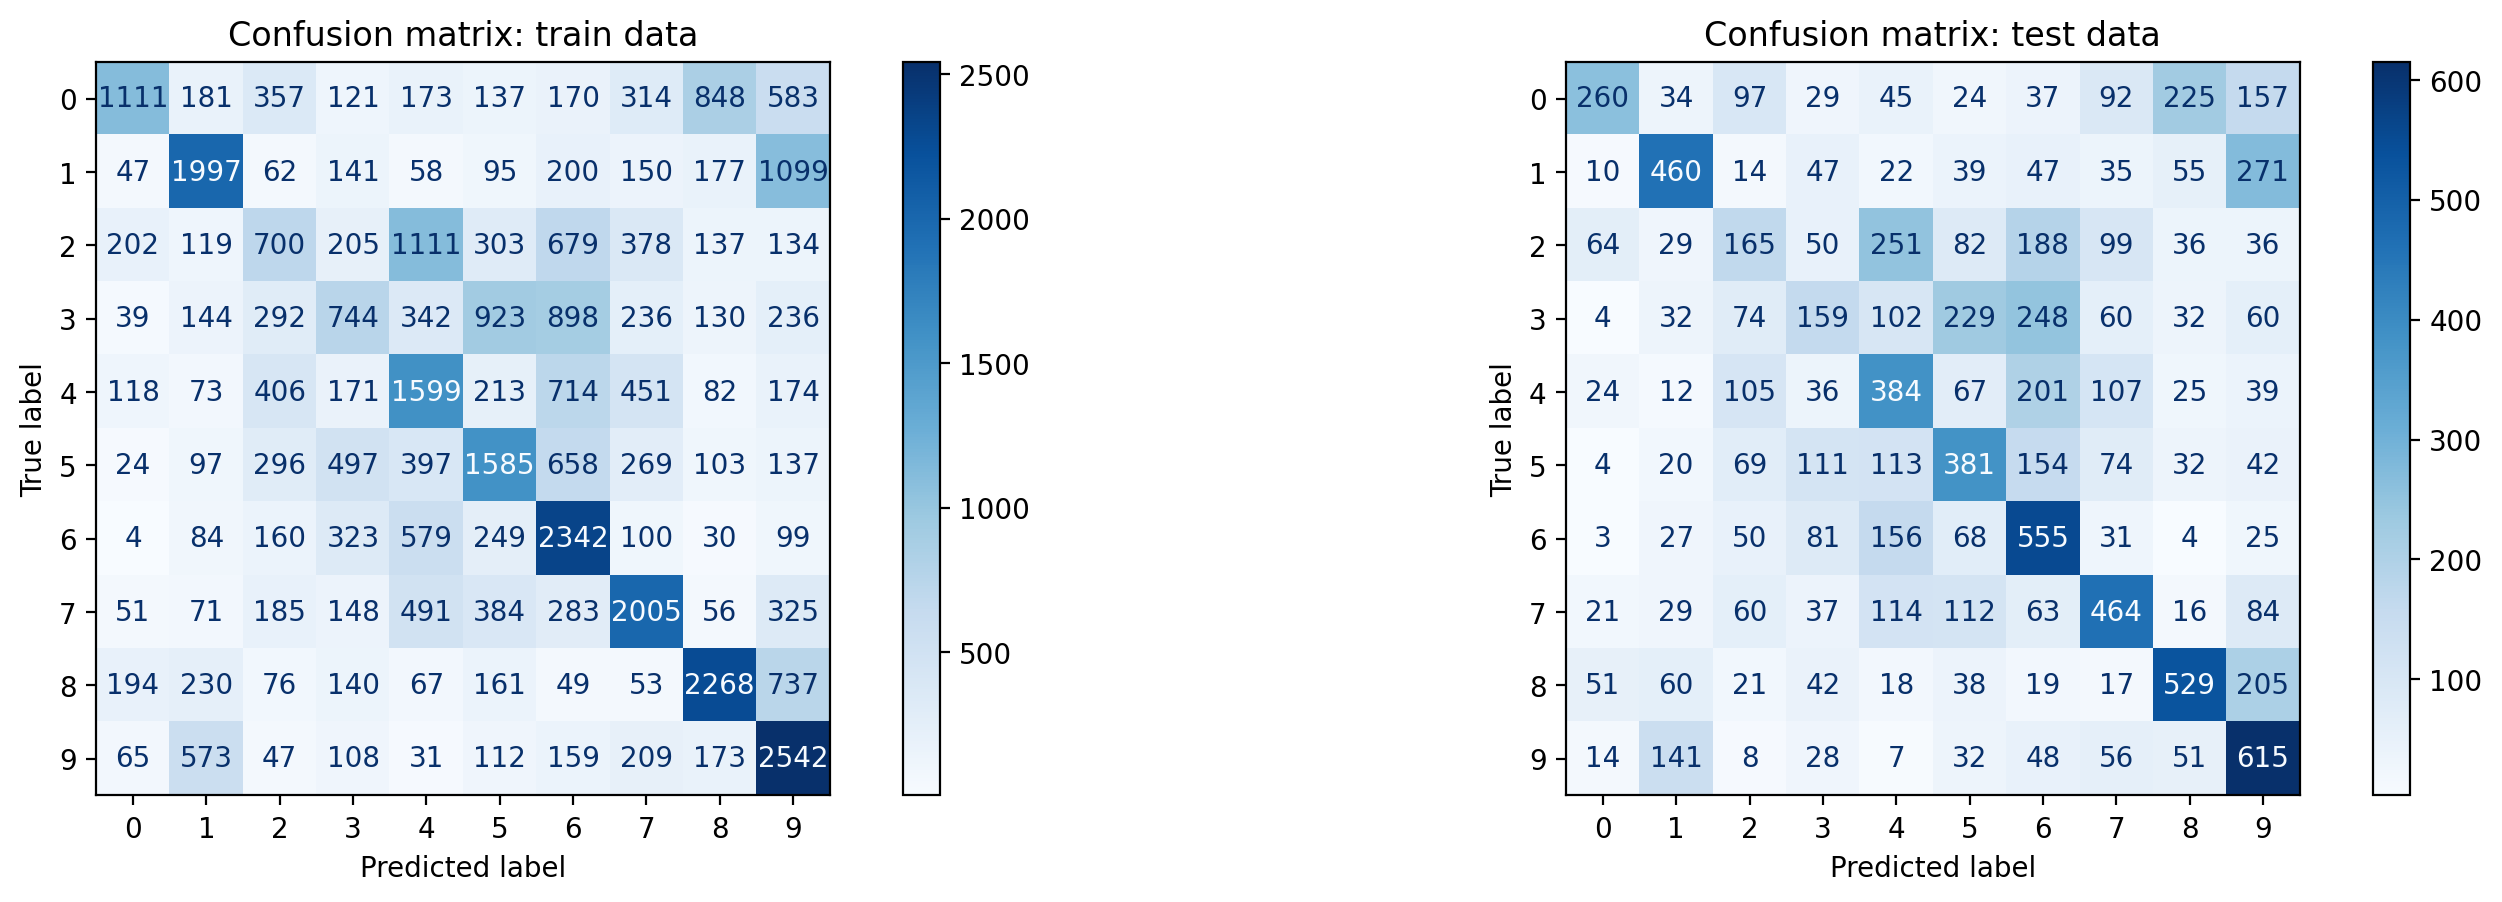

In [63]:
evaluate_mlp(y_train_pred_mlp, y_test_pred_mlp)

## Data From tensorflow

In [ ]:
cifar10 = tf.keras.datasets.cifar10

# Distribute it to train and test set
(X_train_tf, y_train_tf), (X_test_tf, y_test_tf) = cifar10.load_data()
print(X_train_tf.shape, y_train_tf.shape, X_test_tf.shape, y_test_tf.shape)

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

## Solution from deep-diver
https://github.com/deep-diver/CIFAR10-img-classification-tensorflow/blob/master/CIFAR10_image_classification.ipynb

In [ ]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

# cifar10_dataset_folder_path = 'cifar-10-batches-py'  # not used -> changed to os.getcwd + '/data/...
cd = os.getcwd()
cifar10_dataset_folder_path = cd + '/data/cifar/cifar-10-batches-py'

# class DownloadProgress(tqdm):
#     last_block = 0
#
#     def hook(self, block_num=1, block_size=1, total_size=None):
#         self.total = total_size
#         self.update((block_num - self.last_block) * block_size)
#         self.last_block = block_num
#
# """
#     check if the data (zip) file is already downloaded
#     if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
# """
# if not isfile('cifar-10-python.tar.gz'):
#     with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
#         urlretrieve(
#             'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
#             'cifar-10-python.tar.gz',
#             pbar.hook)
#
# if not isdir(cifar10_dataset_folder_path):
#     with tarfile.open('cifar-10-python.tar.gz') as tar:
#         tar.extractall()
#         tar.close()

In [ ]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:

def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

In [ ]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))

    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))

    plt.imshow(sample_image)

In [ ]:
# Explore the dataset
batch_id = 3
sample_id = 7000
cd = os.getcwd()
print(cd)
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [ ]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))

    for idx, val in enumerate(x):
        encoded[idx][val] = 1

    return encoded

In [ ]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)

        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation],
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p')

In [ ]:
# preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [ ]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [ ]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

In [ ]:
a, b = load_cfar10_batch('data/cifar/cifar-10-batches-py', 1)


In [ ]:
# example of loading the cifar10 dataset
from matplotlib import pyplot
from tf.keras.datasets import cifar10
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
 # define subplot
 pyplot.subplot(330 + 1 + i)
 # plot raw pixel data
 pyplot.imshow(trainX[i])
# show the figure
pyplot.show()

In [ ]:
data_b1[10].reshape(-1,3,32,32)

In [ ]:
trainX[i]

In [ ]:
plt.imshow(a[20].reshape(32,32,3))